# Reinforcement Learning as a classifier in Intrusion Detection
### Using Stable-baselines 3, RLLib, and the NSL-KDD dataset

## Part I 
#### Load the dataset and establish baseline with XGBoost

There is a feature provided called 'level' which gives an indication of difficulty level for each sample. When creating the dataset 3 smaller datasets were created and 7 learners were trained on each smaller dataset, for a total of 21 learners. Each of these 21 learners were then used to predict the label of each sample. Level is the number of learners that correctly labeled that sample. 

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score
from gym import spaces
from stable_baselines3 import DQN
from ray.rllib.env import MultiAgentEnv
import functools
import ray.rllib.agents.dqn as dqn
from ray.tune.registry import register_env

lz4 not available, disabling sample compression. This will significantly impact RLlib performance. To install lz4, run `pip install lz4`.


In [2]:
##################################################################################################################
# Load the full NSL-KDD training and test sets
# There are two other possible NSL-KDD datasets ---
# NSL-KDD/KDDTrain+_20Percent.txt       is a training set which has 20 percent of the full training set
# NSL-KDD/KDDTest-21.txt                is a test set which does NOT contain level 21 difficulty samples (the easiest)
train_data = pd.read_csv('NSL-KDD/KDDTrain+.txt')
test_data  = pd.read_csv('NSL-KDD/KDDTest+.txt')

columns = (['duration'
,'protocol_type'
,'service'
,'flag'
,'src_bytes'
,'dst_bytes'
,'land'
,'wrong_fragment'
,'urgent'
,'hot'
,'num_failed_logins'
,'logged_in'
,'num_compromised'
,'root_shell'
,'su_attempted'
,'num_root'
,'num_file_creations'
,'num_shells'
,'num_access_files'
,'num_outbound_cmds'
,'is_host_login'
,'is_guest_login'
,'_count'
,'srv_count'
,'serror_rate'
,'srv_serror_rate'
,'rerror_rate'
,'srv_rerror_rate'
,'same_srv_rate'
,'diff_srv_rate'
,'srv_diff_host_rate'
,'dst_host_count'
,'dst_host_srv_count'
,'dst_host_same_srv_rate'
,'dst_host_diff_srv_rate'
,'dst_host_same_src_port_rate'
,'dst_host_srv_diff_host_rate'
,'dst_host_serror_rate'
,'dst_host_srv_serror_rate'
,'dst_host_rerror_rate'
,'dst_host_srv_rerror_rate'
,'attack'
,'level'])

train_data.columns=columns
test_data.columns =columns

In [3]:
####################################################################################################
# There are 39 types of attack in the dataset, but each maps to one of 4 broad categories:
# DoS, Probe, R2L, and U2R, which are used for the classification.
# The binary classification task requires prediction of 'normal' or 'not normal'

attack_category_map =   { 'normal': 'normal',
                        
                        'back': 'DoS',
                        'land': 'DoS',
                        'neptune': 'DoS',
                        'pod': 'DoS',
                        'smurf': 'DoS',
                        'teardrop': 'DoS',
                        'mailbomb': 'DoS',
                        'apache2': 'DoS',
                        'processtable': 'DoS',
                        'udpstorm': 'DoS',
                        
                        'ipsweep': 'Probe',
                        'nmap': 'Probe',
                        'portsweep': 'Probe',
                        'satan': 'Probe',
                        'mscan': 'Probe',
                        'saint': 'Probe',
                    
                        'ftp_write': 'R2L',
                        'guess_passwd': 'R2L',
                        'imap': 'R2L',
                        'multihop': 'R2L',
                        'phf': 'R2L',
                        'spy': 'R2L',
                        'warezclient': 'R2L',
                        'warezmaster': 'R2L',
                        'sendmail': 'R2L',
                        'named': 'R2L',
                        'snmpgetattack': 'R2L',
                        'snmpguess': 'R2L',
                        'xlock': 'R2L',
                        'xsnoop': 'R2L',
                        'worm': 'R2L',
                        
                        'buffer_overflow': 'U2R',
                        'loadmodule': 'U2R',
                        'perl': 'U2R',
                        'rootkit': 'U2R',
                        'httptunnel': 'U2R',
                        'ps': 'U2R',    
                        'sqlattack': 'U2R',
                        'xterm': 'U2R'
                    }

ATTACK_NAMES = list(attack_category_map.keys())
ATTACK_NAMES_TEST = test_data['attack'].unique()
            

In [4]:
class attack_encoder():
    """
    Use this to encode attacks with a numeric label in random order.
    
    Constructor takes no arguments (TODO: Pass a random seed)
    
    Methods
    -------------
    encode_attack(atk): Map a Series of strings (attacks) to numbers, with the order determined randomly at the construction of the class.
    decode_attack(atk): Map a Series of numbers back to their string representations, with the order determined randomly at the construction of the class.
    """
    def __init__(self):
        attack_indices   = [i for i in range(len(list(attack_category_map.keys())))]
        shuffled_indices = random.sample(attack_indices, len(attack_indices))
        inverse_shuffle  = [-1 for i in range(len(shuffled_indices))]
        for indx in range(len(shuffled_indices)):
            inverse_shuffle[shuffled_indices[indx]] = indx
        attacks = list(attack_category_map.keys())
        shuffled_attacks = [attacks[i] for i in shuffled_indices]
        self.full_attack_map_ = {shuffled_attacks[i]: i for i in range(len(attacks))}
        self.inverse_attack_map_ = {i: shuffled_attacks[i] for i in range(len(attacks))}
    
    def encode_attack(self, atk):
        return atk.map(self.full_attack_map_)
    
    def decode_attack(self, atk):
        return atk.map(self.inverse_attack_map_)


#### Protocol_Type, Service, and Flag are categorical features so they are one-hot encoded

In [5]:
pd.set_option('max_columns', 200)
string_data = ['protocol_type', 'service', 'flag']
train_dummies = pd.get_dummies(train_data[string_data])
test_dummies  = pd.get_dummies(test_data[string_data])

#Make sure to add the same one-hot features to both train and test so the columns match!
missing_cols = [x for x in train_dummies.columns if not x in test_dummies.columns]
extra_cols   = [x for x in test_dummies.columns if not x in train_dummies.columns]

train_cols   = train_dummies.columns
test_cols    = test_dummies.columns
train_idx    = train_data.index
test_idx     = test_data.index
add_to_test  = pd.DataFrame(0, columns=missing_cols, index=test_idx)
add_to_train = pd.DataFrame(0, columns=extra_cols, index=train_idx)

fin_add_to_test = pd.concat([test_dummies, add_to_test], axis=1)
fin_add_to_train = pd.concat([train_dummies, add_to_train], axis=1)
cols = fin_add_to_train.columns
fin_add_to_test = fin_add_to_test.reindex(columns=cols)

fin_train_data = pd.concat([fin_add_to_train, train_data], axis=1)
fin_test_data  = pd.concat([fin_add_to_test, test_data], axis=1)
fin_train_data = fin_train_data.drop(string_data, axis=1)
fin_test_data  = fin_test_data.drop(string_data, axis=1)

#### We make 2 different labels, binary labels and broad categorical labels as described above

In [6]:
bin_target = train_data.attack.map(lambda a: 0 if a == 'normal' else 1)
bin_target_test = test_data.attack.map(lambda a: 0 if a == 'normal' else 1)

broad_target = train_data.attack.map(lambda a: attack_category_map[a])
broad_target_test = test_data.attack.map(lambda a: attack_category_map[a])

fin_train_data['bin_target']=bin_target
fin_test_data['bin_target']=bin_target_test
# fin_train_data['broad_target']=broad_target
# fin_test_data['broad_target']=broad_target_test

In [7]:
# Encode Broad Targets as integers 0-4 and and Attacks as integers 0-39
le = LabelEncoder()
broad_targets      = pd.Series(le.fit_transform(broad_target), name='Broad Targets')
broad_targets_test = pd.Series(le.transform(broad_target_test), name='Broad Targets')
atk = attack_encoder()
attack_num      = pd.Series(atk.encode_attack(fin_train_data.attack), name='Attack Number')
attack_num_test = pd.Series(atk.encode_attack(fin_test_data.attack), name='Attack Number')

In [8]:
fin_train_data['broad_target']=broad_targets
fin_test_data['broad_target']=broad_targets_test
fin_train_data['Attack Number'] = attack_num
fin_test_data['Attack Number'] = attack_num_test

### There are attacks in the test set which are not present in the training set
##### We can still predict their binary or broad target based on the binary or broad target classification described above though since all **categories** are present in both datasets

In [9]:
fin_train_data['Attack Number'].nunique()

23

#### attack, Attack Number, broad_target, bin_target, and level are not used for classification
##### Attack Number, level, and one of the targets are used in the adversarial environment and analysis below

In [10]:
bin_train = fin_train_data.drop(['attack', 'Attack Number', 'broad_target'], axis=1)
bin_test  = fin_test_data.drop(['attack',  'Attack Number', 'broad_target'], axis=1)
ae_bin_train = fin_train_data.drop(['attack', 'broad_target'], axis=1)
ae_bin_test  = fin_test_data.drop(['attack', 'broad_target'], axis=1)
current_cols = list(ae_bin_train.columns)
current_cols.remove('level')
current_cols.remove('bin_target')
current_cols.remove('Attack Number')
ae_bin_test = ae_bin_test.reindex(columns=current_cols + ['level', 'Attack Number', 'bin_target'])
ae_bin_train = ae_bin_train.reindex(columns=current_cols + ['level', 'Attack Number', 'bin_target'])
ae_bin_train

protocol_type_icmp  protocol_type_tcp  protocol_type_udp  service_IRC  \
0                        0                  0                  1            0   
1                        0                  1                  0            0   
2                        0                  1                  0            0   
3                        0                  1                  0            0   
4                        0                  1                  0            0   
...                    ...                ...                ...          ...   
125967                   0                  1                  0            0   
125968                   0                  0                  1            0   
125969                   0                  1                  0            0   
125970                   0                  1                  0            0   
125971                   0                  1                  0            0   

        service_X11  service_Z39_50  service_aol  service_auth  service_bgp  \
0                 0               0            0             0            0   
1                 0               0            0             0            0   
2                 0               0            0             0            0   
3                 0               0            0             0            0   
4                 0               0            0             0            0   
...             ...             ...          ...           ...          ...   
125967            0               0            0             0            0   
125968            0               0            0             0            0   
125969            0               0            0             0            0   
125970            0               0            0             0            0   
125971            0               0            0             0            0   

        service_courier  service_csnet_ns  service_ctf  service_daytime  \
0                     0                 0            0                0   
1                     0                 0            0                0   
2                     0                 0            0                0   
3                     0                 0            0                0   
4                     0                 0            0                0   
...                 ...               ...          ...              ...   
125967                0                 0            0                0   
125968                0                 0            0                0   
125969                0                 0            0                0   
125970                0                 0            0                0   
125971                0                 0            0                0   

        service_discard  service_domain  service_domain_u  service_echo  \
0                     0               0                 0             0   
1                     0               0                 0             0   
2                     0               0                 0             0   
3                     0               0                 0             0   
4                     0               0                 0             0   
...                 ...             ...               ...           ...   
125967                0               0                 0             0   
125968                0               0                 0             0   
125969                0               0                 0             0   
125970                0               0                 0             0   
125971                0               0                 0             0   

        service_eco_i  service_ecr_i  service_efs  service_exec  \
0                   0              0            0             0   
1                   0              0            0             0   
2                   0              0            0             0   
3               

In [11]:
def get_stats(pred, true):
    """ 
    Get dicts with correct count by attack, incorrect count by attack, and percent correct by attack
    input
    --------
    pred: a list of predicted labels
    true: a list of true labels
    
    output
    ---------
    correct:   A dictionary counting correct labels by attack type
    incorrect: A dictionary counting incorrect labels by attack type
    percent:   A dictionary counting percent correct labels by attack type
    """
    attack_names = ATTACK_NAMES_TEST # Use only attacks in the test set since we compute % correct (avoid division by zero)
    correct   = {i: 0 for i in attack_names}
    incorrect = {i: 0 for i in attack_names}
    percent   = {i: 0 for i in attack_names}

    for i in range(len(pred)):
        tp = atk.decode_attack(pd.Series(TEST_MATRIX[i][-2]))
        tp = tp.values[0]
        if pred[i] == true[i]:
            correct[tp] += 1
        else:
            incorrect[tp] += 1
            
    percent = {
        key: correct[key]/ (correct[key] + incorrect[key]) if key in incorrect else 1 for key in correct.keys() 
    }   
    
    return correct, incorrect, percent

In [12]:
def draw_plots(correct, incorrect, percent, Classifier_Name="", prefix='00', save=False):
    
    """
    Draw the plots we use for analysis of correct attack types
    
    inputs
    ----------
    correct:   A dictionary counting correct labels by attack type
    incorrect: A dictionary counting incorrect labels by attack type
    percent:   A dictionary counting percent correct labels by attack type
    
    (The above are the output of the get_stats function)
    
    Classifier_Name and Prefix are only used for saving the images with aptly named filenames
    e.g, 00XGBoostCorrect.png, 01Model1Percent.png,...
    """
    correct_keys   = sorted(correct, key=lambda dict_key: abs(correct[dict_key]), reverse = True)
    incorrect_keys = sorted(incorrect, key=lambda dict_key: abs(incorrect[dict_key]), reverse = True)
    percent_keys   = sorted(percent, key=lambda dict_key: abs(percent[dict_key]), reverse = True)
    
    

    attack_names = ATTACK_NAMES_TEST
    plt.bar(incorrect_keys, sorted(incorrect.values(), reverse=True), color='r')
    plt.xticks(rotation=90)
    plt.title('Incorrect Classification by Model ' + Classifier_Name)
    if save:
        plt.savefig(prefix + 'Incorrect' + Classifier_Name + '.png', bbox_inches='tight')
    plt.show()
    
    plt.bar(correct_keys, sorted(correct.values(), reverse=True), color='g')
    plt.xticks(rotation=90)
    plt.title('Correct Classification by Model ' + Classifier_Name)
    if save:
        plt.savefig(prefix + 'Correct' + Classifier_Name + '.png', bbox_inches='tight')
    plt.show()
    
    plt.bar(percent_keys, sorted(percent.values(), reverse=True), color='b')
    plt.xticks(rotation=90)
    plt.title('Percent Correct Classification by Model ' + Classifier_Name)
    if save:
        plt.savefig(prefix + 'Percent' + Classifier_Name + '.png', bbox_inches='tight')
    plt.show()


# Part II 
#### Baseline with XGBoost Out of the Box

In [13]:
TEST_MATRIX = ae_bin_test.values
clf = xgb.XGBClassifier(use_label_encoder=False)
#Training features cannot include bin_label, level, or attack so use columns except the last 3 for features, and the final column as a label
clf.fit(ae_bin_train.values[:,:-3], ae_bin_train.values[:,-1], eval_metric='logloss')
pred  = clf.predict(ae_bin_test.values[:,:-3])
acc   = accuracy_score(ae_bin_test.values[:,-1], pred)
f1scr = f1_score(ae_bin_test.values[:,-1], pred)

print('----------XGBoost-----------------')
print('Accuracy:\t', acc)
print('F1:\t\t', f1scr) 

----------XGBoost-----------------
Accuracy:	 0.7842789335935767
F1:		 0.772150119477112


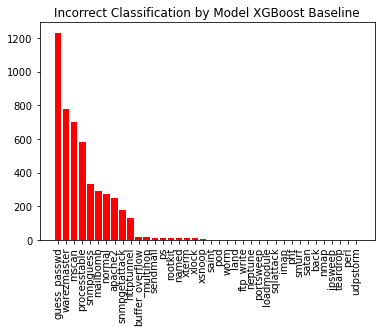

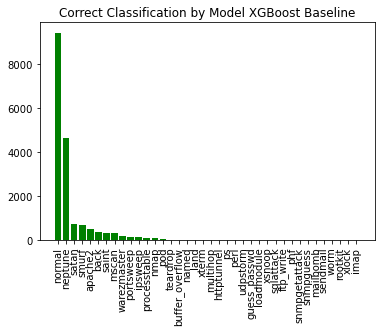

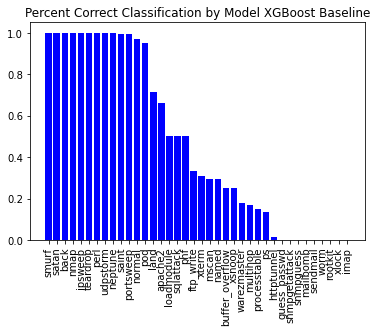

In [14]:
xgbcorrect, xgbincorrect, xgbpercent = get_stats(pred, ae_bin_test.values[:,-1])
draw_plots(xgbcorrect, xgbincorrect, xgbpercent, 'XGBoost Baseline', prefix='00', save=False)

# Part IIIa
#### Reinforcement Learning Model 1: Random Environment
We use a DQN agent from the Stable Baselines 3 repository. 
We set the action space to be the number of possible labels (either 2 or 5)
The observation space in the set of possible samples which are presented to the agent uniformly at random

In [16]:
import gym
N_DISCRETE_ACTIONS = fin_train_data['broad_target'].nunique()
N_DISCRETE_ACTIONS_BIN = 2
TRAIN_DATA         = ae_bin_train
TRAIN_MATRIX       = ae_bin_train.values
BATCH_SIZE         = 1

class CustomEnv(gym.Env):
  """Custom Environment that follows gym interface"""
  metadata = {'render.modes': ['human']}

  def __init__(self, eps):
    super(CustomEnv, self).__init__()
    self.action_space = spaces.Discrete(N_DISCRETE_ACTIONS_BIN)
    self.observation_space = spaces.Box(-np.inf, np.inf, shape=(BATCH_SIZE, len(TRAIN_DATA.columns)-3), dtype=np.dtype(float))

  def step(self, action):
    reward = 1 if self.last_label == action else 0
    
    indxs = [random.randint(0,len(TRAIN_MATRIX)-1) for i in range(BATCH_SIZE)]
    
    raw_observation = TRAIN_MATRIX[indxs][0]
    self.last_label = int(raw_observation[-1])
    observation     = raw_observation[:-3]
    done            = True
    info            = {}
    
    return observation, reward, done, info

  def reset(self):
    indxs = [random.randint(0,len(TRAIN_MATRIX)-2) for i in range(BATCH_SIZE)]
    
    raw_observation = TRAIN_MATRIX[indxs][0]
    self.last_label = int(raw_observation[-1])
    observation     = raw_observation[:-3]
    return observation  # reward, done, info can't be included

  def render(self, mode='human'):
    pass
  def close (self):
    pass

In [17]:
test_env = CustomEnv(eps=1)

In [19]:
agent = DQN('MlpPolicy', test_env, verbose=1)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [20]:
agent.learn(total_timesteps=100_000, log_interval=10_000)

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1        |
|    ep_rew_mean      | 0.51     |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 10000    |
|    fps              | 5035     |
|    time_elapsed     | 1        |
|    total timesteps  | 10000    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1        |
|    ep_rew_mean      | 0.58     |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 20000    |
|    fps              | 6933     |
|    time_elapsed     | 2        |
|    total timesteps  | 20000    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1        |
|    ep_rew_mean      | 0.45     |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes       

In [21]:
rews = 0
pred_model1 = [-1 for row in ae_bin_test.values]
i = 0
for row in ae_bin_test.values:
    action, _states = agent.predict(row[:-3].reshape(1,122), deterministic=True)
    pred_model1[i] = action
    i += 1
    if action == int(row[-1]):
        rews += 1


In [22]:
print('-------------------RL Model 1---------------------------')
print('Accuracy:\t ', accuracy_score(pred_model1, ae_bin_test.values[:,-1]))
print('F1:\t\t ', f1_score(pred_model1, ae_bin_test.values[:,-1]))

-------------------RL Model 1---------------------------
Accuracy:	  0.6511999290245309
F1:		  0.6550559333187101


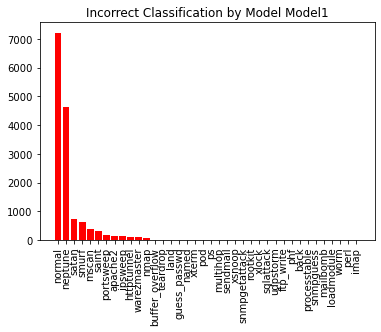

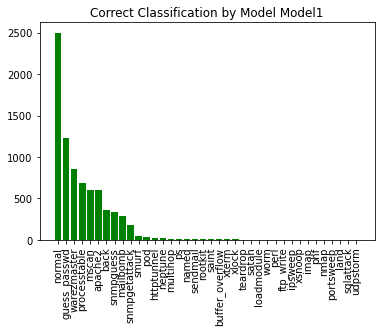

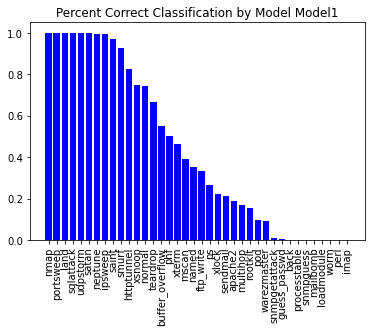

In [23]:
model1correct, model1incorrect, model1percent = get_stats(pred_model1, ae_bin_test.values[:,-1])
draw_plots(model1incorrect, model1correct, model1percent, 'Model1', prefix='01', save=False) 

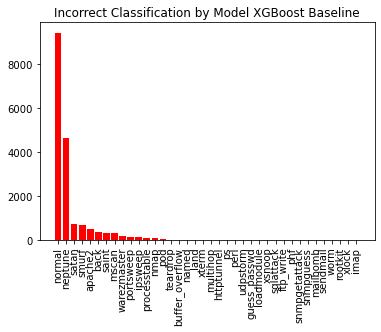

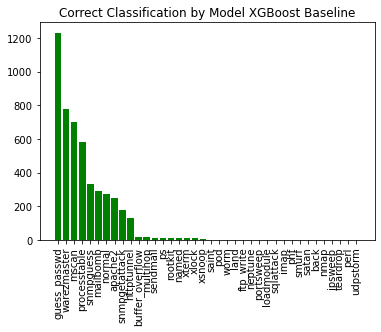

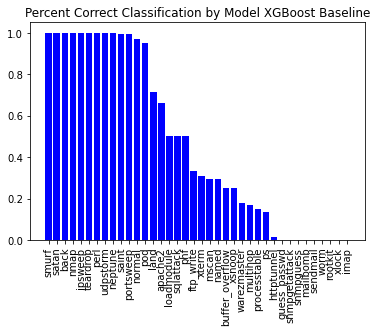

In [24]:
draw_plots(xgbincorrect, xgbcorrect, xgbpercent, 'XGBoost Baseline', prefix='00', save=False)

# Part IIIb
#### Reinforcement Learning with Adversarial Environment

Here we represent the environment as an agent also as in the paper "Adversarial environment reinforcement learning algorithm for intrusion detection" by Caminero, Lopez-Martin and Carro
The environment agent chooses the attack type to present to the classifier next, and receives the negative reward of the classifier. Additionally the environment receives a reward of -1 if an invalid action is predicted and to maintain a zero sum the classifier receives +1 reward in that case.

In [44]:
TRAIN_DATA         = ae_bin_train
TRAIN_MATRIX       = ae_bin_train.values
TRAIN_SUBMATRIX    = ae_bin_train.values
BATCH_SIZE         = 1
N_DISCRETE_ACTIONS = fin_train_data['broad_target'].nunique()
N_DISCRETE_ACTIONS_BIN = 2

class AdversarialCustomEnv(MultiAgentEnv):
    """Custom Environment that follows gym interface"""
    metadata = {'render.modes': ['human']}
    env_actions = TRAIN_DATA['Attack Number'].unique()
    
    action_mapping = {
        'env': spaces.Discrete(max(env_actions)),
        'clf': spaces.Discrete(2)
    }
    obs_mapping = {
        'env': spaces.Box(-np.inf, np.inf, shape=(BATCH_SIZE, len(TRAIN_DATA.columns)-3), dtype=np.dtype(float)),
        'clf': spaces.Box(-np.inf, np.inf, shape=(BATCH_SIZE, len(TRAIN_DATA.columns)-3), dtype=np.dtype(float))
    }

    @staticmethod
    def get_obs_space(type):
        return spaces.Box(-np.inf, np.inf, shape=(BATCH_SIZE, len(TRAIN_DATA.columns)-3), dtype=np.dtype(float))
    
    @staticmethod
    def get_action_space(type):
        return CustomEnv.action_mapping[type]
    
    
    def __init__(self, eps=1, N=2, player=0):
        super(AdversarialCustomEnv, self).__init__()
        # Define action and observation space
        # They must be gym.spaces objects
        # Example when using discrete actions:
        
        self.possible_agents = ['env', 'clf']
        self.env_actions = TRAIN_DATA['Attack Number'].unique()

        self._action_spaces = {'env': spaces.Discrete(max(self.env_actions)), 'clf': spaces.Discrete(N_DISCRETE_ACTIONS_BIN) }# {'agent_env': spaces.Discrete(max(self.env_actions)), 'agent_clf': spaces.Discrete(N_DISCRETE_ACTIONS_BIN) }
        # Example for using image as input:
        self._observation_spaces = spaces.Box(-np.inf, np.inf, shape=(BATCH_SIZE, len(TRAIN_DATA.columns)-3), dtype=np.dtype(float))# for agent in self.possible_agents }
         
        self.envs = []
        
        self.eps  = eps
        self.ep   = 0

        self.N    = N
        self.turn = 0

        #Keep track of the distribution of states selected
        self.dist = {}
        #Just for attack types
        self.att_dist = {i: 0 for i in self.env_actions}
        #End an episode when all samples have been selected at least once
        self.seen = [False for i in range(len(TRAIN_MATRIX))]
        self.player = player
        self.debug  = 0
        



    #@functools.lru_cache(maxsize=None)
    def observation_space(self, agent):
    # Gym spaces are defined and documented here: https://gym.openai.com/docs/#spaces
        print('obs called for ', agent)
        return self._observation_spaces[agent]

    #@functools.lru_cache(maxsize=None)
    def action_space(self, agent):
        return self._action_spaces[agent]


    def step(self, action):
        #print(action)
        environment_action = action['env']
        classifier_action  = action['clf']

        classifier_reward = 1 if self.last_label == classifier_action else -1
        environment_reward = -1*classifier_reward

        #print('rewards after step: ', classifier_reward, ' ', environment_reward)


        empty = True
        while empty:
            if environment_action in self.env_actions:
                TRAIN_SUBMATRIX = TRAIN_DATA.loc[TRAIN_DATA['Attack Number'] == environment_action]
                indxs = [random.choice(ae_bin_train.loc[ae_bin_train['Attack Number'] == environment_action].index) for i in range(BATCH_SIZE)]
                test_pull = TRAIN_MATRIX[indxs]
                empty = False
                if self.debug > 5:
                    print('------------------DEBUG INFO---------------------')
                    print('*** environment_action: ', environment_action)
                    print('*** len TRAIN_SUBMATRIX: ', len(ae_bin_train.loc[ae_bin_train['Attack Number'] == environment_action]))
                    print('*** indxs ', indxs)
                
                for indx in indxs:
                    
                    self.seen[indx] = True
                    if indx in self.dist:
                        self.dist[indx] += 1
                    else:
                        self.dist[indx] = 1
                #print(indx)
                self.att_dist[environment_action] += 1
                raw_observation = test_pull[0]
                self.last_label = int(raw_observation[-1])
                observation     = {agent: raw_observation[:-3].reshape(1,122) for agent in self.agents}

            else:
                # If the environment selects an invalid action, take a random action and subtract 1 from its reward
                # print(environment_action, ': Not in ')
                # print(list(self.env_actions))
                environment_reward -= 1
                classifier_reward  += 1

                #print('rewards after invalid action: ', classifier_reward, ' ', environment_reward)

                indxs = [random.randint(0,len(TRAIN_MATRIX)-1) for i in range(BATCH_SIZE)]
                #print(TRAIN_MATRIX[indxs])
                environment_action = TRAIN_MATRIX[indxs][0][-2]

        # Fix this to run through the dataset each episode
        done = {agent: not False in self.seen for agent in self.agents + ['__all__'] }
        info            = {agent: {} for agent in self.agents}

        reward = {'env': environment_reward, 'clf': classifier_reward}
        self.turn += 1
        if self.turn % 1000 == 0:
            print(len(self.dist))
            print(len(TRAIN_MATRIX) - len(self.dist), ' remaining~!')
            print('______________Attack Distributions Chosen___________________')
            print(self.att_dist)
        if done['__all__']:
            print('DONE')
            print(self.seen)
        return observation, reward, done, info

    def reset(self):
        
        self.agents = self.possible_agents[:]
        self.rewards = {agent: 0 for agent in self.agents}
        self._cumulative_rewards = {agent: 0 for agent in self.agents}
        self.dones = {agent: False for agent in self.agents}
        self.infos = {agent: {} for agent in self.agents}
        self.state = {agent: None for agent in self.agents}
        self.observations = {agent: None for agent in self.agents}
        self.num_moves = 0
        '''
        Our agent_selector utility allows easy cyclic stepping through the agents list.
        '''
        # self._agent_selector = agent_selector(self.agents)
        # self.agent_selection = self._agent_selector.next()
        
        indxs = [random.randint(0,len(TRAIN_MATRIX)-1) for i in range(BATCH_SIZE)]

        raw_observation = TRAIN_MATRIX[indxs][0]
        self.last_label = int(raw_observation[-1])
        observation     = {agent: raw_observation[:-3].reshape(1,122) for agent in self.agents}
        self.turn += 1
        return observation  # reward, done, info can't be included

    def render(self, mode='human'):
        pass
    def close (self):
        pass


Install gputil for GPU system monitoring.


817
125155  remaining~!
______________Attack Distributions Chosen___________________
{7: 256, 30: 194, 33: 30, 18: 32, 12: 31, 11: 27, 1: 26, 13: 36, 17: 39, 28: 31, 34: 24, 38: 0, 6: 24, 3: 22, 22: 24, 15: 21, 5: 30, 14: 28, 4: 21, 26: 29, 2: 28, 35: 25, 16: 21}
1466
124506  remaining~!
______________Attack Distributions Chosen___________________
{7: 472, 30: 344, 33: 60, 18: 69, 12: 83, 11: 60, 1: 45, 13: 79, 17: 65, 28: 53, 34: 42, 38: 0, 6: 61, 3: 43, 22: 44, 15: 50, 5: 98, 14: 51, 4: 44, 26: 58, 2: 57, 35: 60, 16: 61}
2106
123866  remaining~!
______________Attack Distributions Chosen___________________
{7: 679, 30: 462, 33: 85, 18: 115, 12: 137, 11: 83, 1: 84, 13: 117, 17: 109, 28: 92, 34: 70, 38: 0, 6: 96, 3: 69, 22: 64, 15: 81, 5: 147, 14: 91, 4: 71, 26: 90, 2: 84, 35: 83, 16: 90}
2753
123219  remaining~!
______________Attack Distributions Chosen___________________
{7: 861, 30: 595, 33: 115, 18: 180, 12: 189, 11: 120, 1: 106, 13: 159, 17: 156, 28: 138, 34: 113, 38: 0, 6: 119, 3:

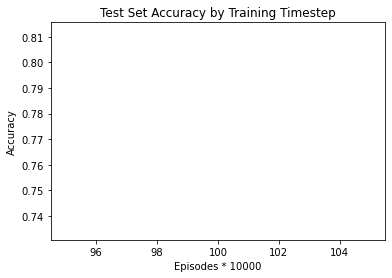

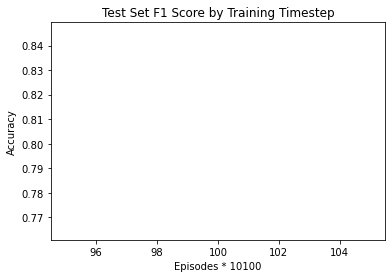

6091
119881  remaining~!
______________Attack Distributions Chosen___________________
{7: 1696, 30: 1247, 33: 429, 18: 431, 12: 476, 11: 343, 1: 393, 13: 474, 17: 401, 28: 248, 34: 352, 38: 0, 6: 377, 3: 258, 22: 446, 15: 366, 5: 618, 14: 385, 4: 400, 26: 447, 2: 428, 35: 458, 16: 326}
6558
119414  remaining~!
______________Attack Distributions Chosen___________________
{7: 1762, 30: 1297, 33: 478, 18: 460, 12: 528, 11: 394, 1: 470, 13: 499, 17: 510, 28: 278, 34: 443, 38: 0, 6: 408, 3: 295, 22: 473, 15: 398, 5: 727, 14: 409, 4: 412, 26: 484, 2: 435, 35: 498, 16: 341}
6933
119039  remaining~!
______________Attack Distributions Chosen___________________
{7: 1916, 30: 1368, 33: 481, 18: 509, 12: 532, 11: 407, 1: 538, 13: 512, 17: 522, 28: 344, 34: 454, 38: 0, 6: 451, 3: 313, 22: 497, 15: 420, 5: 728, 14: 616, 4: 511, 26: 487, 2: 469, 35: 510, 16: 414}
7262
118710  remaining~!
______________Attack Distributions Chosen___________________
{7: 2024, 30: 1373, 33: 513, 18: 583, 12: 602, 11: 40

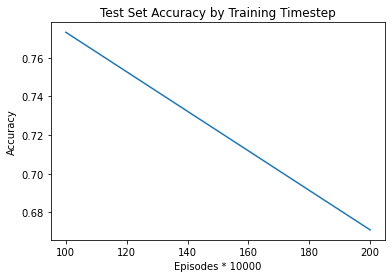

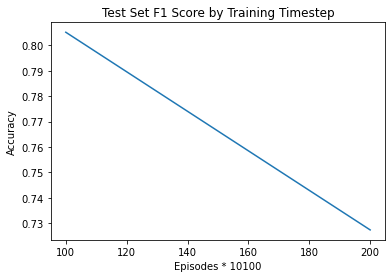

10296
115676  remaining~!
______________Attack Distributions Chosen___________________
{7: 2922, 30: 1822, 33: 1038, 18: 930, 12: 1007, 11: 764, 1: 914, 13: 734, 17: 836, 28: 620, 34: 722, 38: 0, 6: 803, 3: 457, 22: 765, 15: 708, 5: 1226, 14: 909, 4: 737, 26: 877, 2: 698, 35: 729, 16: 781}
10803
115169  remaining~!
______________Attack Distributions Chosen___________________
{7: 3016, 30: 2047, 33: 1045, 18: 934, 12: 1148, 11: 779, 1: 923, 13: 772, 17: 840, 28: 651, 34: 813, 38: 0, 6: 807, 3: 458, 22: 773, 15: 708, 5: 1234, 14: 988, 4: 808, 26: 885, 2: 848, 35: 741, 16: 781}
11104
114868  remaining~!
______________Attack Distributions Chosen___________________
{7: 3039, 30: 2077, 33: 1045, 18: 1032, 12: 1264, 11: 780, 1: 1024, 13: 796, 17: 853, 28: 726, 34: 875, 38: 0, 6: 818, 3: 514, 22: 825, 15: 709, 5: 1322, 14: 997, 4: 813, 26: 942, 2: 852, 35: 913, 16: 783}
11545
114427  remaining~!
______________Attack Distributions Chosen___________________
{7: 3388, 30: 2113, 33: 1050, 18: 1045

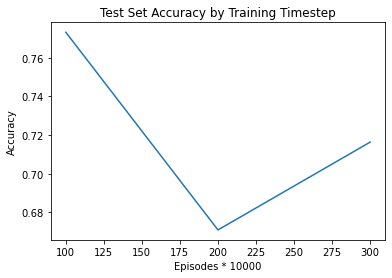

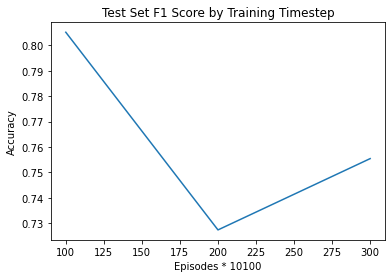

14770
111202  remaining~!
______________Attack Distributions Chosen___________________
{7: 5158, 30: 2668, 33: 1199, 18: 1223, 12: 1676, 11: 945, 1: 1322, 13: 947, 17: 1153, 28: 1501, 34: 1253, 38: 0, 6: 979, 3: 557, 22: 928, 15: 984, 5: 1506, 14: 1520, 4: 1303, 26: 997, 2: 1054, 35: 1202, 16: 924}
15160
110812  remaining~!
______________Attack Distributions Chosen___________________
{7: 5440, 30: 2675, 33: 1208, 18: 1223, 12: 1766, 11: 947, 1: 1333, 13: 976, 17: 1203, 28: 1531, 34: 1269, 38: 0, 6: 1025, 3: 559, 22: 934, 15: 984, 5: 1509, 14: 1627, 4: 1556, 26: 1009, 2: 1082, 35: 1214, 16: 929}
15395
110577  remaining~!
______________Attack Distributions Chosen___________________
{7: 5604, 30: 2700, 33: 1304, 18: 1228, 12: 1768, 11: 947, 1: 1352, 13: 1000, 17: 1204, 28: 1608, 34: 1286, 38: 0, 6: 1059, 3: 560, 22: 939, 15: 985, 5: 1517, 14: 1646, 4: 1868, 26: 1079, 2: 1180, 35: 1219, 16: 946}
15971
110001  remaining~!
______________Attack Distributions Chosen___________________
{7: 5747

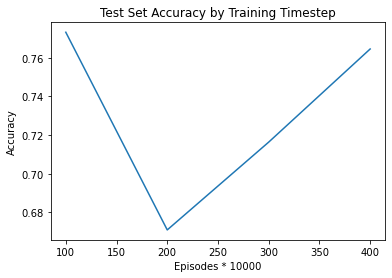

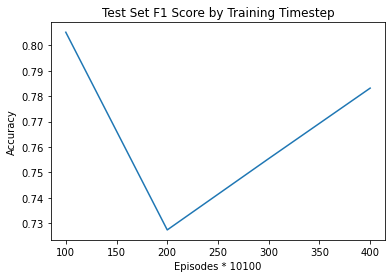

18731
107241  remaining~!
______________Attack Distributions Chosen___________________
{7: 7896, 30: 3013, 33: 1582, 18: 1357, 12: 2057, 11: 977, 1: 1542, 13: 1405, 17: 1541, 28: 1874, 34: 1689, 38: 0, 6: 1532, 3: 694, 22: 953, 15: 1020, 5: 1528, 14: 2315, 4: 2988, 26: 1146, 2: 1533, 35: 1288, 16: 1069}
19180
106792  remaining~!
______________Attack Distributions Chosen___________________
{7: 8263, 30: 3015, 33: 1701, 18: 1358, 12: 2062, 11: 1068, 1: 1543, 13: 1478, 17: 1587, 28: 1878, 34: 1689, 38: 0, 6: 1547, 3: 707, 22: 954, 15: 1029, 5: 1531, 14: 2408, 4: 3082, 26: 1147, 2: 1542, 35: 1297, 16: 1113}
19617
106355  remaining~!
______________Attack Distributions Chosen___________________
{7: 8698, 30: 3018, 33: 1708, 18: 1371, 12: 2063, 11: 1120, 1: 1543, 13: 1524, 17: 1587, 28: 1878, 34: 1690, 38: 0, 6: 1548, 3: 707, 22: 999, 15: 1130, 5: 1533, 14: 2511, 4: 3156, 26: 1147, 2: 1613, 35: 1314, 16: 1141}
19789
106183  remaining~!
______________Attack Distributions Chosen________________

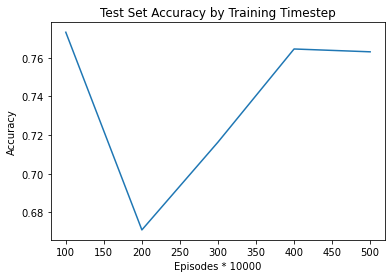

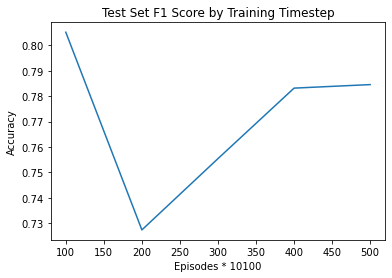

21890
104082  remaining~!
______________Attack Distributions Chosen___________________
{7: 10748, 30: 3154, 33: 1921, 18: 1434, 12: 2444, 11: 1319, 1: 1692, 13: 1566, 17: 1595, 28: 2327, 34: 1887, 38: 0, 6: 1740, 3: 812, 22: 1176, 15: 1396, 5: 1678, 14: 2938, 4: 5440, 26: 1176, 2: 1911, 35: 1327, 16: 1318}
22301
103671  remaining~!
______________Attack Distributions Chosen___________________
{7: 11045, 30: 3156, 33: 2064, 18: 1515, 12: 2462, 11: 1320, 1: 1710, 13: 1567, 17: 1723, 28: 2358, 34: 1893, 38: 0, 6: 1741, 3: 818, 22: 1177, 15: 1428, 5: 1679, 14: 2982, 4: 5444, 26: 1176, 2: 2095, 35: 1328, 16: 1318}
22445
103527  remaining~!
______________Attack Distributions Chosen___________________
{7: 11078, 30: 3160, 33: 2255, 18: 1522, 12: 2637, 11: 1320, 1: 1711, 13: 1571, 17: 1735, 28: 2409, 34: 1913, 38: 0, 6: 1741, 3: 818, 22: 1177, 15: 1460, 5: 1679, 14: 3032, 4: 5861, 26: 1177, 2: 2095, 35: 1328, 16: 1320}
22631
103341  remaining~!
______________Attack Distributions Chosen_________

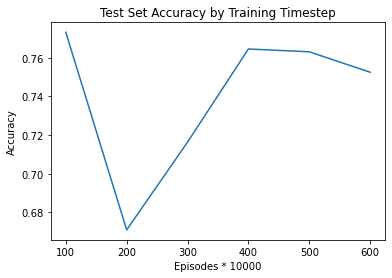

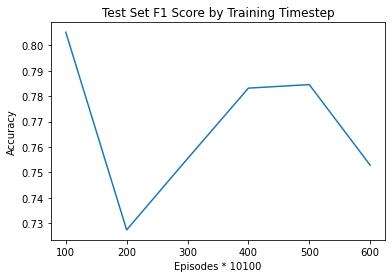

24694
101278  remaining~!
______________Attack Distributions Chosen___________________
{7: 13433, 30: 3199, 33: 2772, 18: 1527, 12: 3075, 11: 1324, 1: 1722, 13: 1615, 17: 1748, 28: 2927, 34: 2115, 38: 1, 6: 1745, 3: 826, 22: 1181, 15: 1466, 5: 1834, 14: 3164, 4: 9339, 26: 1178, 2: 2149, 35: 1332, 16: 1327}
24932
101040  remaining~!
______________Attack Distributions Chosen___________________
{7: 13653, 30: 3201, 33: 2896, 18: 1528, 12: 3092, 11: 1325, 1: 1724, 13: 1618, 17: 1823, 28: 3003, 34: 2173, 38: 1, 6: 1746, 3: 827, 22: 1183, 15: 1467, 5: 1835, 14: 3284, 4: 9620, 26: 1179, 2: 2162, 35: 1332, 16: 1327}
25220
100752  remaining~!
______________Attack Distributions Chosen___________________
{7: 13940, 30: 3203, 33: 2903, 18: 1529, 12: 3196, 11: 1326, 1: 1725, 13: 1619, 17: 1831, 28: 3020, 34: 2428, 38: 1, 6: 1746, 3: 836, 22: 1183, 15: 1468, 5: 1835, 14: 3329, 4: 9726, 26: 1215, 2: 2278, 35: 1335, 16: 1327}
25553
100419  remaining~!
______________Attack Distributions Chosen_________

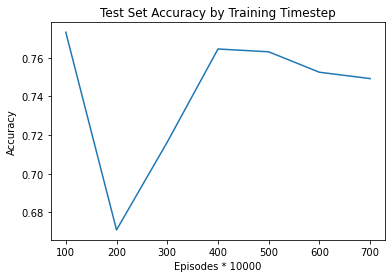

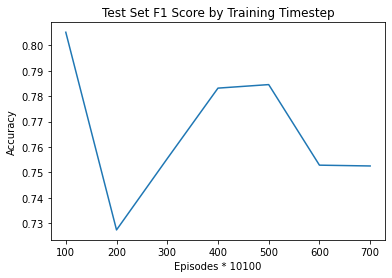

27625
98347  remaining~!
______________Attack Distributions Chosen___________________
{7: 16417, 30: 3226, 33: 3110, 18: 1533, 12: 3596, 11: 1332, 1: 1729, 13: 1655, 17: 2323, 28: 3551, 34: 2567, 38: 1, 6: 1749, 3: 901, 22: 1188, 15: 1469, 5: 1914, 14: 3670, 4: 12677, 26: 1286, 2: 2421, 35: 1341, 16: 1343}
27927
98045  remaining~!
______________Attack Distributions Chosen___________________
{7: 16779, 30: 3229, 33: 3121, 18: 1534, 12: 3605, 11: 1332, 1: 1730, 13: 1656, 17: 2324, 28: 3676, 34: 2668, 38: 1, 6: 1749, 3: 902, 22: 1193, 15: 1469, 5: 1914, 14: 3763, 4: 12784, 26: 1286, 2: 2598, 35: 1343, 16: 1343}
28244
97728  remaining~!
______________Attack Distributions Chosen___________________
{7: 17150, 30: 3232, 33: 3194, 18: 1534, 12: 3613, 11: 1332, 1: 1747, 13: 1661, 17: 2324, 28: 3681, 34: 2668, 38: 1, 6: 1751, 3: 903, 22: 1193, 15: 1480, 5: 1914, 14: 4063, 4: 12944, 26: 1288, 2: 2639, 35: 1344, 16: 1343}
28605
97367  remaining~!
______________Attack Distributions Chosen__________

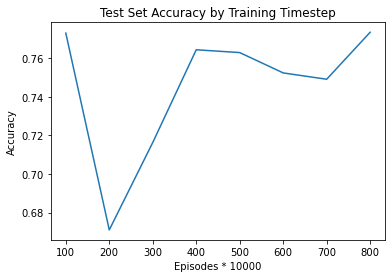

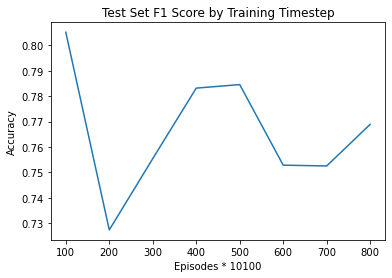

30793
95179  remaining~!
______________Attack Distributions Chosen___________________
{7: 20085, 30: 3270, 33: 3505, 18: 1537, 12: 4347, 11: 1335, 1: 1778, 13: 1681, 17: 2398, 28: 4023, 34: 3373, 38: 1, 6: 1756, 3: 1088, 22: 1207, 15: 1485, 5: 1936, 14: 4424, 4: 15026, 26: 1347, 2: 2694, 35: 1350, 16: 1353}
31020
94952  remaining~!
______________Attack Distributions Chosen___________________
{7: 20399, 30: 3272, 33: 3547, 18: 1539, 12: 4347, 11: 1336, 1: 1779, 13: 1683, 17: 2407, 28: 4048, 34: 3373, 38: 1, 6: 1756, 3: 1090, 22: 1208, 15: 1487, 5: 1937, 14: 4428, 4: 15614, 26: 1348, 2: 2696, 35: 1350, 16: 1354}
31257
94715  remaining~!
______________Attack Distributions Chosen___________________
{7: 20711, 30: 3276, 33: 3613, 18: 1541, 12: 4347, 11: 1336, 1: 1780, 13: 1683, 17: 2414, 28: 4079, 34: 3374, 38: 1, 6: 1757, 3: 1091, 22: 1208, 15: 1495, 5: 1938, 14: 4435, 4: 16171, 26: 1348, 2: 2697, 35: 1350, 16: 1354}
31267
94705  remaining~!
______________Attack Distributions Chosen_______

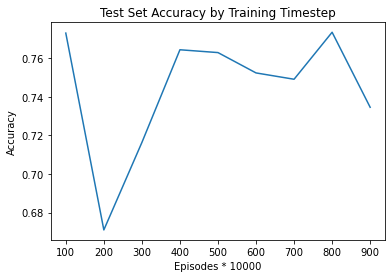

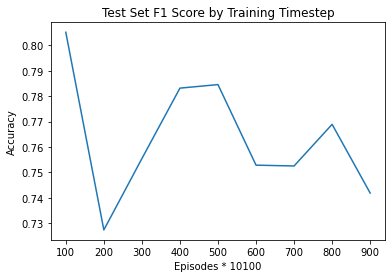

32982
92990  remaining~!
______________Attack Distributions Chosen___________________
{7: 22534, 30: 3304, 33: 4493, 18: 1544, 12: 4684, 11: 1340, 1: 1790, 13: 1692, 17: 3131, 28: 4769, 34: 3620, 38: 1, 6: 1760, 3: 1263, 22: 1256, 15: 1661, 5: 1944, 14: 5923, 4: 16773, 26: 1351, 2: 3445, 35: 1364, 16: 1357}
33195
92777  remaining~!
______________Attack Distributions Chosen___________________
{7: 22798, 30: 3308, 33: 4495, 18: 1545, 12: 4685, 11: 1341, 1: 1790, 13: 1724, 17: 3131, 28: 4887, 34: 3840, 38: 1, 6: 1760, 3: 1263, 22: 1257, 15: 1662, 5: 1945, 14: 6072, 4: 16975, 26: 1351, 2: 3446, 35: 1366, 16: 1357}
33604
92368  remaining~!
______________Attack Distributions Chosen___________________
{7: 23330, 30: 3312, 33: 4550, 18: 1545, 12: 4708, 11: 1341, 1: 1804, 13: 1727, 17: 3132, 28: 5011, 34: 3984, 38: 1, 6: 1760, 3: 1263, 22: 1257, 15: 1663, 5: 1945, 14: 6133, 4: 16998, 26: 1351, 2: 3459, 35: 1367, 16: 1358}
33955
92017  remaining~!
______________Attack Distributions Chosen_______

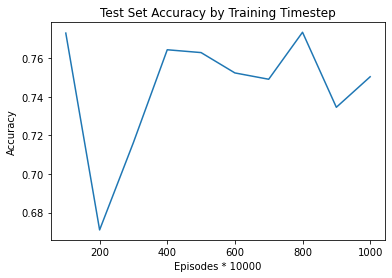

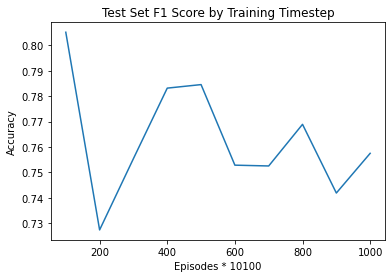

35777
90195  remaining~!
______________Attack Distributions Chosen___________________
{7: 26086, 30: 3331, 33: 5072, 18: 1547, 12: 4903, 11: 1345, 1: 1847, 13: 1732, 17: 3625, 28: 5723, 34: 4411, 38: 1, 6: 1783, 3: 1270, 22: 1261, 15: 1667, 5: 1953, 14: 6926, 4: 17865, 26: 1737, 2: 4124, 35: 1414, 16: 1376}
36043
89929  remaining~!
______________Attack Distributions Chosen___________________
{7: 26444, 30: 3333, 33: 5084, 18: 1548, 12: 4904, 11: 1345, 1: 1852, 13: 1733, 17: 3635, 28: 5805, 34: 4703, 38: 1, 6: 1826, 3: 1270, 22: 1274, 15: 1680, 5: 1954, 14: 7045, 4: 17876, 26: 1739, 2: 4127, 35: 1414, 16: 1407}
36184
89788  remaining~!
______________Attack Distributions Chosen___________________
{7: 26556, 30: 3336, 33: 5268, 18: 1549, 12: 5027, 11: 1345, 1: 1984, 13: 1735, 17: 3635, 28: 5829, 34: 4980, 38: 1, 6: 1826, 3: 1273, 22: 1323, 15: 1680, 5: 1954, 14: 7131, 4: 17877, 26: 1739, 2: 4128, 35: 1415, 16: 1408}
36559
89413  remaining~!
______________Attack Distributions Chosen_______

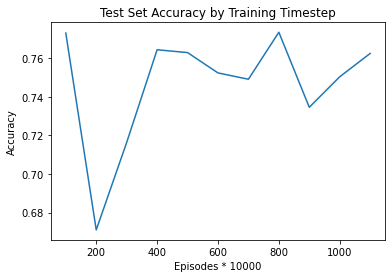

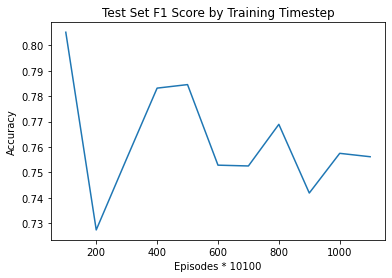

38614
87358  remaining~!
______________Attack Distributions Chosen___________________
{7: 29956, 30: 3355, 33: 5812, 18: 1556, 12: 5278, 11: 1348, 1: 1993, 13: 1745, 17: 4070, 28: 6485, 34: 5165, 38: 1, 6: 1833, 3: 1277, 22: 1449, 15: 2044, 5: 2046, 14: 8091, 4: 18582, 26: 1744, 2: 4298, 35: 1451, 16: 1420}
38892
87080  remaining~!
______________Attack Distributions Chosen___________________
{7: 30297, 30: 3358, 33: 5829, 18: 1557, 12: 5518, 11: 1349, 1: 2059, 13: 1747, 17: 4077, 28: 6537, 34: 5165, 38: 1, 6: 1833, 3: 1277, 22: 1449, 15: 2047, 5: 2046, 14: 8223, 4: 18665, 26: 1744, 2: 4300, 35: 1452, 16: 1469}
39089
86883  remaining~!
______________Attack Distributions Chosen___________________
{7: 30590, 30: 3360, 33: 5829, 18: 1558, 12: 5519, 11: 1350, 1: 2107, 13: 1747, 17: 4114, 28: 6718, 34: 5334, 38: 1, 6: 1834, 3: 1278, 22: 1449, 15: 2049, 5: 2048, 14: 8466, 4: 18675, 26: 1746, 2: 4301, 35: 1454, 16: 1472}
39288
86684  remaining~!
______________Attack Distributions Chosen_______

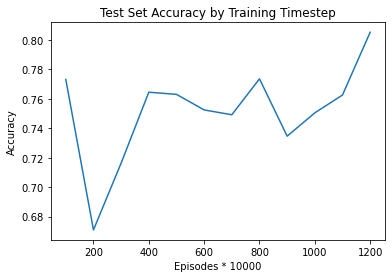

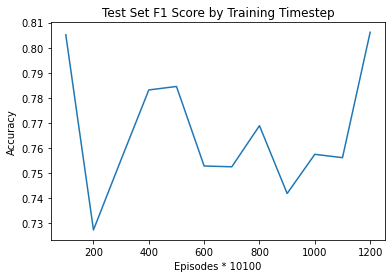

40569
85403  remaining~!
______________Attack Distributions Chosen___________________
{7: 32577, 30: 3383, 33: 6258, 18: 1568, 12: 5715, 11: 1352, 1: 2681, 13: 1756, 17: 4404, 28: 7173, 34: 5891, 38: 1, 6: 1836, 3: 1482, 22: 1454, 15: 2098, 5: 2073, 14: 10148, 4: 19601, 26: 1750, 2: 4452, 35: 1461, 16: 1885}
40772
85200  remaining~!
______________Attack Distributions Chosen___________________
{7: 32857, 30: 3386, 33: 6411, 18: 1569, 12: 5717, 11: 1352, 1: 2696, 13: 1802, 17: 4405, 28: 7348, 34: 5892, 38: 1, 6: 1836, 3: 1488, 22: 1454, 15: 2098, 5: 2082, 14: 10328, 4: 19649, 26: 1750, 2: 4531, 35: 1462, 16: 1885}
40941
85031  remaining~!
______________Attack Distributions Chosen___________________
{7: 33106, 30: 3389, 33: 6416, 18: 1569, 12: 5718, 11: 1354, 1: 2772, 13: 1812, 17: 4405, 28: 7381, 34: 5894, 38: 1, 6: 1836, 3: 1756, 22: 1454, 15: 2098, 5: 2082, 14: 10499, 4: 19791, 26: 1750, 2: 4569, 35: 1462, 16: 1885}
41136
84836  remaining~!
______________Attack Distributions Chosen____

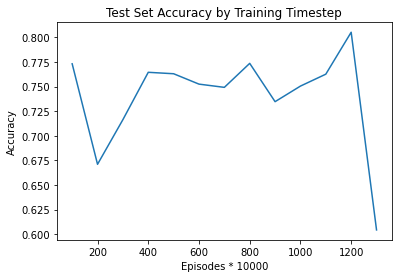

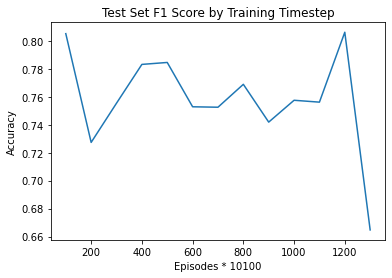

42315
83657  remaining~!
______________Attack Distributions Chosen___________________
{7: 34914, 30: 3412, 33: 6503, 18: 1577, 12: 6395, 11: 1360, 1: 3103, 13: 1819, 17: 4793, 28: 8396, 34: 6195, 38: 1, 6: 1841, 3: 1868, 22: 1541, 15: 2100, 5: 2108, 14: 12135, 4: 20879, 26: 1965, 2: 4725, 35: 1463, 16: 1906}
42513
83459  remaining~!
______________Attack Distributions Chosen___________________
{7: 35232, 30: 3413, 33: 6509, 18: 1577, 12: 6398, 11: 1361, 1: 3104, 13: 1819, 17: 4796, 28: 8400, 34: 6304, 38: 1, 6: 1841, 3: 1868, 22: 1541, 15: 2204, 5: 2108, 14: 12491, 4: 20967, 26: 1966, 2: 4727, 35: 1465, 16: 1907}
42615
83357  remaining~!
______________Attack Distributions Chosen___________________
{7: 35397, 30: 3416, 33: 6518, 18: 1577, 12: 6398, 11: 1361, 1: 3104, 13: 1819, 17: 4797, 28: 8401, 34: 6576, 38: 1, 6: 1841, 3: 1868, 22: 1541, 15: 2644, 5: 2108, 14: 12565, 4: 20974, 26: 1966, 2: 4727, 35: 1465, 16: 1935}
42655
83317  remaining~!
______________Attack Distributions Chosen____

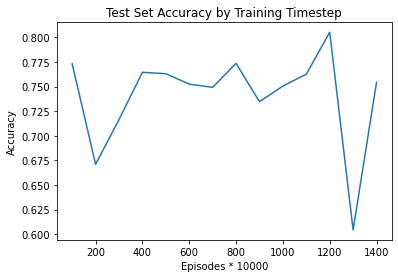

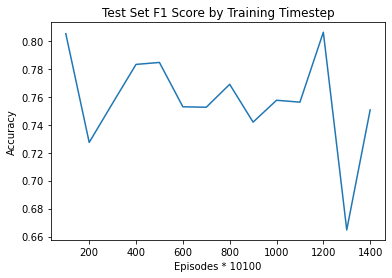

44367
81605  remaining~!
______________Attack Distributions Chosen___________________
{7: 38354, 30: 3443, 33: 6555, 18: 1587, 12: 6486, 11: 1366, 1: 3319, 13: 1826, 17: 4866, 28: 8420, 34: 7449, 38: 1, 6: 1844, 3: 1872, 22: 1834, 15: 2685, 5: 2114, 14: 14712, 4: 21864, 26: 1968, 2: 4803, 35: 1469, 16: 2162}
44654
81318  remaining~!
______________Attack Distributions Chosen___________________
{7: 38870, 30: 3445, 33: 6555, 18: 1587, 12: 6487, 11: 1366, 1: 3320, 13: 1826, 17: 4866, 28: 8442, 34: 7449, 38: 1, 6: 1844, 3: 1872, 22: 1835, 15: 2778, 5: 2114, 14: 14779, 4: 22146, 26: 1968, 2: 4816, 35: 1469, 16: 2164}
44872
81100  remaining~!
______________Attack Distributions Chosen___________________
{7: 39248, 30: 3448, 33: 6555, 18: 1590, 12: 6488, 11: 1367, 1: 3321, 13: 1827, 17: 4866, 28: 8443, 34: 7507, 38: 1, 6: 1844, 3: 1872, 22: 1837, 15: 2803, 5: 2116, 14: 15043, 4: 22263, 26: 1969, 2: 4818, 35: 1469, 16: 2304}
45054
80918  remaining~!
______________Attack Distributions Chosen____

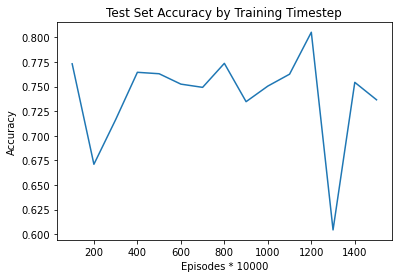

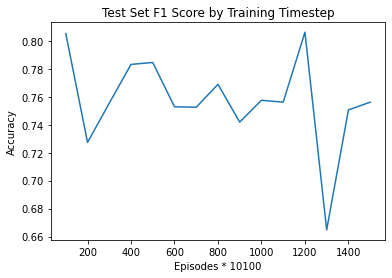

46274
79698  remaining~!
______________Attack Distributions Chosen___________________
{7: 41666, 30: 3474, 33: 6788, 18: 1596, 12: 6648, 11: 1379, 1: 3355, 13: 1836, 17: 5123, 28: 8833, 34: 7982, 38: 1, 6: 1846, 3: 1875, 22: 1844, 15: 2804, 5: 2122, 14: 16623, 4: 24359, 26: 1974, 2: 4876, 35: 1472, 16: 2523}
46452
79520  remaining~!
______________Attack Distributions Chosen___________________
{7: 41999, 30: 3480, 33: 6788, 18: 1596, 12: 6650, 11: 1381, 1: 3356, 13: 1836, 17: 5123, 28: 8833, 34: 7983, 38: 1, 6: 1847, 3: 1875, 22: 1844, 15: 2806, 5: 2122, 14: 16935, 4: 24586, 26: 1974, 2: 4971, 35: 1473, 16: 2540}
46738
79234  remaining~!
______________Attack Distributions Chosen___________________
{7: 42504, 30: 3485, 33: 6798, 18: 1597, 12: 6651, 11: 1382, 1: 3357, 13: 1837, 17: 5123, 28: 8834, 34: 7983, 38: 1, 6: 1847, 3: 1875, 22: 1846, 15: 2806, 5: 2132, 14: 17080, 4: 24753, 26: 1975, 2: 5093, 35: 1473, 16: 2567}
46880
79092  remaining~!
______________Attack Distributions Chosen____

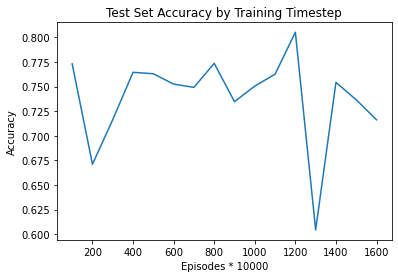

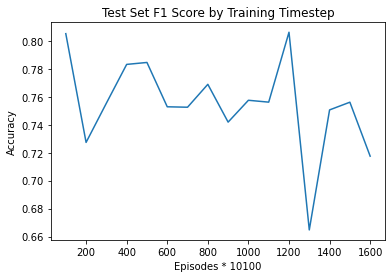

47918
78054  remaining~!
______________Attack Distributions Chosen___________________
{7: 44599, 30: 3511, 33: 7077, 18: 1603, 12: 6657, 11: 1395, 1: 3412, 13: 1840, 17: 5281, 28: 9187, 34: 8630, 38: 1, 6: 1853, 3: 1881, 22: 1855, 15: 2925, 5: 2207, 14: 19120, 4: 26291, 26: 2097, 2: 5137, 35: 1478, 16: 2962}
48191
77781  remaining~!
______________Attack Distributions Chosen___________________
{7: 45142, 30: 3513, 33: 7077, 18: 1603, 12: 6658, 11: 1395, 1: 3412, 13: 1841, 17: 5282, 28: 9187, 34: 8635, 38: 1, 6: 1853, 3: 1881, 22: 1856, 15: 2950, 5: 2208, 14: 19135, 4: 26691, 26: 2100, 2: 5138, 35: 1479, 16: 2962}
48359
77613  remaining~!
______________Attack Distributions Chosen___________________
{7: 45477, 30: 3515, 33: 7079, 18: 1604, 12: 6659, 11: 1395, 1: 3413, 13: 1841, 17: 5282, 28: 9280, 34: 8645, 38: 1, 6: 1854, 3: 1883, 22: 1856, 15: 2961, 5: 2208, 14: 19292, 4: 27018, 26: 2101, 2: 5138, 35: 1534, 16: 2963}
48587
77385  remaining~!
______________Attack Distributions Chosen____

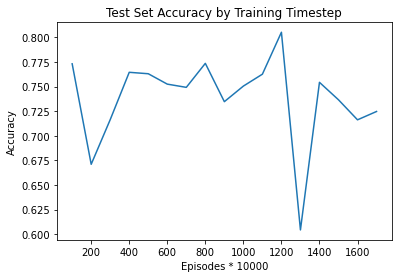

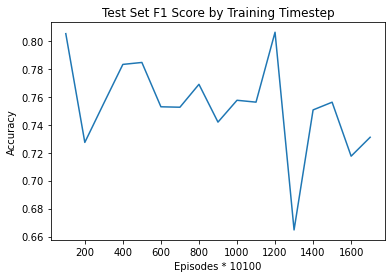

49929
76043  remaining~!
______________Attack Distributions Chosen___________________
{7: 48484, 30: 3539, 33: 7206, 18: 1606, 12: 6669, 11: 1400, 1: 3428, 13: 1846, 17: 5718, 28: 9570, 34: 8652, 38: 1, 6: 1858, 3: 1946, 22: 1861, 15: 3327, 5: 2212, 14: 20866, 4: 28721, 26: 2105, 2: 5144, 35: 1535, 16: 3305}
50078
75894  remaining~!
______________Attack Distributions Chosen___________________
{7: 48771, 30: 3541, 33: 7206, 18: 1606, 12: 6670, 11: 1400, 1: 3531, 13: 1847, 17: 5719, 28: 9586, 34: 8654, 38: 1, 6: 1859, 3: 1946, 22: 1861, 15: 3327, 5: 2213, 14: 20944, 4: 29228, 26: 2105, 2: 5144, 35: 1535, 16: 3305}
50275
75697  remaining~!
______________Attack Distributions Chosen___________________
{7: 49138, 30: 3541, 33: 7231, 18: 1608, 12: 6671, 11: 1400, 1: 3644, 13: 1847, 17: 5719, 28: 9628, 34: 8654, 38: 1, 6: 1860, 3: 1947, 22: 1861, 15: 3327, 5: 2213, 14: 20989, 4: 29629, 26: 2105, 2: 5146, 35: 1535, 16: 3305}
50471
75501  remaining~!
______________Attack Distributions Chosen____

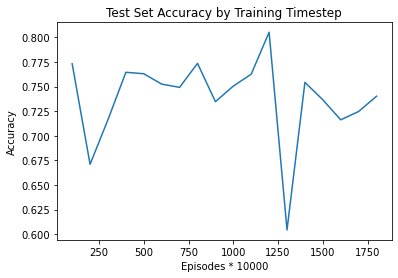

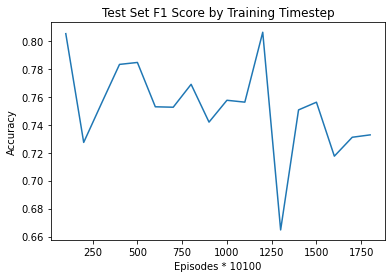

51812
74160  remaining~!
______________Attack Distributions Chosen___________________
{7: 52272, 30: 3573, 33: 7836, 18: 1612, 12: 6675, 11: 1403, 1: 3653, 13: 1856, 17: 5723, 28: 9789, 34: 8759, 38: 1, 6: 1866, 3: 1950, 22: 1866, 15: 3445, 5: 2315, 14: 22777, 4: 31099, 26: 2113, 2: 5230, 35: 1540, 16: 3646}
52007
73965  remaining~!
______________Attack Distributions Chosen___________________
{7: 52687, 30: 3573, 33: 7837, 18: 1612, 12: 6676, 11: 1406, 1: 3654, 13: 1856, 17: 5724, 28: 9948, 34: 8760, 38: 1, 6: 1868, 3: 1951, 22: 1868, 15: 3446, 5: 2315, 14: 22883, 4: 31403, 26: 2114, 2: 5230, 35: 1540, 16: 3647}
52195
73777  remaining~!
______________Attack Distributions Chosen___________________
{7: 53072, 30: 3574, 33: 7838, 18: 1613, 12: 6677, 11: 1406, 1: 3654, 13: 1857, 17: 5724, 28: 10111, 34: 8762, 38: 1, 6: 1877, 3: 1951, 22: 1868, 15: 3448, 5: 2316, 14: 23021, 4: 31696, 26: 2114, 2: 5230, 35: 1541, 16: 3648}
52351
73621  remaining~!
______________Attack Distributions Chosen___

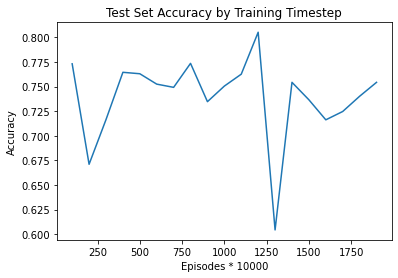

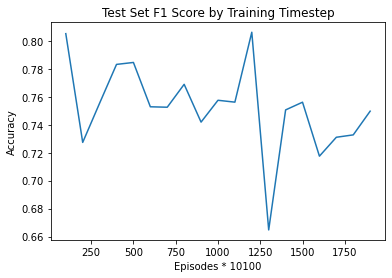

53506
72466  remaining~!
______________Attack Distributions Chosen___________________
{7: 55655, 30: 3672, 33: 8297, 18: 1617, 12: 6776, 11: 1411, 1: 3848, 13: 1885, 17: 5730, 28: 10613, 34: 9340, 38: 1, 6: 1950, 3: 1957, 22: 1936, 15: 3596, 5: 2336, 14: 24581, 4: 32887, 26: 2120, 2: 5373, 35: 1545, 16: 3873}
53634
72338  remaining~!
______________Attack Distributions Chosen___________________
{7: 55902, 30: 3675, 33: 8416, 18: 1617, 12: 6948, 11: 1413, 1: 3848, 13: 1886, 17: 5731, 28: 10627, 34: 9425, 38: 1, 6: 1950, 3: 1957, 22: 1937, 15: 3605, 5: 2336, 14: 24694, 4: 33073, 26: 2120, 2: 5373, 35: 1545, 16: 3920}
53783
72189  remaining~!
______________Attack Distributions Chosen___________________
{7: 56233, 30: 3681, 33: 8486, 18: 1619, 12: 6948, 11: 1414, 1: 3848, 13: 1887, 17: 5731, 28: 10627, 34: 9690, 38: 1, 6: 1950, 3: 1959, 22: 1937, 15: 3609, 5: 2336, 14: 24800, 4: 33166, 26: 2121, 2: 5405, 35: 1545, 16: 4006}
53867
72105  remaining~!
______________Attack Distributions Chosen_

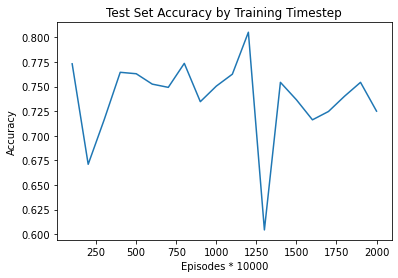

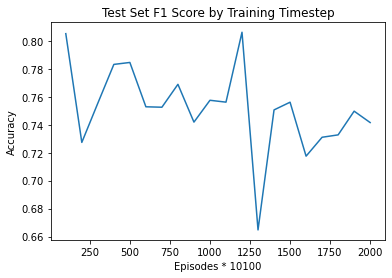

54842
71130  remaining~!
______________Attack Distributions Chosen___________________
{7: 58449, 30: 3719, 33: 9578, 18: 1637, 12: 7207, 11: 1417, 1: 3855, 13: 1903, 17: 6052, 28: 10793, 34: 10613, 38: 1, 6: 1951, 3: 2018, 22: 1938, 15: 3648, 5: 2406, 14: 26290, 4: 34336, 26: 2123, 2: 5509, 35: 1546, 16: 4010}
55046
70926  remaining~!
______________Attack Distributions Chosen___________________
{7: 58926, 30: 3721, 33: 9648, 18: 1637, 12: 7208, 11: 1417, 1: 3855, 13: 1908, 17: 6052, 28: 10794, 34: 10614, 38: 1, 6: 1951, 3: 2037, 22: 1938, 15: 3735, 5: 2406, 14: 26437, 4: 34524, 26: 2124, 2: 5509, 35: 1547, 16: 4010}
55169
70803  remaining~!
______________Attack Distributions Chosen___________________
{7: 59205, 30: 3723, 33: 9864, 18: 1637, 12: 7208, 11: 1418, 1: 3857, 13: 1912, 17: 6054, 28: 10851, 34: 10616, 38: 1, 6: 1951, 3: 2198, 22: 1942, 15: 3783, 5: 2406, 14: 26581, 4: 34596, 26: 2124, 2: 5509, 35: 1551, 16: 4012}
55320
70652  remaining~!
______________Attack Distributions Chos

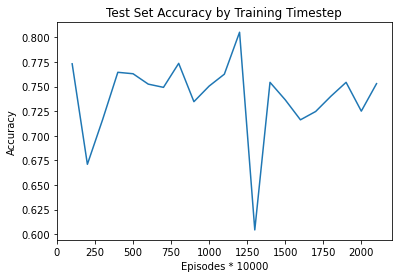

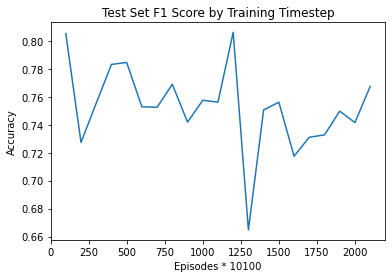

56016
69956  remaining~!
______________Attack Distributions Chosen___________________
{7: 61256, 30: 3747, 33: 10174, 18: 1640, 12: 7402, 11: 1421, 1: 3864, 13: 1923, 17: 6059, 28: 11310, 34: 12583, 38: 1, 6: 1958, 3: 2221, 22: 1944, 15: 4176, 5: 2475, 14: 27874, 4: 35147, 26: 2288, 2: 5517, 35: 1559, 16: 4460}
56136
69836  remaining~!
______________Attack Distributions Chosen___________________
{7: 61559, 30: 3750, 33: 10496, 18: 1660, 12: 7403, 11: 1421, 1: 3865, 13: 1923, 17: 6059, 28: 11314, 34: 12584, 38: 1, 6: 1958, 3: 2231, 22: 1944, 15: 4177, 5: 2475, 14: 28204, 4: 35147, 26: 2290, 2: 5517, 35: 1561, 16: 4460}
56318
69654  remaining~!
______________Attack Distributions Chosen___________________
{7: 61871, 30: 3751, 33: 10629, 18: 1729, 12: 7403, 11: 1422, 1: 3867, 13: 1923, 17: 6060, 28: 11325, 34: 12585, 38: 1, 6: 1958, 3: 2231, 22: 1945, 15: 4185, 5: 2475, 14: 28573, 4: 35237, 26: 2290, 2: 5517, 35: 1562, 16: 4460}
56467
69505  remaining~!
______________Attack Distributions C

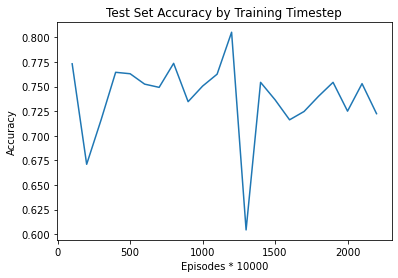

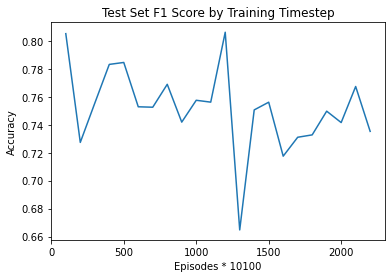

57485
68487  remaining~!
______________Attack Distributions Chosen___________________
{7: 64278, 30: 3783, 33: 11005, 18: 1768, 12: 7509, 11: 1427, 1: 3873, 13: 2029, 17: 6663, 28: 11407, 34: 12599, 38: 1, 6: 1959, 3: 2299, 22: 2348, 15: 4302, 5: 2482, 14: 29333, 4: 36878, 26: 2296, 2: 6156, 35: 1564, 16: 5040}
57579
68393  remaining~!
______________Attack Distributions Chosen___________________
{7: 64520, 30: 3787, 33: 11536, 18: 1768, 12: 7510, 11: 1428, 1: 3873, 13: 2029, 17: 6663, 28: 11408, 34: 12599, 38: 1, 6: 1959, 3: 2300, 22: 2348, 15: 4302, 5: 2482, 14: 29333, 4: 37096, 26: 2296, 2: 6157, 35: 1564, 16: 5040}
57737
68235  remaining~!
______________Attack Distributions Chosen___________________
{7: 64936, 30: 3792, 33: 11536, 18: 1768, 12: 7510, 11: 1428, 1: 3874, 13: 2029, 17: 6664, 28: 11408, 34: 12603, 38: 1, 6: 1959, 3: 2301, 22: 2350, 15: 4303, 5: 2482, 14: 29333, 4: 37663, 26: 2296, 2: 6158, 35: 1564, 16: 5041}
57874
68098  remaining~!
______________Attack Distributions C

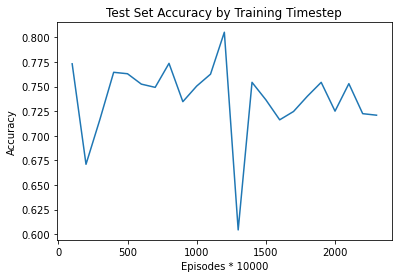

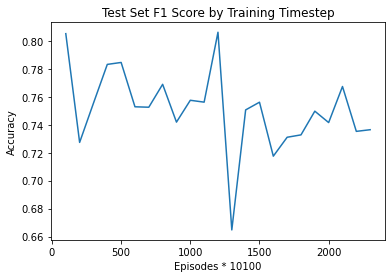

58674
67298  remaining~!
______________Attack Distributions Chosen___________________
{7: 67209, 30: 3816, 33: 12369, 18: 1775, 12: 8327, 11: 1438, 1: 3889, 13: 2032, 17: 6694, 28: 11596, 34: 13196, 38: 1, 6: 1967, 3: 2304, 22: 2354, 15: 4560, 5: 2490, 14: 31025, 4: 38668, 26: 2514, 2: 6162, 35: 1570, 16: 5043}
58874
67098  remaining~!
______________Attack Distributions Chosen___________________
{7: 67727, 30: 3819, 33: 12372, 18: 1776, 12: 8327, 11: 1438, 1: 3891, 13: 2033, 17: 6695, 28: 11597, 34: 13197, 38: 1, 6: 1967, 3: 2304, 22: 2354, 15: 4574, 5: 2490, 14: 31149, 4: 38990, 26: 2514, 2: 6168, 35: 1571, 16: 5045}
59011
66961  remaining~!
______________Attack Distributions Chosen___________________
{7: 68115, 30: 3826, 33: 12372, 18: 1776, 12: 8328, 11: 1438, 1: 3892, 13: 2033, 17: 6696, 28: 11634, 34: 13198, 38: 1, 6: 1968, 3: 2304, 22: 2355, 15: 4574, 5: 2499, 14: 31208, 4: 39483, 26: 2514, 2: 6169, 35: 1571, 16: 5045}
59187
66785  remaining~!
______________Attack Distributions C

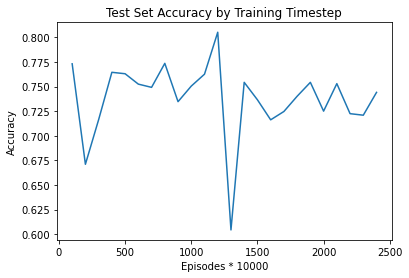

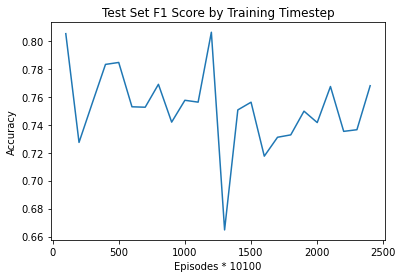

59920
66052  remaining~!
______________Attack Distributions Chosen___________________
{7: 70474, 30: 3845, 33: 12666, 18: 1786, 12: 8775, 11: 1441, 1: 3896, 13: 2041, 17: 6861, 28: 12579, 34: 13807, 38: 1, 6: 1970, 3: 2309, 22: 2634, 15: 4796, 5: 2517, 14: 32761, 4: 40527, 26: 2520, 2: 6173, 35: 1572, 16: 5048}
60110
65862  remaining~!
______________Attack Distributions Chosen___________________
{7: 71000, 30: 3850, 33: 12668, 18: 1786, 12: 8776, 11: 1442, 1: 3897, 13: 2045, 17: 6864, 28: 12580, 34: 13809, 38: 1, 6: 1970, 3: 2309, 22: 2636, 15: 4796, 5: 2517, 14: 32943, 4: 40796, 26: 2521, 2: 6173, 35: 1572, 16: 5048}
60273
65699  remaining~!
______________Attack Distributions Chosen___________________
{7: 71467, 30: 3852, 33: 12671, 18: 1786, 12: 8777, 11: 1443, 1: 3898, 13: 2046, 17: 6864, 28: 12581, 34: 13810, 38: 1, 6: 1972, 3: 2313, 22: 2636, 15: 4910, 5: 2528, 14: 33151, 4: 40976, 26: 2521, 2: 6174, 35: 1572, 16: 5050}
60416
65556  remaining~!
______________Attack Distributions C

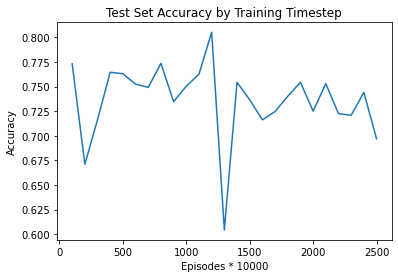

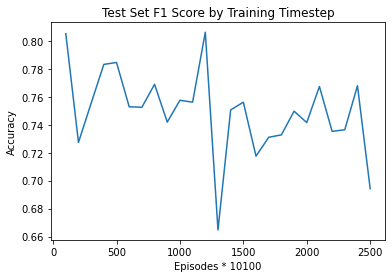

61544
64428  remaining~!
______________Attack Distributions Chosen___________________
{7: 74862, 30: 3885, 33: 12854, 18: 1791, 12: 8784, 11: 1483, 1: 3903, 13: 2057, 17: 6868, 28: 13156, 34: 13905, 38: 1, 6: 2052, 3: 2316, 22: 2802, 15: 5006, 5: 2595, 14: 33782, 4: 43545, 26: 2527, 2: 6198, 35: 1573, 16: 5054}
61702
64270  remaining~!
______________Attack Distributions Chosen___________________
{7: 75333, 30: 3888, 33: 12868, 18: 1792, 12: 8784, 11: 1483, 1: 3903, 13: 2057, 17: 6869, 28: 13157, 34: 13909, 38: 1, 6: 2081, 3: 2316, 22: 2802, 15: 5081, 5: 2595, 14: 33851, 4: 43876, 26: 2527, 2: 6198, 35: 1574, 16: 5054}
61832
64140  remaining~!
______________Attack Distributions Chosen___________________
{7: 75756, 30: 3890, 33: 13029, 18: 1792, 12: 8785, 11: 1483, 1: 3903, 13: 2058, 17: 6870, 28: 13158, 34: 13912, 38: 1, 6: 2139, 3: 2320, 22: 2803, 15: 5081, 5: 2595, 14: 33940, 4: 44127, 26: 2527, 2: 6199, 35: 1575, 16: 5056}
61990
63982  remaining~!
______________Attack Distributions C

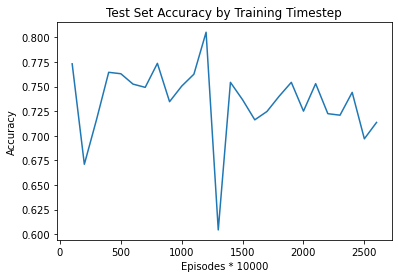

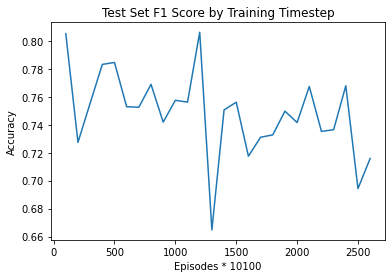

62925
63047  remaining~!
______________Attack Distributions Chosen___________________
{7: 79068, 30: 3913, 33: 14127, 18: 1797, 12: 8792, 11: 1500, 1: 3907, 13: 2063, 17: 6876, 28: 13163, 34: 13961, 38: 1, 6: 2144, 3: 2325, 22: 2809, 15: 5497, 5: 2602, 14: 35891, 4: 45017, 26: 2531, 2: 6378, 35: 1579, 16: 5058}
63047
62925  remaining~!
______________Attack Distributions Chosen___________________
{7: 79491, 30: 3916, 33: 14129, 18: 1798, 12: 8792, 11: 1501, 1: 3907, 13: 2066, 17: 6876, 28: 13164, 34: 13961, 38: 1, 6: 2145, 3: 2326, 22: 2810, 15: 5502, 5: 2603, 14: 36183, 4: 45017, 26: 2532, 2: 6641, 35: 1579, 16: 5059}
63186
62786  remaining~!
______________Attack Distributions Chosen___________________
{7: 79977, 30: 3918, 33: 14130, 18: 1798, 12: 8792, 11: 1507, 1: 3907, 13: 2066, 17: 6877, 28: 13164, 34: 13961, 38: 1, 6: 2145, 3: 2326, 22: 2810, 15: 5503, 5: 2603, 14: 36427, 4: 45031, 26: 2534, 2: 6882, 35: 1579, 16: 5061}
63312
62660  remaining~!
______________Attack Distributions C

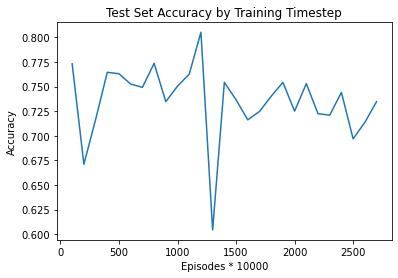

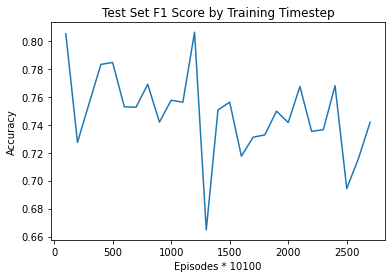

63953
62019  remaining~!
______________Attack Distributions Chosen___________________
{7: 82255, 30: 3934, 33: 15506, 18: 1801, 12: 9097, 11: 1777, 1: 3909, 13: 2079, 17: 6886, 28: 13278, 34: 14345, 38: 2, 6: 2149, 3: 2331, 22: 3018, 15: 5514, 5: 2654, 14: 38021, 4: 45619, 26: 2538, 2: 7417, 35: 1801, 16: 5068}
64077
61895  remaining~!
______________Attack Distributions Chosen___________________
{7: 82662, 30: 3937, 33: 15682, 18: 1802, 12: 9098, 11: 1778, 1: 3911, 13: 2079, 17: 6886, 28: 13286, 34: 14346, 38: 2, 6: 2149, 3: 2331, 22: 3018, 15: 5514, 5: 2655, 14: 38268, 4: 45658, 26: 2538, 2: 7530, 35: 1801, 16: 5068}
64168
61804  remaining~!
______________Attack Distributions Chosen___________________
{7: 83009, 30: 3939, 33: 15732, 18: 1803, 12: 9110, 11: 1778, 1: 3929, 13: 2080, 17: 6887, 28: 13489, 34: 14347, 38: 2, 6: 2150, 3: 2331, 22: 3018, 15: 5518, 5: 2656, 14: 38618, 4: 45658, 26: 2538, 2: 7536, 35: 1801, 16: 5070}
64301
61671  remaining~!
______________Attack Distributions C

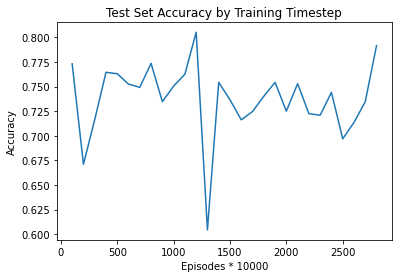

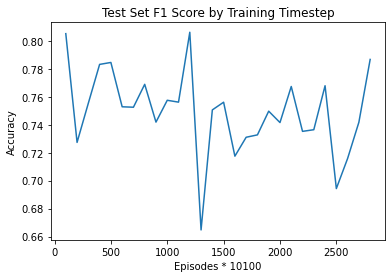

64902
61070  remaining~!
______________Attack Distributions Chosen___________________
{7: 85335, 30: 3992, 33: 16453, 18: 1810, 12: 9114, 11: 1790, 1: 3933, 13: 2085, 17: 6898, 28: 13999, 34: 14473, 38: 2, 6: 2154, 3: 2335, 22: 3022, 15: 5760, 5: 2664, 14: 40364, 4: 46201, 26: 2545, 2: 9191, 35: 1805, 16: 5074}
64971
61001  remaining~!
______________Attack Distributions Chosen___________________
{7: 85556, 30: 4000, 33: 16454, 18: 1810, 12: 9115, 11: 1791, 1: 3933, 13: 2085, 17: 7039, 28: 14301, 34: 14567, 38: 2, 6: 2154, 3: 2335, 22: 3023, 15: 5761, 5: 2664, 14: 40364, 4: 46428, 26: 2545, 2: 9191, 35: 1806, 16: 5075}
65119
60853  remaining~!
______________Attack Distributions Chosen___________________
{7: 85819, 30: 4003, 33: 16454, 18: 1811, 12: 9146, 11: 1791, 1: 3935, 13: 2199, 17: 7039, 28: 14420, 34: 14591, 38: 2, 6: 2154, 3: 2433, 22: 3026, 15: 5768, 5: 2665, 14: 40415, 4: 46709, 26: 2546, 2: 9192, 35: 1806, 16: 5075}
65198
60774  remaining~!
______________Attack Distributions C

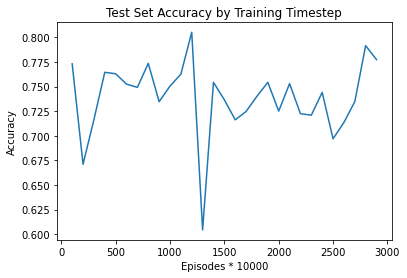

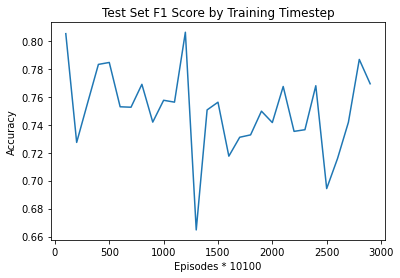

65555
60417  remaining~!
______________Attack Distributions Chosen___________________
{7: 87246, 30: 4022, 33: 16952, 18: 1818, 12: 9152, 11: 1794, 1: 4073, 13: 2204, 17: 7047, 28: 15277, 34: 15668, 38: 2, 6: 2161, 3: 2554, 22: 3032, 15: 5815, 5: 2667, 14: 41553, 4: 47892, 26: 2554, 2: 10030, 35: 1812, 16: 5674}
65570
60402  remaining~!
______________Attack Distributions Chosen___________________
{7: 87291, 30: 4028, 33: 16953, 18: 1818, 12: 9154, 11: 1796, 1: 4074, 13: 2204, 17: 7048, 28: 15279, 34: 15802, 38: 2, 6: 2161, 3: 2555, 22: 3032, 15: 5816, 5: 2667, 14: 41733, 4: 47991, 26: 2554, 2: 10030, 35: 1812, 16: 6199}
65632
60340  remaining~!
______________Attack Distributions Chosen___________________
{7: 87456, 30: 4031, 33: 16953, 18: 1818, 12: 9269, 11: 1796, 1: 4074, 13: 2206, 17: 7250, 28: 15279, 34: 16081, 38: 2, 6: 2161, 3: 2557, 22: 3032, 15: 5816, 5: 2667, 14: 41790, 4: 48159, 26: 2554, 2: 10034, 35: 1813, 16: 6201}
65659
60313  remaining~!
______________Attack Distribution

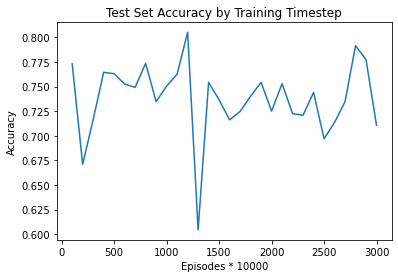

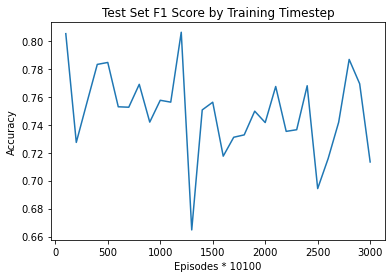

66093
59879  remaining~!
______________Attack Distributions Chosen___________________
{7: 88923, 30: 4056, 33: 16955, 18: 1828, 12: 10109, 11: 1799, 1: 4077, 13: 2213, 17: 7450, 28: 15540, 34: 18287, 38: 2, 6: 2184, 3: 2562, 22: 3033, 15: 5817, 5: 2740, 14: 43559, 4: 48404, 26: 2558, 2: 10622, 35: 1981, 16: 6300}
66170
59802  remaining~!
______________Attack Distributions Chosen___________________
{7: 89165, 30: 4060, 33: 16971, 18: 1829, 12: 10138, 11: 1800, 1: 4077, 13: 2213, 17: 7485, 28: 15700, 34: 18508, 38: 2, 6: 2185, 3: 2562, 22: 3034, 15: 5819, 5: 2741, 14: 43763, 4: 48404, 26: 2567, 2: 10630, 35: 1981, 16: 6365}
66234
59738  remaining~!
______________Attack Distributions Chosen___________________
{7: 89372, 30: 4064, 33: 16971, 18: 1829, 12: 10462, 11: 1801, 1: 4078, 13: 2214, 17: 7486, 28: 15773, 34: 18510, 38: 2, 6: 2185, 3: 2562, 22: 3035, 15: 5819, 5: 2741, 14: 43840, 4: 48586, 26: 2630, 2: 10656, 35: 1982, 16: 6401}
66273
59699  remaining~!
______________Attack Distribut

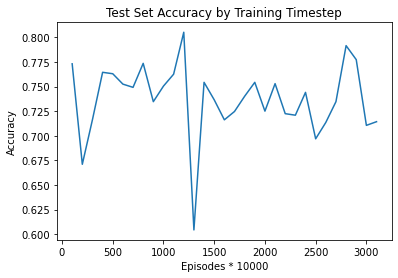

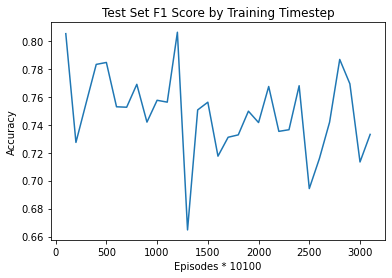

66863
59109  remaining~!
______________Attack Distributions Chosen___________________
{7: 91116, 30: 4204, 33: 17272, 18: 1834, 12: 11579, 11: 1810, 1: 4085, 13: 2230, 17: 7712, 28: 16205, 34: 19978, 38: 2, 6: 2187, 3: 2565, 22: 3042, 15: 6007, 5: 2745, 14: 45326, 4: 48616, 26: 2750, 2: 11201, 35: 1991, 16: 6542}
66946
59026  remaining~!
______________Attack Distributions Chosen___________________
{7: 91369, 30: 4218, 33: 17402, 18: 1835, 12: 11586, 11: 1810, 1: 4085, 13: 2231, 17: 8002, 28: 16308, 34: 19978, 38: 2, 6: 2188, 3: 2565, 22: 3042, 15: 6007, 5: 2746, 14: 45498, 4: 48616, 26: 2750, 2: 11226, 35: 1993, 16: 6542}
67018
58954  remaining~!
______________Attack Distributions Chosen___________________
{7: 91601, 30: 4221, 33: 17595, 18: 1837, 12: 11587, 11: 1810, 1: 4085, 13: 2243, 17: 8036, 28: 16554, 34: 19978, 38: 2, 6: 2188, 3: 2566, 22: 3042, 15: 6007, 5: 2747, 14: 45607, 4: 48617, 26: 2750, 2: 11391, 35: 1993, 16: 6542}
67120
58852  remaining~!
______________Attack Distribut

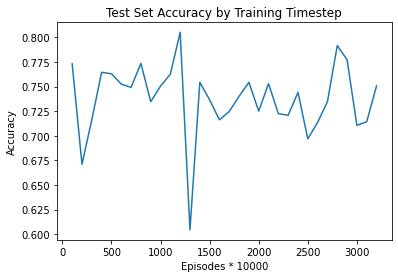

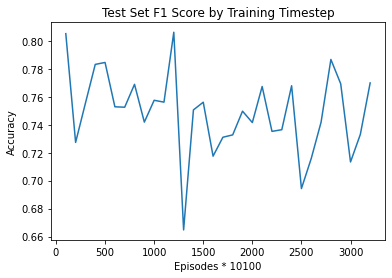

67627
58345  remaining~!
______________Attack Distributions Chosen___________________
{7: 93603, 30: 4251, 33: 18328, 18: 1901, 12: 12019, 11: 1815, 1: 4090, 13: 2296, 17: 8265, 28: 16947, 34: 20714, 38: 2, 6: 2195, 3: 2572, 22: 3046, 15: 6114, 5: 2750, 14: 46387, 4: 50361, 26: 2752, 2: 12045, 35: 1999, 16: 6547}
67713
58259  remaining~!
______________Attack Distributions Chosen___________________
{7: 93717, 30: 4253, 33: 18483, 18: 2015, 12: 12020, 11: 1816, 1: 4091, 13: 2297, 17: 8275, 28: 16957, 34: 20883, 38: 2, 6: 2196, 3: 2574, 22: 3047, 15: 6115, 5: 2751, 14: 46631, 4: 50368, 26: 2752, 2: 12207, 35: 2001, 16: 6548}
67751
58221  remaining~!
______________Attack Distributions Chosen___________________
{7: 93791, 30: 4261, 33: 18485, 18: 2045, 12: 12020, 11: 1818, 1: 4091, 13: 2297, 17: 8276, 28: 16964, 34: 20889, 38: 2, 6: 2196, 3: 2574, 22: 3048, 15: 6116, 5: 2751, 14: 46809, 4: 50606, 26: 2752, 2: 12436, 35: 2001, 16: 6771}
67849
58123  remaining~!
______________Attack Distribut

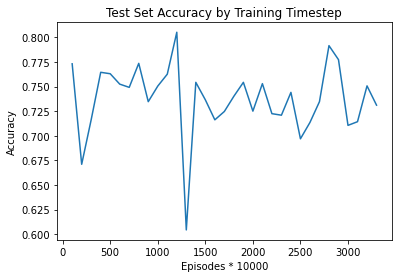

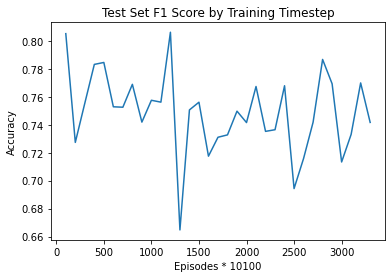

68468
57504  remaining~!
______________Attack Distributions Chosen___________________
{7: 96277, 30: 4286, 33: 18597, 18: 2132, 12: 12101, 11: 1824, 1: 4100, 13: 2305, 17: 8501, 28: 17284, 34: 22579, 38: 2, 6: 2203, 3: 2581, 22: 3533, 15: 6137, 5: 2756, 14: 47699, 4: 52092, 26: 2756, 2: 12474, 35: 2003, 16: 6777}
68578
57394  remaining~!
______________Attack Distributions Chosen___________________
{7: 96741, 30: 4291, 33: 18597, 18: 2133, 12: 12101, 11: 1824, 1: 4101, 13: 2306, 17: 8512, 28: 17284, 34: 22579, 38: 2, 6: 2204, 3: 2582, 22: 3534, 15: 6147, 5: 2756, 14: 47699, 4: 52595, 26: 2757, 2: 12474, 35: 2003, 16: 6777}
68789
57183  remaining~!
______________Attack Distributions Chosen___________________
{7: 97597, 30: 4296, 33: 18597, 18: 2133, 12: 12101, 11: 1824, 1: 4101, 13: 2307, 17: 8513, 28: 17285, 34: 22581, 38: 2, 6: 2206, 3: 2582, 22: 3534, 15: 6277, 5: 2758, 14: 47699, 4: 52595, 26: 2757, 2: 12474, 35: 2003, 16: 6777}
68945
57027  remaining~!
______________Attack Distribut

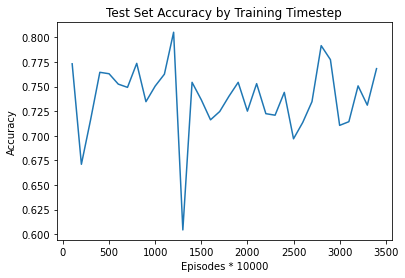

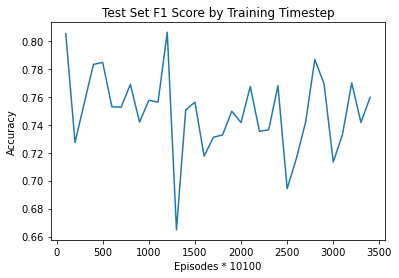

69817
56155  remaining~!
______________Attack Distributions Chosen___________________
{7: 101641, 30: 4314, 33: 18852, 18: 2144, 12: 12106, 11: 1829, 1: 4104, 13: 2410, 17: 8518, 28: 17371, 34: 22605, 38: 2, 6: 2210, 3: 2674, 22: 3611, 15: 6748, 5: 2763, 14: 48844, 4: 53586, 26: 2759, 2: 13030, 35: 2039, 16: 6839}
69916
56056  remaining~!
______________Attack Distributions Chosen___________________
{7: 102073, 30: 4318, 33: 18852, 18: 2145, 12: 12107, 11: 1829, 1: 4104, 13: 2410, 17: 8519, 28: 17371, 34: 22605, 38: 2, 6: 2211, 3: 2674, 22: 3612, 15: 6749, 5: 2764, 14: 49027, 4: 53960, 26: 2759, 2: 13030, 35: 2039, 16: 6839}
69998
55974  remaining~!
______________Attack Distributions Chosen___________________
{7: 102420, 30: 4321, 33: 18852, 18: 2146, 12: 12110, 11: 1829, 1: 4104, 13: 2412, 17: 8520, 28: 17372, 34: 22605, 38: 2, 6: 2213, 3: 2676, 22: 3617, 15: 6752, 5: 2766, 14: 49027, 4: 54586, 26: 2759, 2: 13031, 35: 2039, 16: 6840}
70064
55908  remaining~!
______________Attack Distri

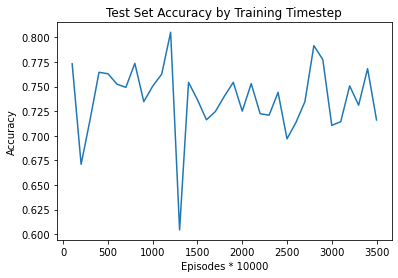

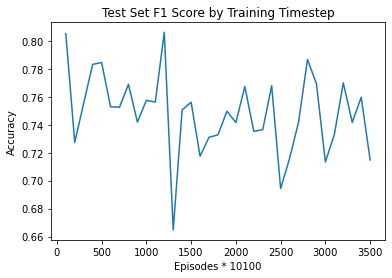

70971
55001  remaining~!
______________Attack Distributions Chosen___________________
{7: 106739, 30: 4344, 33: 19056, 18: 2153, 12: 12187, 11: 1830, 1: 4111, 13: 2503, 17: 8684, 28: 17538, 34: 22614, 38: 2, 6: 2219, 3: 2680, 22: 3930, 15: 7043, 5: 2772, 14: 49953, 4: 55950, 26: 2762, 2: 13038, 35: 2043, 16: 6848}
71065
54907  remaining~!
______________Attack Distributions Chosen___________________
{7: 107146, 30: 4349, 33: 19056, 18: 2155, 12: 12189, 11: 1831, 1: 4112, 13: 2503, 17: 8684, 28: 17539, 34: 22614, 38: 2, 6: 2219, 3: 2681, 22: 3930, 15: 7044, 5: 2772, 14: 49953, 4: 56528, 26: 2762, 2: 13038, 35: 2044, 16: 6848}
71129
54843  remaining~!
______________Attack Distributions Chosen___________________
{7: 107406, 30: 4351, 33: 19056, 18: 2158, 12: 12189, 11: 1831, 1: 4112, 13: 2505, 17: 8684, 28: 17793, 34: 22614, 38: 2, 6: 2220, 3: 2681, 22: 3931, 15: 7107, 5: 2772, 14: 49953, 4: 56940, 26: 2762, 2: 13040, 35: 2044, 16: 6848}
71212
54760  remaining~!
______________Attack Distri

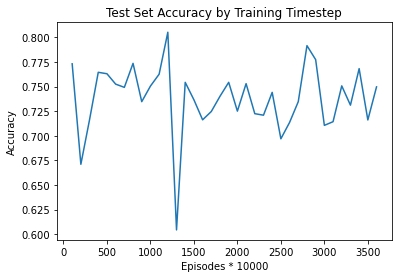

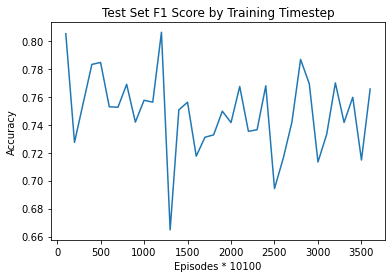

71846
54126  remaining~!
______________Attack Distributions Chosen___________________
{7: 110853, 30: 4376, 33: 19071, 18: 2168, 12: 12193, 11: 1834, 1: 4140, 13: 2509, 17: 8737, 28: 18412, 34: 22619, 38: 2, 6: 2224, 3: 2686, 22: 4107, 15: 7140, 5: 2777, 14: 51142, 4: 59293, 26: 2765, 2: 13048, 35: 2053, 16: 6850}
71946
54026  remaining~!
______________Attack Distributions Chosen___________________
{7: 111280, 30: 4381, 33: 19071, 18: 2168, 12: 12193, 11: 1836, 1: 4140, 13: 2510, 17: 8738, 28: 18412, 34: 22619, 38: 2, 6: 2225, 3: 2686, 22: 4107, 15: 7144, 5: 2777, 14: 51143, 4: 59849, 26: 2766, 2: 13048, 35: 2054, 16: 6850}
72009
53963  remaining~!
______________Attack Distributions Chosen___________________
{7: 111631, 30: 4385, 33: 19072, 18: 2170, 12: 12194, 11: 1836, 1: 4142, 13: 2511, 17: 8738, 28: 18540, 34: 22619, 38: 2, 6: 2226, 3: 2686, 22: 4108, 15: 7506, 5: 2777, 14: 51143, 4: 59994, 26: 2767, 2: 13048, 35: 2054, 16: 6850}
72049
53923  remaining~!
______________Attack Distri

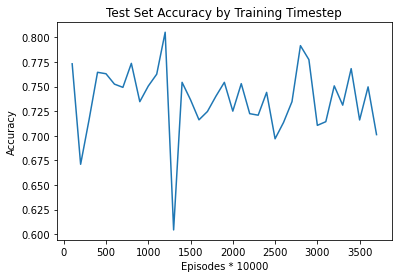

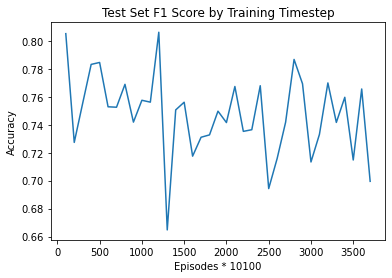

72622
53350  remaining~!
______________Attack Distributions Chosen___________________
{7: 114646, 30: 4411, 33: 19073, 18: 2185, 12: 12199, 11: 1839, 1: 4254, 13: 2517, 17: 8815, 28: 19068, 34: 22845, 38: 2, 6: 2229, 3: 2930, 22: 4292, 15: 7593, 5: 2779, 14: 52810, 4: 61508, 26: 2773, 2: 13269, 35: 2106, 16: 6856}
72797
53175  remaining~!
______________Attack Distributions Chosen___________________
{7: 115054, 30: 4412, 33: 19073, 18: 2381, 12: 12199, 11: 1839, 1: 4254, 13: 2518, 17: 8817, 28: 19069, 34: 22903, 38: 2, 6: 2229, 3: 2931, 22: 4292, 15: 7596, 5: 2779, 14: 52993, 4: 61632, 26: 2795, 2: 13269, 35: 2106, 16: 6856}
72811
53161  remaining~!
______________Attack Distributions Chosen___________________
{7: 115084, 30: 4417, 33: 19075, 18: 2382, 12: 12199, 11: 1839, 1: 4254, 13: 2519, 17: 8875, 28: 19083, 34: 23296, 38: 2, 6: 2229, 3: 2931, 22: 4351, 15: 7596, 5: 2779, 14: 53313, 4: 61746, 26: 2798, 2: 13269, 35: 2106, 16: 6856}
72813
53159  remaining~!
______________Attack Distri

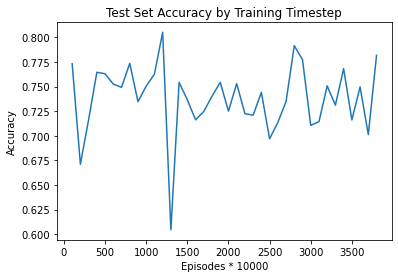

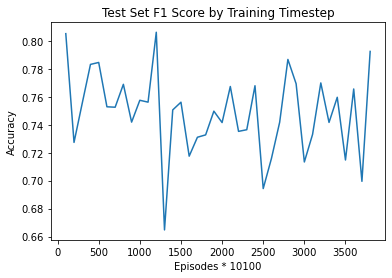

73228
52744  remaining~!
______________Attack Distributions Chosen___________________
{7: 117408, 30: 4436, 33: 19441, 18: 2393, 12: 12207, 11: 1842, 1: 4258, 13: 2522, 17: 8902, 28: 20644, 34: 23538, 38: 2, 6: 2234, 3: 3125, 22: 4481, 15: 7601, 5: 2788, 14: 55375, 4: 62718, 26: 2799, 2: 13270, 35: 2111, 16: 6904}
73234
52738  remaining~!
______________Attack Distributions Chosen___________________
{7: 117410, 30: 4441, 33: 19443, 18: 2393, 12: 12207, 11: 1842, 1: 4259, 13: 2523, 17: 8903, 28: 21486, 34: 23538, 38: 2, 6: 2235, 3: 3128, 22: 4481, 15: 7601, 5: 2788, 14: 55516, 4: 62718, 26: 2799, 2: 13270, 35: 2111, 16: 6905}
73278
52694  remaining~!
______________Attack Distributions Chosen___________________
{7: 117672, 30: 4443, 33: 19452, 18: 2393, 12: 12247, 11: 1843, 1: 4259, 13: 2524, 17: 8993, 28: 21722, 34: 23538, 38: 2, 6: 2236, 3: 3129, 22: 4481, 15: 7636, 5: 2788, 14: 55520, 4: 62974, 26: 2799, 2: 13271, 35: 2112, 16: 6965}
73343
52629  remaining~!
______________Attack Distri

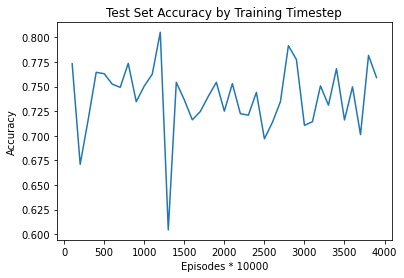

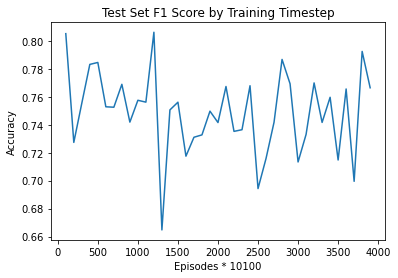

73684
52288  remaining~!
______________Attack Distributions Chosen___________________
{7: 119905, 30: 4470, 33: 20369, 18: 2396, 12: 12601, 11: 1852, 1: 4275, 13: 2530, 17: 9512, 28: 22144, 34: 23762, 38: 2, 6: 2483, 3: 3130, 22: 4488, 15: 7722, 5: 2790, 14: 56426, 4: 64645, 26: 2803, 2: 13282, 35: 2116, 16: 7296}
73741
52231  remaining~!
______________Attack Distributions Chosen___________________
{7: 120182, 30: 4474, 33: 20384, 18: 2397, 12: 12601, 11: 1852, 1: 4275, 13: 2531, 17: 9512, 28: 22145, 34: 23876, 38: 2, 6: 2489, 3: 3207, 22: 4585, 15: 7786, 5: 2795, 14: 56667, 4: 64732, 26: 2803, 2: 13290, 35: 2116, 16: 7298}
73839
52133  remaining~!
______________Attack Distributions Chosen___________________
{7: 120737, 30: 4478, 33: 20385, 18: 2400, 12: 12602, 11: 1852, 1: 4276, 13: 2533, 17: 9512, 28: 22146, 34: 23877, 38: 2, 6: 2489, 3: 3208, 22: 4585, 15: 7828, 5: 2795, 14: 57033, 4: 64734, 26: 2803, 2: 13290, 35: 2116, 16: 7318}
73924
52048  remaining~!
______________Attack Distri

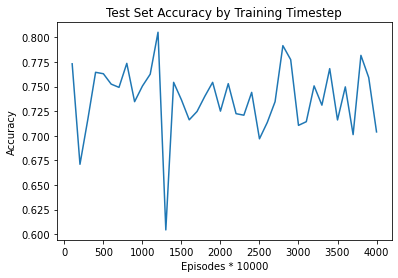

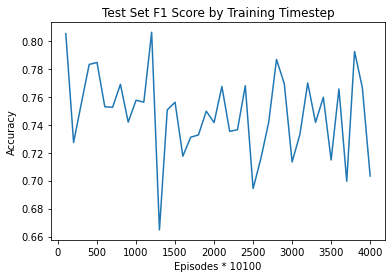

74232
51740  remaining~!
______________Attack Distributions Chosen___________________
{7: 123081, 30: 4510, 33: 21410, 18: 2405, 12: 12606, 11: 1855, 1: 4285, 13: 2539, 17: 9610, 28: 22277, 34: 24137, 38: 2, 6: 2498, 3: 3211, 22: 4591, 15: 8601, 5: 2800, 14: 58908, 4: 64962, 26: 3131, 2: 14017, 35: 2119, 16: 7444}
74302
51670  remaining~!
______________Attack Distributions Chosen___________________
{7: 123441, 30: 4514, 33: 21410, 18: 2409, 12: 12609, 11: 1855, 1: 4286, 13: 2540, 17: 9647, 28: 22277, 34: 24203, 38: 2, 6: 2498, 3: 3212, 22: 4592, 15: 8792, 5: 2801, 14: 59207, 4: 64989, 26: 3133, 2: 14018, 35: 2119, 16: 7445}
74369
51603  remaining~!
______________Attack Distributions Chosen___________________
{7: 123854, 30: 4516, 33: 21427, 18: 2409, 12: 12609, 11: 1855, 1: 4287, 13: 2543, 17: 9649, 28: 22278, 34: 24203, 38: 2, 6: 2498, 3: 3214, 22: 4592, 15: 8809, 5: 2801, 14: 59422, 4: 65042, 26: 3133, 2: 14266, 35: 2145, 16: 7445}
74417
51555  remaining~!
______________Attack Distri

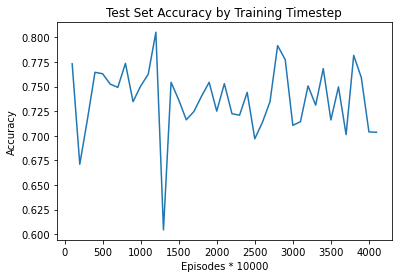

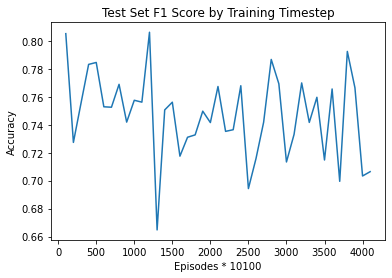

74839
51133  remaining~!
______________Attack Distributions Chosen___________________
{7: 126049, 30: 4552, 33: 23040, 18: 2420, 12: 12613, 11: 1863, 1: 4292, 13: 2717, 17: 9664, 28: 22766, 34: 24439, 38: 2, 6: 2503, 3: 3227, 22: 4775, 15: 9229, 5: 2840, 14: 60156, 4: 66018, 26: 3140, 2: 14505, 35: 2177, 16: 8012}
74933
51039  remaining~!
______________Attack Distributions Chosen___________________
{7: 126656, 30: 4555, 33: 23042, 18: 2421, 12: 12615, 11: 1863, 1: 4292, 13: 2717, 17: 9665, 28: 22766, 34: 24439, 38: 2, 6: 2505, 3: 3227, 22: 4775, 15: 9230, 5: 2842, 14: 60256, 4: 66148, 26: 3142, 2: 14618, 35: 2177, 16: 8046}
74976
50996  remaining~!
______________Attack Distributions Chosen___________________
{7: 126940, 30: 4556, 33: 23042, 18: 2421, 12: 12615, 11: 1863, 1: 4293, 13: 2717, 17: 9665, 28: 22767, 34: 24439, 38: 2, 6: 2506, 3: 3227, 22: 4775, 15: 9231, 5: 2842, 14: 60291, 4: 66551, 26: 3142, 2: 14867, 35: 2177, 16: 8070}
75041
50931  remaining~!
______________Attack Distri

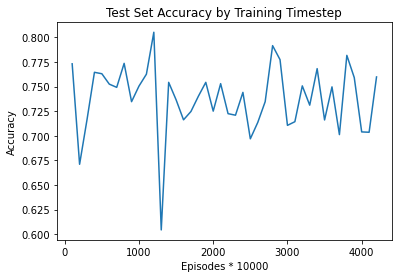

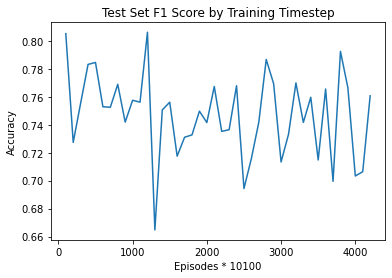

75440
50532  remaining~!
______________Attack Distributions Chosen___________________
{7: 129811, 30: 4581, 33: 24227, 18: 2426, 12: 12622, 11: 1869, 1: 4297, 13: 2726, 17: 9813, 28: 22774, 34: 25037, 38: 2, 6: 2511, 3: 3475, 22: 4779, 15: 9337, 5: 2844, 14: 61262, 4: 67580, 26: 3148, 2: 15193, 35: 2177, 16: 8508}
75497
50475  remaining~!
______________Attack Distributions Chosen___________________
{7: 130222, 30: 4585, 33: 24440, 18: 2427, 12: 12624, 11: 1869, 1: 4299, 13: 2727, 17: 9814, 28: 22774, 34: 25037, 38: 2, 6: 2525, 3: 3475, 22: 4779, 15: 9337, 5: 2844, 14: 61399, 4: 67783, 26: 3148, 2: 15203, 35: 2178, 16: 8508}
75547
50425  remaining~!
______________Attack Distributions Chosen___________________
{7: 130514, 30: 4588, 33: 24482, 18: 2427, 12: 12625, 11: 1870, 1: 4299, 13: 2727, 17: 9820, 28: 22774, 34: 25038, 38: 2, 6: 2572, 3: 3479, 22: 4780, 15: 9382, 5: 2846, 14: 61442, 4: 68018, 26: 3149, 2: 15205, 35: 2254, 16: 8706}
75608
50364  remaining~!
______________Attack Distri

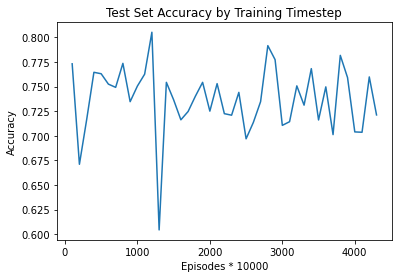

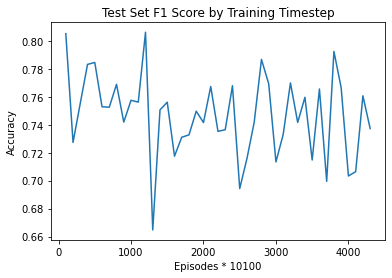

75927
50045  remaining~!
______________Attack Distributions Chosen___________________
{7: 132913, 30: 4614, 33: 26534, 18: 2441, 12: 12632, 11: 1876, 1: 4306, 13: 2733, 17: 10367, 28: 22898, 34: 25078, 38: 2, 6: 2573, 3: 3642, 22: 4784, 15: 9604, 5: 2848, 14: 62470, 4: 68918, 26: 3263, 2: 15275, 35: 2256, 16: 8972}
76013
49959  remaining~!
______________Attack Distributions Chosen___________________
{7: 133416, 30: 4618, 33: 26557, 18: 2441, 12: 12633, 11: 1877, 1: 4306, 13: 2733, 17: 10367, 28: 22927, 34: 25085, 38: 2, 6: 2573, 3: 3642, 22: 4784, 15: 9610, 5: 2850, 14: 62846, 4: 68945, 26: 3264, 2: 15288, 35: 2258, 16: 8977}
76087
49885  remaining~!
______________Attack Distributions Chosen___________________
{7: 133829, 30: 4623, 33: 26563, 18: 2442, 12: 12633, 11: 1879, 1: 4308, 13: 2736, 17: 10368, 28: 22974, 34: 25086, 38: 2, 6: 2575, 3: 3643, 22: 4784, 15: 9670, 5: 2851, 14: 63034, 4: 69133, 26: 3264, 2: 15338, 35: 2259, 16: 9005}
76109
49863  remaining~!
______________Attack Dis

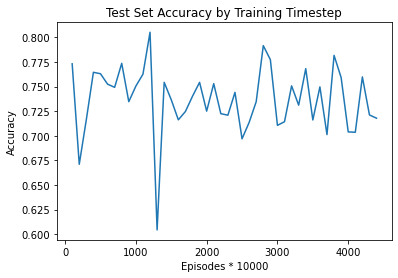

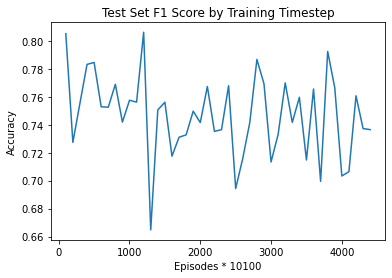

76749
49223  remaining~!
______________Attack Distributions Chosen___________________
{7: 136100, 30: 5026, 33: 27442, 18: 2455, 12: 12640, 11: 1884, 1: 4316, 13: 2740, 17: 10373, 28: 23044, 34: 25208, 38: 2, 6: 2592, 3: 4686, 22: 4789, 15: 10336, 5: 2855, 14: 63839, 4: 70571, 26: 3269, 2: 15532, 35: 2262, 16: 9038}
76824
49148  remaining~!
______________Attack Distributions Chosen___________________
{7: 136523, 30: 5052, 33: 27443, 18: 2455, 12: 12640, 11: 1885, 1: 4317, 13: 2742, 17: 10373, 28: 23044, 34: 25208, 38: 2, 6: 2593, 3: 4908, 22: 4789, 15: 10336, 5: 2855, 14: 63839, 4: 70892, 26: 3270, 2: 15532, 35: 2262, 16: 9039}
76880
49092  remaining~!
______________Attack Distributions Chosen___________________
{7: 136768, 30: 5074, 33: 27474, 18: 2457, 12: 12642, 11: 1885, 1: 4317, 13: 2744, 17: 10374, 28: 23045, 34: 25208, 38: 2, 6: 2594, 3: 5112, 22: 4790, 15: 10511, 5: 2857, 14: 63857, 4: 71174, 26: 3270, 2: 15532, 35: 2262, 16: 9050}
77072
48900  remaining~!
______________Attack 

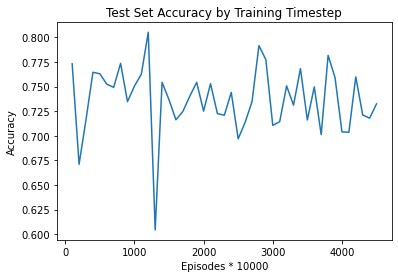

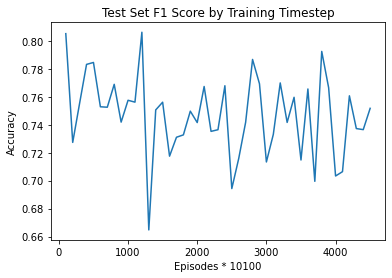

77632
48340  remaining~!
______________Attack Distributions Chosen___________________
{7: 140030, 30: 5380, 33: 27566, 18: 2546, 12: 12755, 11: 1892, 1: 4323, 13: 2751, 17: 10381, 28: 23520, 34: 25213, 38: 2, 6: 2596, 3: 5877, 22: 4797, 15: 10677, 5: 2861, 14: 64352, 4: 73189, 26: 3275, 2: 15541, 35: 2268, 16: 9207}
77708
48264  remaining~!
______________Attack Distributions Chosen___________________
{7: 140479, 30: 5400, 33: 27697, 18: 2546, 12: 12756, 11: 1892, 1: 4323, 13: 2752, 17: 10405, 28: 23520, 34: 25213, 38: 2, 6: 2597, 3: 5893, 22: 4797, 15: 10677, 5: 2862, 14: 64353, 4: 73525, 26: 3275, 2: 15544, 35: 2268, 16: 9223}
77764
48208  remaining~!
______________Attack Distributions Chosen___________________
{7: 140930, 30: 5401, 33: 27723, 18: 2547, 12: 12756, 11: 1892, 1: 4323, 13: 2753, 17: 10480, 28: 23520, 34: 25214, 38: 2, 6: 2597, 3: 6034, 22: 4797, 15: 10677, 5: 2862, 14: 64397, 4: 73766, 26: 3275, 2: 15545, 35: 2268, 16: 9240}
77811
48161  remaining~!
______________Attack 

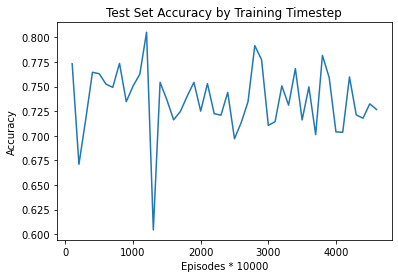

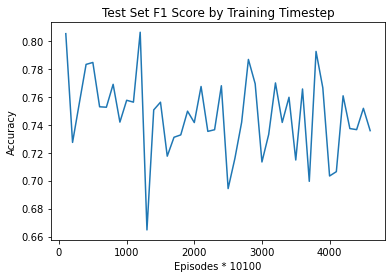

78194
47778  remaining~!
______________Attack Distributions Chosen___________________
{7: 143611, 30: 5507, 33: 27911, 18: 2554, 12: 12763, 11: 1896, 1: 4334, 13: 2759, 17: 10662, 28: 23638, 34: 26533, 38: 2, 6: 2601, 3: 6437, 22: 4802, 15: 10835, 5: 2871, 14: 65487, 4: 75130, 26: 3279, 2: 15547, 35: 2271, 16: 9569}
78264
47708  remaining~!
______________Attack Distributions Chosen___________________
{7: 144134, 30: 5508, 33: 27911, 18: 2557, 12: 12763, 11: 1896, 1: 4334, 13: 2759, 17: 10681, 28: 23678, 34: 26533, 38: 2, 6: 2601, 3: 6520, 22: 4803, 15: 10835, 5: 2872, 14: 65497, 4: 75445, 26: 3281, 2: 15547, 35: 2271, 16: 9571}
78303
47669  remaining~!
______________Attack Distributions Chosen___________________
{7: 144420, 30: 5510, 33: 27911, 18: 2557, 12: 12763, 11: 1897, 1: 4349, 13: 2760, 17: 10707, 28: 24041, 34: 26542, 38: 2, 6: 2602, 3: 6596, 22: 4804, 15: 10835, 5: 2872, 14: 65555, 4: 75603, 26: 3282, 2: 15548, 35: 2272, 16: 9571}
78349
47623  remaining~!
______________Attack 

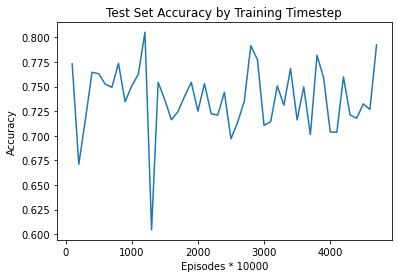

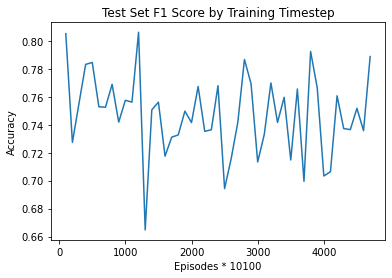

78704
47268  remaining~!
______________Attack Distributions Chosen___________________
{7: 147297, 30: 5534, 33: 27914, 18: 2562, 12: 12780, 11: 1904, 1: 4433, 13: 2767, 17: 10766, 28: 24519, 34: 27363, 38: 2, 6: 2607, 3: 7026, 22: 4806, 15: 11167, 5: 2876, 14: 65999, 4: 77974, 26: 3287, 2: 15553, 35: 2287, 16: 9576}
78740
47232  remaining~!
______________Attack Distributions Chosen___________________
{7: 147579, 30: 5539, 33: 27915, 18: 2562, 12: 12780, 11: 1904, 1: 4433, 13: 2767, 17: 10767, 28: 24519, 34: 27380, 38: 2, 6: 2607, 3: 7026, 22: 4806, 15: 11570, 5: 2877, 14: 66109, 4: 78149, 26: 3287, 2: 15555, 35: 2289, 16: 9577}
78799
47173  remaining~!
______________Attack Distributions Chosen___________________
{7: 148050, 30: 5542, 33: 27916, 18: 2563, 12: 12780, 11: 1904, 1: 4434, 13: 2768, 17: 10767, 28: 24519, 34: 27671, 38: 2, 6: 2608, 3: 7026, 22: 4806, 15: 11599, 5: 2877, 14: 66180, 4: 78276, 26: 3289, 2: 15556, 35: 2289, 16: 9577}
78862
47110  remaining~!
______________Attack 

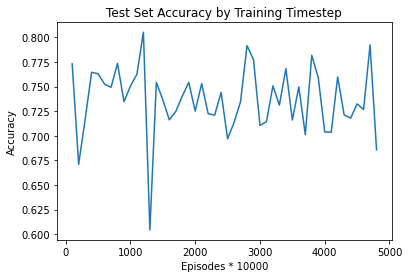

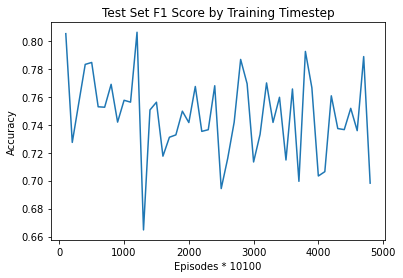

79358
46614  remaining~!
______________Attack Distributions Chosen___________________
{7: 152902, 30: 5568, 33: 27919, 18: 2574, 12: 12789, 11: 1910, 1: 4464, 13: 2774, 17: 10770, 28: 24521, 34: 28181, 38: 2, 6: 2609, 3: 7114, 22: 4808, 15: 11763, 5: 2881, 14: 67264, 4: 78955, 26: 3289, 2: 16069, 35: 2293, 16: 9580}
79429
46543  remaining~!
______________Attack Distributions Chosen___________________
{7: 153449, 30: 5575, 33: 27920, 18: 2575, 12: 12792, 11: 1912, 1: 4506, 13: 2776, 17: 10771, 28: 24523, 34: 28181, 38: 2, 6: 2610, 3: 7117, 22: 4809, 15: 11763, 5: 2882, 14: 67287, 4: 79061, 26: 3289, 2: 16326, 35: 2293, 16: 9580}
79498
46474  remaining~!
______________Attack Distributions Chosen___________________
{7: 154105, 30: 5580, 33: 27920, 18: 2575, 12: 12792, 11: 1913, 1: 4523, 13: 2776, 17: 10772, 28: 24524, 34: 28182, 38: 2, 6: 2611, 3: 7125, 22: 4809, 15: 11763, 5: 2885, 14: 67312, 4: 79147, 26: 3290, 2: 16520, 35: 2293, 16: 9580}
79543
46429  remaining~!
______________Attack 

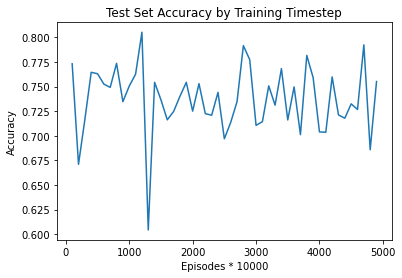

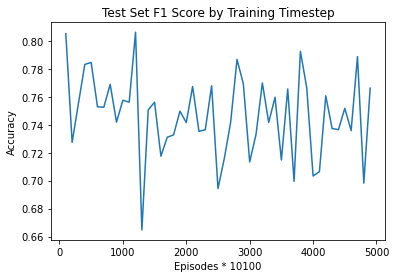

79905
46067  remaining~!
______________Attack Distributions Chosen___________________
{7: 158012, 30: 5606, 33: 27928, 18: 2583, 12: 12795, 11: 1919, 1: 4579, 13: 2781, 17: 10778, 28: 24536, 34: 28571, 38: 2, 6: 2666, 3: 7679, 22: 4812, 15: 12031, 5: 2889, 14: 67521, 4: 80772, 26: 3402, 2: 16799, 35: 2366, 16: 9972}
79952
46020  remaining~!
______________Attack Distributions Chosen___________________
{7: 158445, 30: 5611, 33: 27928, 18: 2585, 12: 12796, 11: 1920, 1: 4579, 13: 2825, 17: 10778, 28: 24536, 34: 28621, 38: 2, 6: 2686, 3: 7679, 22: 4814, 15: 12080, 5: 2889, 14: 67888, 4: 80772, 26: 3402, 2: 16821, 35: 2368, 16: 9974}
80005
45967  remaining~!
______________Attack Distributions Chosen___________________
{7: 158974, 30: 5614, 33: 27928, 18: 2588, 12: 12797, 11: 1920, 1: 4579, 13: 2825, 17: 10779, 28: 24536, 34: 28680, 38: 2, 6: 2686, 3: 7680, 22: 4814, 15: 12080, 5: 2890, 14: 68066, 4: 80988, 26: 3402, 2: 16827, 35: 2369, 16: 9975}
80014
45958  remaining~!
______________Attack 

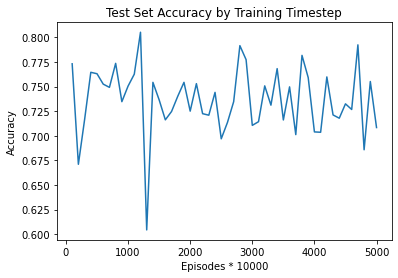

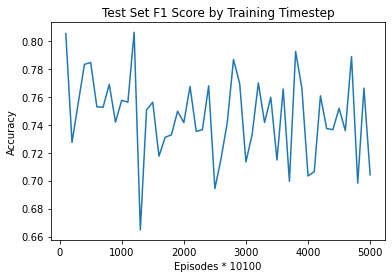

80258
45714  remaining~!
______________Attack Distributions Chosen___________________
{7: 161249, 30: 5645, 33: 27932, 18: 2593, 12: 12900, 11: 1926, 1: 4669, 13: 2833, 17: 10825, 28: 24750, 34: 30684, 38: 2, 6: 2913, 3: 7684, 22: 4862, 15: 12202, 5: 2892, 14: 68625, 4: 82979, 26: 3406, 2: 16830, 35: 2416, 16: 10182}
80305
45667  remaining~!
______________Attack Distributions Chosen___________________
{7: 161658, 30: 5652, 33: 27950, 18: 2596, 12: 12900, 11: 1926, 1: 4670, 13: 2836, 17: 10826, 28: 24774, 34: 30684, 38: 2, 6: 2914, 3: 7736, 22: 4876, 15: 12202, 5: 2893, 14: 68955, 4: 83114, 26: 3406, 2: 16830, 35: 2416, 16: 10183}
80344
45628  remaining~!
______________Attack Distributions Chosen___________________
{7: 162071, 30: 5654, 33: 27951, 18: 2596, 12: 12901, 11: 1927, 1: 4671, 13: 2836, 17: 10826, 28: 24782, 34: 30817, 38: 2, 6: 2946, 3: 7810, 22: 4885, 15: 12222, 5: 2893, 14: 69156, 4: 83217, 26: 3406, 2: 16830, 35: 2416, 16: 10184}
80385
45587  remaining~!
______________Atta

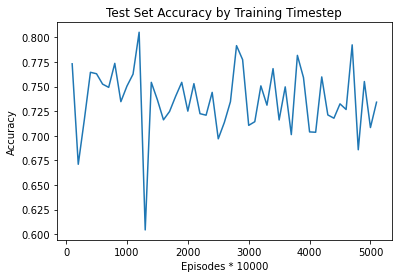

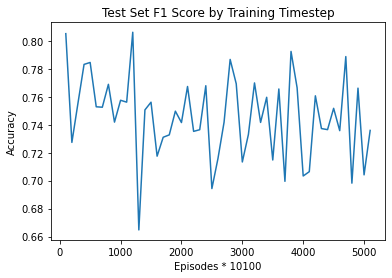

80603
45369  remaining~!
______________Attack Distributions Chosen___________________
{7: 164852, 30: 5673, 33: 27954, 18: 2600, 12: 12909, 11: 1940, 1: 4674, 13: 2841, 17: 10831, 28: 26965, 34: 30845, 38: 2, 6: 3082, 3: 7957, 22: 4890, 15: 12317, 5: 2899, 14: 71696, 4: 83220, 26: 3411, 2: 16837, 35: 2420, 16: 10184}
80633
45339  remaining~!
______________Attack Distributions Chosen___________________
{7: 165180, 30: 5674, 33: 27954, 18: 2600, 12: 12909, 11: 1941, 1: 4675, 13: 2842, 17: 10832, 28: 27246, 34: 30851, 38: 2, 6: 3122, 3: 8042, 22: 4891, 15: 12321, 5: 2899, 14: 71944, 4: 83220, 26: 3412, 2: 16838, 35: 2420, 16: 10184}
80644
45328  remaining~!
______________Attack Distributions Chosen___________________
{7: 165323, 30: 5675, 33: 27954, 18: 2600, 12: 12912, 11: 1941, 1: 4677, 13: 2843, 17: 10832, 28: 27729, 34: 30853, 38: 2, 6: 3131, 3: 8387, 22: 4892, 15: 12326, 5: 2900, 14: 71944, 4: 83221, 26: 3412, 2: 16838, 35: 2421, 16: 10186}
80647
45325  remaining~!
______________Atta

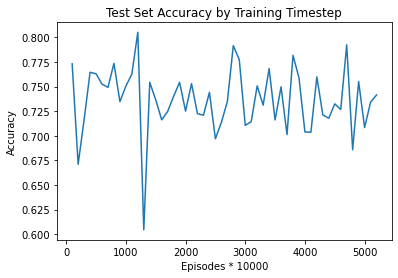

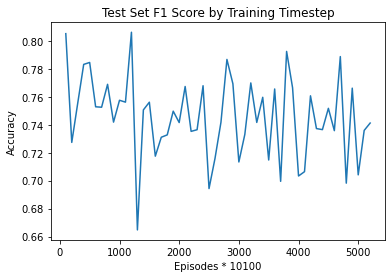

80833
45139  remaining~!
______________Attack Distributions Chosen___________________
{7: 167233, 30: 5701, 33: 28015, 18: 2606, 12: 12919, 11: 1945, 1: 4677, 13: 2846, 17: 10836, 28: 28574, 34: 31455, 38: 2, 6: 3232, 3: 9066, 22: 4900, 15: 12933, 5: 2904, 14: 73842, 4: 84426, 26: 3419, 2: 16850, 35: 2426, 16: 10192}
80849
45123  remaining~!
______________Attack Distributions Chosen___________________
{7: 167351, 30: 5706, 33: 28309, 18: 2608, 12: 12920, 11: 1945, 1: 4677, 13: 2847, 17: 10837, 28: 28578, 34: 31741, 38: 2, 6: 3306, 3: 9177, 22: 4900, 15: 12933, 5: 2904, 14: 73945, 4: 84426, 26: 3419, 2: 16850, 35: 2426, 16: 10192}
80859
45113  remaining~!
______________Attack Distributions Chosen___________________
{7: 167431, 30: 5708, 33: 29083, 18: 2608, 12: 12921, 11: 1946, 1: 4677, 13: 2850, 17: 10838, 28: 28579, 34: 31741, 38: 2, 6: 3330, 3: 9178, 22: 4932, 15: 12933, 5: 2905, 14: 74022, 4: 84427, 26: 3420, 2: 16850, 35: 2426, 16: 10192}
80884
45088  remaining~!
______________Atta

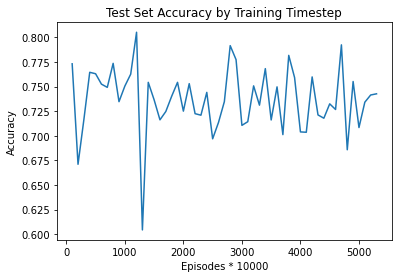

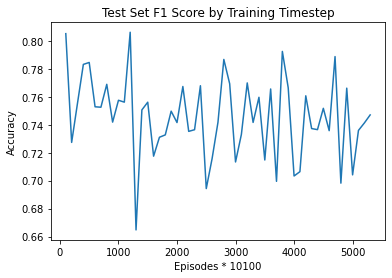

81042
44930  remaining~!
______________Attack Distributions Chosen___________________
{7: 169384, 30: 5733, 33: 31436, 18: 2611, 12: 12924, 11: 1952, 1: 4680, 13: 2858, 17: 10842, 28: 28597, 34: 33065, 38: 2, 6: 3668, 3: 9613, 22: 4991, 15: 13279, 5: 2911, 14: 74574, 4: 84976, 26: 3423, 2: 16852, 35: 2434, 16: 10194}
81081
44891  remaining~!
______________Attack Distributions Chosen___________________
{7: 169870, 30: 5737, 33: 31464, 18: 2612, 12: 12924, 11: 1952, 1: 4681, 13: 2858, 17: 10842, 28: 28597, 34: 33065, 38: 2, 6: 3668, 3: 9615, 22: 4992, 15: 13279, 5: 2912, 14: 75042, 4: 84976, 26: 3425, 2: 16856, 35: 2436, 16: 10194}
81126
44846  remaining~!
______________Attack Distributions Chosen___________________
{7: 170304, 30: 5739, 33: 31686, 18: 2612, 12: 12926, 11: 1953, 1: 4681, 13: 2858, 17: 10842, 28: 28597, 34: 33075, 38: 2, 6: 3669, 3: 9615, 22: 4992, 15: 13279, 5: 2914, 14: 75363, 4: 84977, 26: 3426, 2: 16856, 35: 2437, 16: 10196}
81133
44839  remaining~!
______________Atta

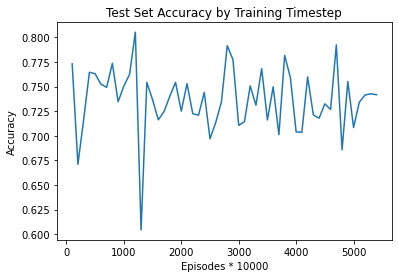

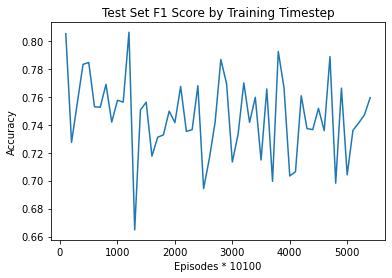

81208
44764  remaining~!
______________Attack Distributions Chosen___________________
{7: 170995, 30: 5762, 33: 34536, 18: 2618, 12: 12936, 11: 1964, 1: 4684, 13: 2861, 17: 10848, 28: 28654, 34: 33571, 38: 2, 6: 3671, 3: 9622, 22: 4997, 15: 13533, 5: 2918, 14: 76700, 4: 85428, 26: 3432, 2: 16858, 35: 2439, 16: 11970}
81216
44756  remaining~!
______________Attack Distributions Chosen___________________
{7: 171060, 30: 5763, 33: 34760, 18: 2619, 12: 12937, 11: 1967, 1: 4684, 13: 2862, 17: 10851, 28: 28684, 34: 33571, 38: 2, 6: 3671, 3: 9623, 22: 4997, 15: 13724, 5: 2919, 14: 76717, 4: 85428, 26: 3432, 2: 16858, 35: 2439, 16: 12431}
81250
44722  remaining~!
______________Attack Distributions Chosen___________________
{7: 171447, 30: 5768, 33: 34906, 18: 2620, 12: 12937, 11: 1967, 1: 4684, 13: 2864, 17: 10851, 28: 28684, 34: 33573, 38: 2, 6: 3672, 3: 9625, 22: 4997, 15: 13726, 5: 2919, 14: 76864, 4: 85429, 26: 3432, 2: 16858, 35: 2439, 16: 12735}
81276
44696  remaining~!
______________Atta

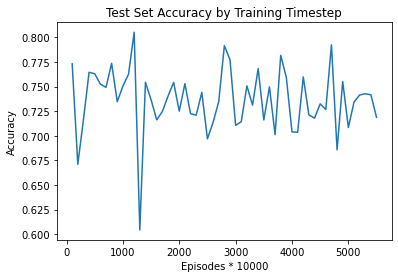

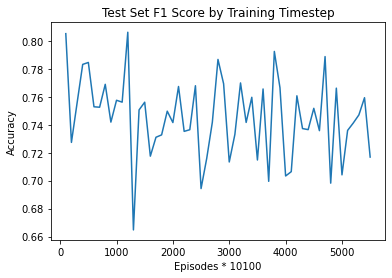

81437
44535  remaining~!
______________Attack Distributions Chosen___________________
{7: 173852, 30: 5792, 33: 36642, 18: 2624, 12: 12943, 11: 1970, 1: 4691, 13: 2869, 17: 10856, 28: 29443, 34: 33579, 38: 2, 6: 3675, 3: 9730, 22: 5225, 15: 13730, 5: 3154, 14: 79138, 4: 85434, 26: 3437, 2: 16863, 35: 2440, 16: 12910}
81466
44506  remaining~!
______________Attack Distributions Chosen___________________
{7: 174241, 30: 5795, 33: 36642, 18: 2624, 12: 12945, 11: 1970, 1: 4691, 13: 2869, 17: 10858, 28: 29523, 34: 33581, 38: 2, 6: 3675, 3: 9731, 22: 5451, 15: 13731, 5: 3155, 14: 79398, 4: 85434, 26: 3437, 2: 16863, 35: 2440, 16: 12943}
81500
44472  remaining~!
______________Attack Distributions Chosen___________________
{7: 174670, 30: 5796, 33: 36670, 18: 2624, 12: 12945, 11: 1972, 1: 4691, 13: 2869, 17: 10858, 28: 29524, 34: 33581, 38: 2, 6: 3676, 3: 9731, 22: 5465, 15: 13838, 5: 3155, 14: 79411, 4: 85435, 26: 3437, 2: 16865, 35: 2440, 16: 13344}
81520
44452  remaining~!
______________Atta

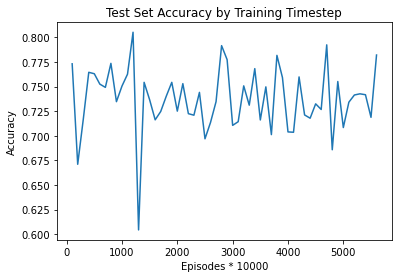

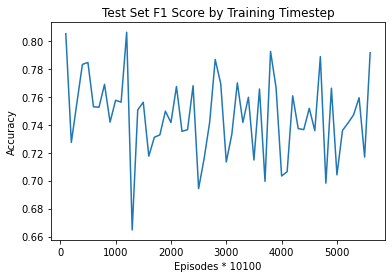

81659
44313  remaining~!
______________Attack Distributions Chosen___________________
{7: 176797, 30: 5813, 33: 37471, 18: 2631, 12: 12948, 11: 1976, 1: 4700, 13: 2874, 17: 10866, 28: 29528, 34: 34036, 38: 2, 6: 3679, 3: 9768, 22: 5810, 15: 14225, 5: 3159, 14: 80419, 4: 85438, 26: 3443, 2: 16872, 35: 2867, 16: 15677}
81672
44300  remaining~!
______________Attack Distributions Chosen___________________
{7: 176957, 30: 5815, 33: 37825, 18: 2632, 12: 12950, 11: 1976, 1: 4701, 13: 2875, 17: 10867, 28: 29529, 34: 34036, 38: 2, 6: 3679, 3: 9769, 22: 5817, 15: 14432, 5: 3159, 14: 80679, 4: 85438, 26: 3445, 2: 16872, 35: 2867, 16: 15677}
81717
44255  remaining~!
______________Attack Distributions Chosen___________________
{7: 177406, 30: 5821, 33: 37835, 18: 2632, 12: 12951, 11: 1978, 1: 4701, 13: 2879, 17: 10869, 28: 29529, 34: 34036, 38: 2, 6: 3679, 3: 9769, 22: 5943, 15: 14433, 5: 3159, 14: 81073, 4: 85439, 26: 3446, 2: 16874, 35: 2867, 16: 15678}
81742
44230  remaining~!
______________Atta

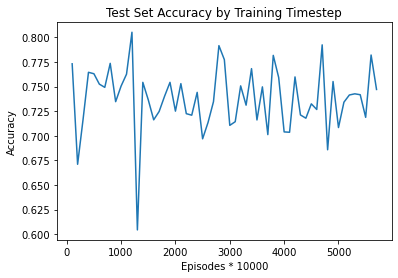

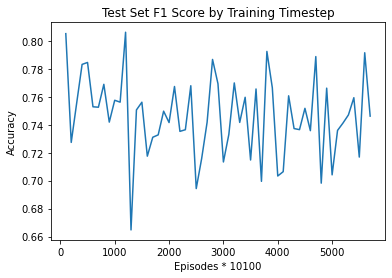

81929
44043  remaining~!
______________Attack Distributions Chosen___________________
{7: 179901, 30: 5851, 33: 38887, 18: 2637, 12: 12953, 11: 1985, 1: 4708, 13: 2883, 17: 10876, 28: 29534, 34: 35211, 38: 2, 6: 3682, 3: 9773, 22: 6136, 15: 14439, 5: 3164, 14: 82604, 4: 85625, 26: 3453, 2: 16989, 35: 3300, 16: 16406}
81978
43994  remaining~!
______________Attack Distributions Chosen___________________
{7: 180554, 30: 5854, 33: 38889, 18: 2639, 12: 12954, 11: 1986, 1: 4708, 13: 2883, 17: 10879, 28: 29534, 34: 35211, 38: 2, 6: 3682, 3: 9773, 22: 6137, 15: 14440, 5: 3164, 14: 82605, 4: 85955, 26: 3453, 2: 16989, 35: 3300, 16: 16408}
82015
43957  remaining~!
______________Attack Distributions Chosen___________________
{7: 181098, 30: 5856, 33: 38889, 18: 2639, 12: 12956, 11: 1986, 1: 4708, 13: 2885, 17: 10879, 28: 29534, 34: 35213, 38: 2, 6: 3683, 3: 9774, 22: 6137, 15: 14442, 5: 3165, 14: 82606, 4: 86394, 26: 3453, 2: 16990, 35: 3300, 16: 16410}
82063
43909  remaining~!
______________Atta

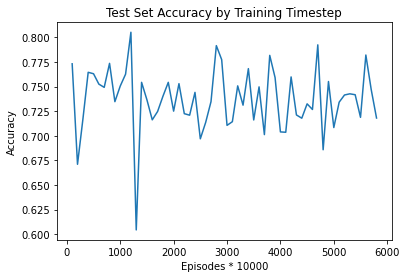

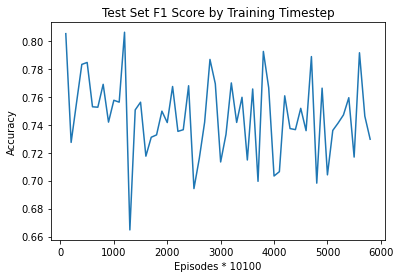

82321
43651  remaining~!
______________Attack Distributions Chosen___________________
{7: 185387, 30: 5880, 33: 39276, 18: 2644, 12: 12962, 11: 1992, 1: 4715, 13: 2895, 17: 10883, 28: 29548, 34: 35220, 38: 2, 6: 3686, 3: 9779, 22: 6140, 15: 14446, 5: 3169, 14: 82653, 4: 89548, 26: 3461, 2: 16992, 35: 3303, 16: 16418}
82360
43612  remaining~!
______________Attack Distributions Chosen___________________
{7: 186049, 30: 5880, 33: 39277, 18: 2645, 12: 12963, 11: 1993, 1: 4715, 13: 2895, 17: 10884, 28: 29549, 34: 35220, 38: 2, 6: 3687, 3: 9780, 22: 6141, 15: 14446, 5: 3170, 14: 82979, 4: 89548, 26: 3462, 2: 16993, 35: 3303, 16: 16418}
82388
43584  remaining~!
______________Attack Distributions Chosen___________________
{7: 186482, 30: 5883, 33: 39278, 18: 2645, 12: 12964, 11: 1993, 1: 4716, 13: 2896, 17: 10885, 28: 29551, 34: 35221, 38: 2, 6: 3687, 3: 9781, 22: 6142, 15: 14447, 5: 3171, 14: 83042, 4: 89604, 26: 3462, 2: 16995, 35: 3306, 16: 16846}
82421
43551  remaining~!
______________Atta

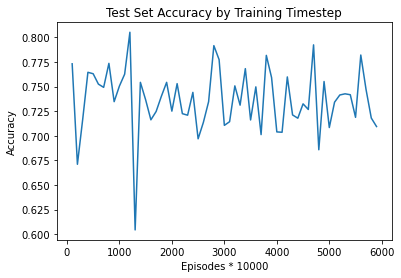

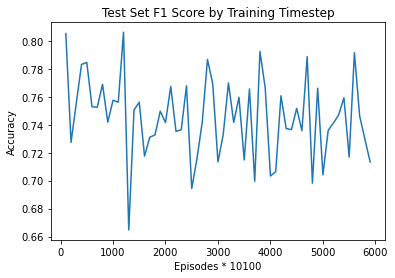

82642
43330  remaining~!
______________Attack Distributions Chosen___________________
{7: 190124, 30: 5915, 33: 39287, 18: 2653, 12: 12969, 11: 1995, 1: 4720, 13: 2900, 17: 10890, 28: 30361, 34: 35222, 38: 2, 6: 3693, 3: 9784, 22: 6151, 15: 14448, 5: 3176, 14: 83474, 4: 92287, 26: 3466, 2: 17319, 35: 3313, 16: 16850}
82681
43291  remaining~!
______________Attack Distributions Chosen___________________
{7: 190602, 30: 5919, 33: 39289, 18: 2654, 12: 12969, 11: 1997, 1: 4720, 13: 2900, 17: 10892, 28: 30363, 34: 35222, 38: 2, 6: 3693, 3: 9784, 22: 6151, 15: 14448, 5: 3177, 14: 83476, 4: 92389, 26: 3466, 2: 17722, 35: 3314, 16: 16850}
82722
43250  remaining~!
______________Attack Distributions Chosen___________________
{7: 191083, 30: 5922, 33: 39289, 18: 2655, 12: 12969, 11: 1997, 1: 4720, 13: 2900, 17: 10894, 28: 30363, 34: 35277, 38: 2, 6: 3693, 3: 9786, 22: 6151, 15: 14448, 5: 3178, 14: 83568, 4: 92751, 26: 3466, 2: 17722, 35: 3314, 16: 16851}
82748
43224  remaining~!
______________Atta

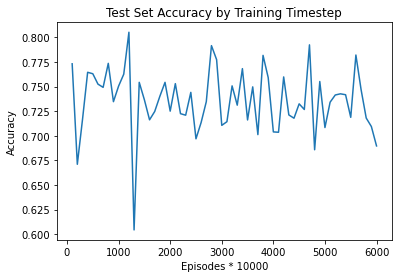

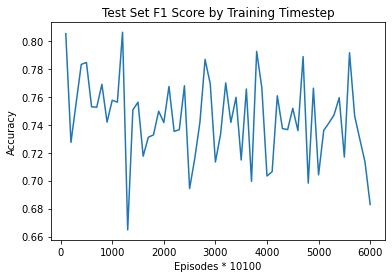

82925
43047  remaining~!
______________Attack Distributions Chosen___________________
{7: 193893, 30: 5950, 33: 39294, 18: 2660, 12: 12972, 11: 1999, 1: 4723, 13: 2912, 17: 10913, 28: 31095, 34: 36805, 38: 2, 6: 3699, 3: 9788, 22: 6154, 15: 14459, 5: 3180, 14: 84058, 4: 94937, 26: 3473, 2: 17865, 35: 3316, 16: 16852}
82957
43015  remaining~!
______________Attack Distributions Chosen___________________
{7: 194362, 30: 5954, 33: 39296, 18: 2661, 12: 12972, 11: 2000, 1: 4723, 13: 2912, 17: 10913, 28: 31095, 34: 36806, 38: 2, 6: 3699, 3: 9788, 22: 6154, 15: 14459, 5: 3180, 14: 84578, 4: 94938, 26: 3473, 2: 17865, 35: 3316, 16: 16853}
82989
42983  remaining~!
______________Attack Distributions Chosen___________________
{7: 194850, 30: 5957, 33: 39299, 18: 2664, 12: 12973, 11: 2000, 1: 4723, 13: 2912, 17: 10914, 28: 31095, 34: 36808, 38: 2, 6: 3699, 3: 9790, 22: 6154, 15: 14459, 5: 3181, 14: 85069, 4: 94938, 26: 3475, 2: 17865, 35: 3318, 16: 16854}
83019
42953  remaining~!
______________Atta

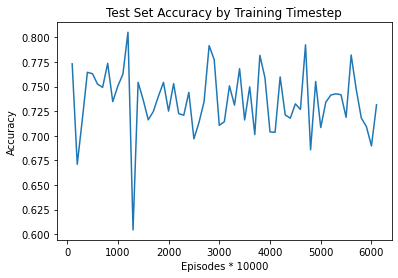

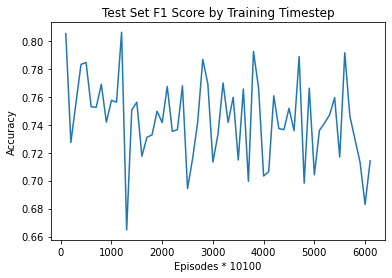

83215
42757  remaining~!
______________Attack Distributions Chosen___________________
{7: 198856, 30: 5980, 33: 39303, 18: 2669, 12: 12978, 11: 2004, 1: 4733, 13: 2914, 17: 10931, 28: 31262, 34: 36811, 38: 2, 6: 3707, 3: 9797, 22: 6158, 15: 14462, 5: 3186, 14: 88768, 4: 94940, 26: 3482, 2: 17870, 35: 3322, 16: 16864}
83249
42723  remaining~!
______________Attack Distributions Chosen___________________
{7: 199370, 30: 5985, 33: 39303, 18: 2671, 12: 12979, 11: 2006, 1: 4735, 13: 2915, 17: 10934, 28: 31292, 34: 36811, 38: 2, 6: 3708, 3: 9798, 22: 6158, 15: 14462, 5: 3187, 14: 89200, 4: 94940, 26: 3483, 2: 17872, 35: 3323, 16: 16865}
83268
42704  remaining~!
______________Attack Distributions Chosen___________________
{7: 199639, 30: 5988, 33: 39304, 18: 2672, 12: 12979, 11: 2006, 1: 4736, 13: 2916, 17: 10956, 28: 31947, 34: 36811, 38: 2, 6: 3708, 3: 9799, 22: 6158, 15: 14462, 5: 3188, 14: 89241, 4: 94940, 26: 3483, 2: 17873, 35: 3325, 16: 16866}
83299
42673  remaining~!
______________Atta

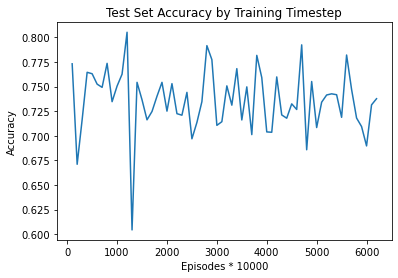

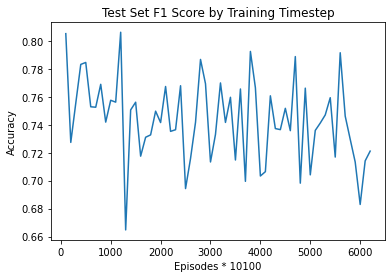

83472
42500  remaining~!
______________Attack Distributions Chosen___________________
{7: 202732, 30: 6014, 33: 39689, 18: 2682, 12: 12985, 11: 2013, 1: 4742, 13: 3003, 17: 10959, 28: 32679, 34: 37273, 38: 2, 6: 3711, 3: 9803, 22: 6159, 15: 14463, 5: 3190, 14: 91205, 4: 95427, 26: 3488, 2: 18388, 35: 3329, 16: 17063}
83477
42495  remaining~!
______________Attack Distributions Chosen___________________
{7: 202821, 30: 6017, 33: 39936, 18: 2682, 12: 12985, 11: 2016, 1: 4742, 13: 3003, 17: 10960, 28: 32711, 34: 37829, 38: 2, 6: 3711, 3: 9803, 22: 6159, 15: 14464, 5: 3190, 14: 91205, 4: 95484, 26: 3489, 2: 18388, 35: 3329, 16: 17073}
83492
42480  remaining~!
______________Attack Distributions Chosen___________________
{7: 203024, 30: 6019, 33: 40154, 18: 2683, 12: 12988, 11: 2016, 1: 4743, 13: 3003, 17: 10960, 28: 32711, 34: 38014, 38: 2, 6: 3712, 3: 9803, 22: 6159, 15: 14469, 5: 3191, 14: 91205, 4: 95864, 26: 3489, 2: 18388, 35: 3329, 16: 17073}
83519
42453  remaining~!
______________Atta

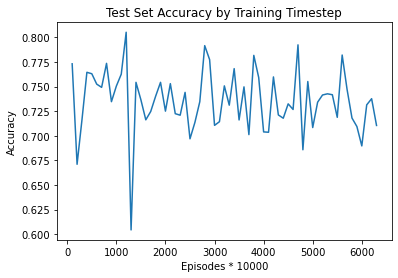

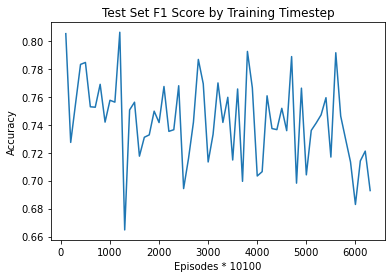

83640
42332  remaining~!
______________Attack Distributions Chosen___________________
{7: 205512, 30: 6042, 33: 42074, 18: 2688, 12: 12996, 11: 2023, 1: 4749, 13: 3011, 17: 10964, 28: 32723, 34: 38364, 38: 2, 6: 3718, 3: 9812, 22: 6164, 15: 16084, 5: 3194, 14: 91220, 4: 97340, 26: 3492, 2: 18416, 35: 3335, 16: 17076}
83654
42318  remaining~!
______________Attack Distributions Chosen___________________
{7: 205906, 30: 6043, 33: 42225, 18: 2689, 12: 12998, 11: 2024, 1: 4749, 13: 3011, 17: 10966, 28: 32734, 34: 38433, 38: 2, 6: 3718, 3: 9813, 22: 6164, 15: 16085, 5: 3194, 14: 91220, 4: 97589, 26: 3492, 2: 18416, 35: 3336, 16: 17192}
83664
42308  remaining~!
______________Attack Distributions Chosen___________________
{7: 205991, 30: 6049, 33: 42225, 18: 2689, 12: 13079, 11: 2027, 1: 4749, 13: 3011, 17: 10966, 28: 32793, 34: 38734, 38: 2, 6: 3759, 3: 9813, 22: 6164, 15: 16301, 5: 3195, 14: 91220, 4: 97625, 26: 3493, 2: 18417, 35: 3336, 16: 17361}
83667
42305  remaining~!
______________Atta

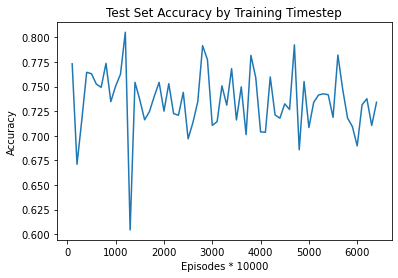

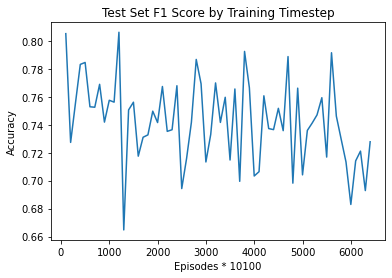

83720
42252  remaining~!
______________Attack Distributions Chosen___________________
{7: 206520, 30: 6073, 33: 43566, 18: 2692, 12: 13310, 11: 2036, 1: 4752, 13: 3015, 17: 10970, 28: 35425, 34: 38900, 38: 2, 6: 3832, 3: 9818, 22: 6165, 15: 17520, 5: 3198, 14: 91955, 4: 98617, 26: 3497, 2: 18420, 35: 3341, 16: 17375}
83724
42248  remaining~!
______________Attack Distributions Chosen___________________
{7: 206526, 30: 6077, 33: 43936, 18: 2692, 12: 13310, 11: 2036, 1: 4752, 13: 3015, 17: 10970, 28: 35646, 34: 38900, 38: 2, 6: 3832, 3: 9819, 22: 6165, 15: 17793, 5: 3198, 14: 91955, 4: 98740, 26: 3498, 2: 18420, 35: 3341, 16: 17376}
83728
42244  remaining~!
______________Attack Distributions Chosen___________________
{7: 206530, 30: 6080, 33: 43994, 18: 2693, 12: 13310, 11: 2036, 1: 4754, 13: 3015, 17: 10971, 28: 35822, 34: 39465, 38: 2, 6: 3833, 3: 9822, 22: 6165, 15: 17819, 5: 3199, 14: 91956, 4: 98894, 26: 3499, 2: 18420, 35: 3343, 16: 17377}
83734
42238  remaining~!
______________Atta

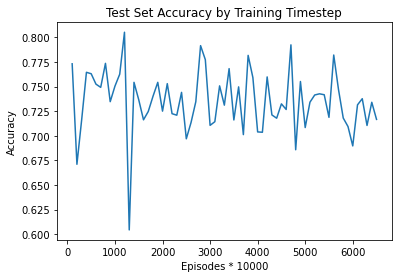

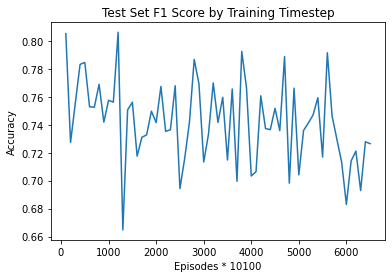

83783
42189  remaining~!
______________Attack Distributions Chosen___________________
{7: 207188, 30: 6106, 33: 45684, 18: 2704, 12: 13316, 11: 2042, 1: 4760, 13: 3026, 17: 10976, 28: 38056, 34: 39727, 38: 2, 6: 3835, 3: 9829, 22: 6235, 15: 18820, 5: 3201, 14: 92139, 4: 100413, 26: 3507, 2: 18624, 35: 3348, 16: 17461}
83789
42183  remaining~!
______________Attack Distributions Chosen___________________
{7: 207251, 30: 6108, 33: 45692, 18: 2705, 12: 13316, 11: 2042, 1: 4761, 13: 3026, 17: 10976, 28: 38196, 34: 39728, 38: 2, 6: 3835, 3: 9830, 22: 6236, 15: 18822, 5: 3202, 14: 92434, 4: 100413, 26: 3507, 2: 18686, 35: 3349, 16: 17882}
83792
42180  remaining~!
______________Attack Distributions Chosen___________________
{7: 207256, 30: 6109, 33: 45697, 18: 2708, 12: 13316, 11: 2043, 1: 4761, 13: 3026, 17: 10978, 28: 38214, 34: 39728, 38: 2, 6: 3835, 3: 9831, 22: 6236, 15: 18823, 5: 3204, 14: 92438, 4: 100413, 26: 3507, 2: 18687, 35: 3350, 16: 18837}
83795
42177  remaining~!
______________A

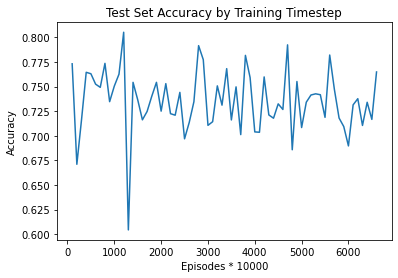

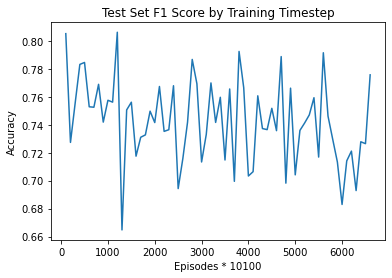

83833
42139  remaining~!
______________Attack Distributions Chosen___________________
{7: 207340, 30: 6140, 33: 46335, 18: 2719, 12: 13326, 11: 2049, 1: 4770, 13: 3032, 17: 10986, 28: 38973, 34: 40088, 38: 2, 6: 3837, 3: 9836, 22: 6528, 15: 19202, 5: 3208, 14: 92457, 4: 101090, 26: 3511, 2: 19065, 35: 3403, 16: 23102}
83838
42134  remaining~!
______________Attack Distributions Chosen___________________
{7: 207350, 30: 6145, 33: 46335, 18: 2719, 12: 13327, 11: 2049, 1: 4771, 13: 3032, 17: 10987, 28: 38982, 34: 40089, 38: 2, 6: 3837, 3: 9836, 22: 6530, 15: 19215, 5: 3209, 14: 92458, 4: 101091, 26: 3511, 2: 19066, 35: 3404, 16: 24054}
83843
42129  remaining~!
______________Attack Distributions Chosen___________________
{7: 207355, 30: 6148, 33: 46335, 18: 2720, 12: 13327, 11: 2049, 1: 4771, 13: 3034, 17: 10987, 28: 39011, 34: 40139, 38: 2, 6: 3838, 3: 9837, 22: 6531, 15: 19216, 5: 3209, 14: 92458, 4: 101091, 26: 3511, 2: 19067, 35: 3405, 16: 24958}
83845
42127  remaining~!
______________A

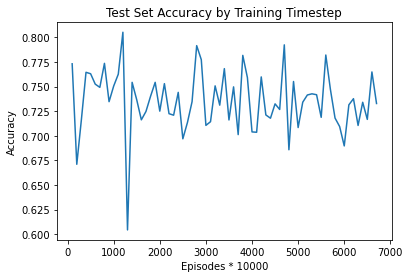

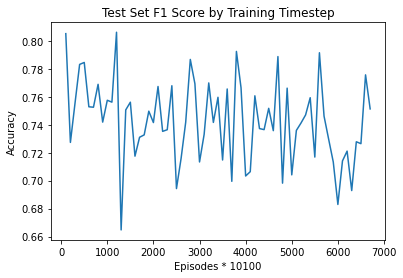

83946
42026  remaining~!
______________Attack Distributions Chosen___________________
{7: 208952, 30: 6174, 33: 47689, 18: 2722, 12: 13330, 11: 2057, 1: 4778, 13: 3039, 17: 10990, 28: 40035, 34: 40147, 38: 2, 6: 3841, 3: 9845, 22: 6725, 15: 20201, 5: 3213, 14: 92849, 4: 101897, 26: 3519, 2: 19429, 35: 3409, 16: 26156}
83998
41974  remaining~!
______________Attack Distributions Chosen___________________
{7: 209919, 30: 6177, 33: 47689, 18: 2724, 12: 13332, 11: 2058, 1: 4778, 13: 3039, 17: 10990, 28: 40035, 34: 40148, 38: 2, 6: 3841, 3: 9846, 22: 6725, 15: 20201, 5: 3213, 14: 92849, 4: 101920, 26: 3519, 2: 19429, 35: 3409, 16: 26156}
84044
41928  remaining~!
______________Attack Distributions Chosen___________________
{7: 210886, 30: 6181, 33: 47690, 18: 2725, 12: 13333, 11: 2058, 1: 4778, 13: 3039, 17: 10990, 28: 40035, 34: 40148, 38: 2, 6: 3843, 3: 9846, 22: 6725, 15: 20203, 5: 3214, 14: 92849, 4: 101939, 26: 3521, 2: 19429, 35: 3409, 16: 26156}
84092
41880  remaining~!
______________A

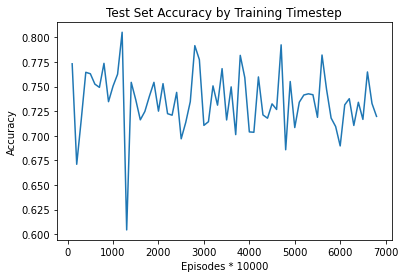

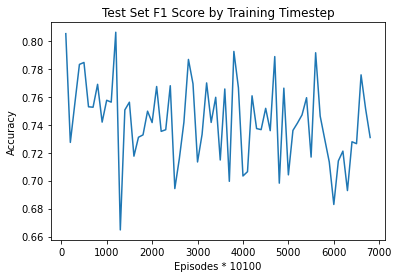

84309
41663  remaining~!
______________Attack Distributions Chosen___________________
{7: 216498, 30: 6200, 33: 48779, 18: 2731, 12: 13352, 11: 2062, 1: 4787, 13: 3042, 17: 10996, 28: 40369, 34: 40150, 38: 2, 6: 3859, 3: 9852, 22: 6728, 15: 20206, 5: 3219, 14: 93684, 4: 101945, 26: 3524, 2: 19434, 35: 3418, 16: 26162}
84334
41638  remaining~!
______________Attack Distributions Chosen___________________
{7: 217053, 30: 6204, 33: 48780, 18: 2732, 12: 13352, 11: 2063, 1: 4787, 13: 3042, 17: 10996, 28: 40428, 34: 40150, 38: 2, 6: 3876, 3: 9852, 22: 6729, 15: 20207, 5: 3220, 14: 94036, 4: 101945, 26: 3526, 2: 19437, 35: 3420, 16: 26162}
84357
41615  remaining~!
______________Attack Distributions Chosen___________________
{7: 217597, 30: 6207, 33: 48781, 18: 2732, 12: 13353, 11: 2063, 1: 4787, 13: 3042, 17: 10996, 28: 40428, 34: 40151, 38: 2, 6: 3894, 3: 9852, 22: 6729, 15: 20207, 5: 3221, 14: 94460, 4: 101946, 26: 3527, 2: 19441, 35: 3420, 16: 26163}
84372
41600  remaining~!
______________A

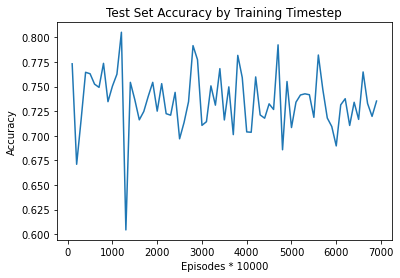

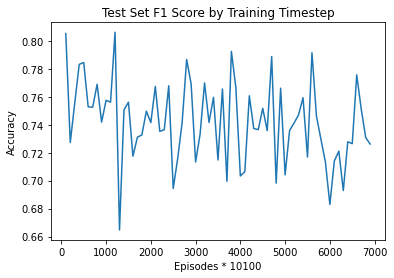

84519
41453  remaining~!
______________Attack Distributions Chosen___________________
{7: 221960, 30: 6218, 33: 48788, 18: 2737, 12: 13359, 11: 2070, 1: 4798, 13: 3048, 17: 11004, 28: 40451, 34: 41292, 38: 2, 6: 3897, 3: 9857, 22: 6733, 15: 20211, 5: 3224, 14: 96818, 4: 101958, 26: 3528, 2: 19452, 35: 3424, 16: 26170}
84535
41437  remaining~!
______________Attack Distributions Chosen___________________
{7: 222540, 30: 6219, 33: 48788, 18: 2738, 12: 13360, 11: 2070, 1: 4799, 13: 3048, 17: 11005, 28: 40453, 34: 41588, 38: 2, 6: 3898, 3: 9857, 22: 6733, 15: 20211, 5: 3224, 14: 96889, 4: 101959, 26: 3528, 2: 19496, 35: 3424, 16: 26170}
84553
41419  remaining~!
______________Attack Distributions Chosen___________________
{7: 223022, 30: 6220, 33: 48788, 18: 2739, 12: 13361, 11: 2070, 1: 4799, 13: 3048, 17: 11006, 28: 40454, 34: 41761, 38: 2, 6: 3899, 3: 9858, 22: 6733, 15: 20212, 5: 3224, 14: 97180, 4: 101959, 26: 3528, 2: 19542, 35: 3424, 16: 26170}
84575
41397  remaining~!
______________A

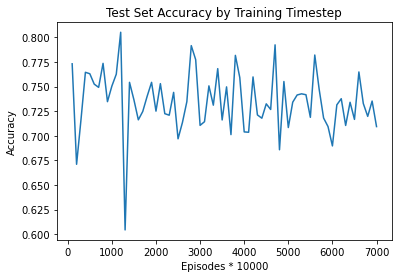

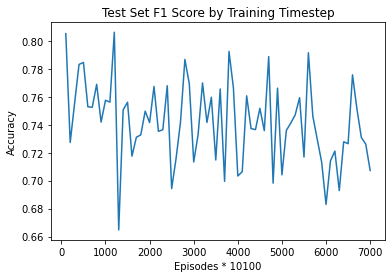

84699
41273  remaining~!
______________Attack Distributions Chosen___________________
{7: 226614, 30: 6242, 33: 48792, 18: 2741, 12: 13364, 11: 2071, 1: 4802, 13: 3049, 17: 11015, 28: 40458, 34: 42022, 38: 2, 6: 3905, 3: 9861, 22: 6739, 15: 20218, 5: 3228, 14: 98123, 4: 104092, 26: 3535, 2: 20459, 35: 3428, 16: 26239}
84702
41270  remaining~!
______________Attack Distributions Chosen___________________
{7: 226618, 30: 6244, 33: 48792, 18: 2741, 12: 13364, 11: 2072, 1: 4804, 13: 3049, 17: 11017, 28: 40459, 34: 42023, 38: 2, 6: 3905, 3: 9861, 22: 6739, 15: 20219, 5: 3229, 14: 98125, 4: 105074, 26: 3535, 2: 20459, 35: 3429, 16: 26239}
84707
41265  remaining~!
______________Attack Distributions Chosen___________________
{7: 226620, 30: 6246, 33: 48792, 18: 2741, 12: 13365, 11: 2072, 1: 4804, 13: 3052, 17: 11017, 28: 40461, 34: 42059, 38: 2, 6: 3906, 3: 9861, 22: 6739, 15: 20219, 5: 3231, 14: 98125, 4: 106024, 26: 3536, 2: 20459, 35: 3429, 16: 26239}
84714
41258  remaining~!
______________A

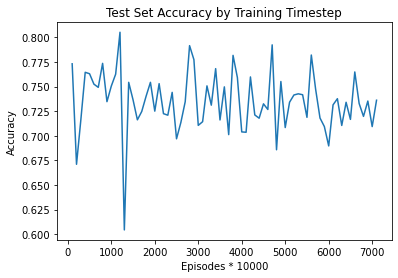

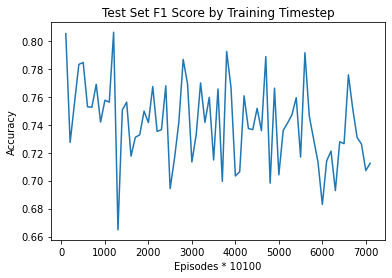

84794
41178  remaining~!
______________Attack Distributions Chosen___________________
{7: 228192, 30: 6271, 33: 48796, 18: 2745, 12: 13663, 11: 2075, 1: 4805, 13: 3063, 17: 11022, 28: 40464, 34: 43412, 38: 2, 6: 3908, 3: 9865, 22: 6744, 15: 20224, 5: 3237, 14: 98127, 4: 110257, 26: 3545, 2: 20910, 35: 3430, 16: 26242}
84797
41175  remaining~!
______________Attack Distributions Chosen___________________
{7: 228197, 30: 6273, 33: 48797, 18: 2745, 12: 13664, 11: 2077, 1: 4805, 13: 3063, 17: 11022, 28: 40464, 34: 43415, 38: 2, 6: 3908, 3: 9866, 22: 6744, 15: 20225, 5: 3237, 14: 98127, 4: 111238, 26: 3545, 2: 20912, 35: 3430, 16: 26243}
84808
41164  remaining~!
______________Attack Distributions Chosen___________________
{7: 228449, 30: 6277, 33: 48797, 18: 2746, 12: 13664, 11: 2077, 1: 4805, 13: 3064, 17: 11022, 28: 40466, 34: 43416, 38: 2, 6: 3908, 3: 9866, 22: 6744, 15: 20226, 5: 3238, 14: 98128, 4: 111973, 26: 3545, 2: 20912, 35: 3431, 16: 26243}
84825
41147  remaining~!
______________A

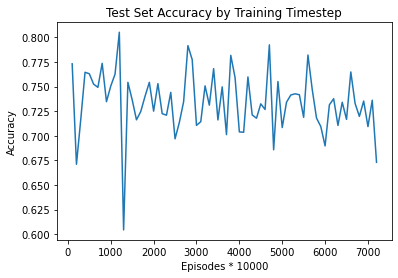

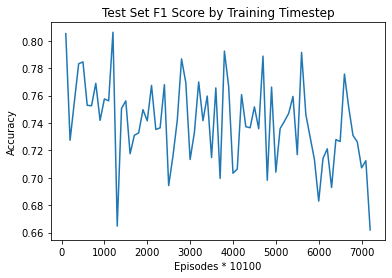

84927
41045  remaining~!
______________Attack Distributions Chosen___________________
{7: 231104, 30: 6305, 33: 48800, 18: 2754, 12: 13673, 11: 2081, 1: 4808, 13: 3068, 17: 11027, 28: 40473, 34: 43599, 38: 2, 6: 3911, 3: 9870, 22: 6748, 15: 20228, 5: 3239, 14: 98132, 4: 117028, 26: 3548, 2: 20916, 35: 3435, 16: 26250}
84931
41041  remaining~!
______________Attack Distributions Chosen___________________
{7: 231197, 30: 6307, 33: 48801, 18: 2756, 12: 13675, 11: 2082, 1: 4809, 13: 3068, 17: 11028, 28: 40473, 34: 43600, 38: 2, 6: 3912, 3: 9870, 22: 6748, 15: 20228, 5: 3240, 14: 98133, 4: 117918, 26: 3548, 2: 20918, 35: 3436, 16: 26250}
84940
41032  remaining~!
______________Attack Distributions Chosen___________________
{7: 231562, 30: 6307, 33: 48801, 18: 2756, 12: 13675, 11: 2082, 1: 4809, 13: 3068, 17: 11028, 28: 40474, 34: 43600, 38: 2, 6: 3977, 3: 9870, 22: 6750, 15: 20229, 5: 3241, 14: 98133, 4: 118481, 26: 3548, 2: 20918, 35: 3436, 16: 26252}
84948
41024  remaining~!
______________A

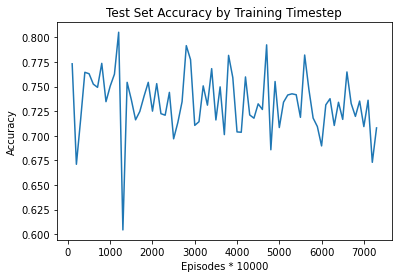

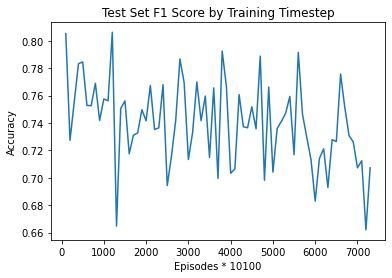

84981
40991  remaining~!
______________Attack Distributions Chosen___________________
{7: 231824, 30: 6330, 33: 48805, 18: 2760, 12: 13680, 11: 2088, 1: 4817, 13: 3076, 17: 11030, 28: 40478, 34: 45730, 38: 2, 6: 4897, 3: 9874, 22: 6759, 15: 20234, 5: 3241, 14: 98138, 4: 122653, 26: 3553, 2: 21333, 35: 3441, 16: 26256}
84984
40988  remaining~!
______________Attack Distributions Chosen___________________
{7: 231862, 30: 6334, 33: 48805, 18: 2760, 12: 13680, 11: 2089, 1: 4818, 13: 3076, 17: 11030, 28: 40478, 34: 45731, 38: 2, 6: 4898, 3: 9874, 22: 6759, 15: 20234, 5: 3242, 14: 98138, 4: 123575, 26: 3554, 2: 21361, 35: 3442, 16: 26257}
84987
40985  remaining~!
______________Attack Distributions Chosen___________________
{7: 231868, 30: 6337, 33: 48806, 18: 2760, 12: 13682, 11: 2089, 1: 4818, 13: 3076, 17: 11031, 28: 40478, 34: 45733, 38: 2, 6: 4898, 3: 9875, 22: 6761, 15: 20237, 5: 3242, 14: 98138, 4: 124552, 26: 3554, 2: 21362, 35: 3443, 16: 26257}
84988
40984  remaining~!
______________A

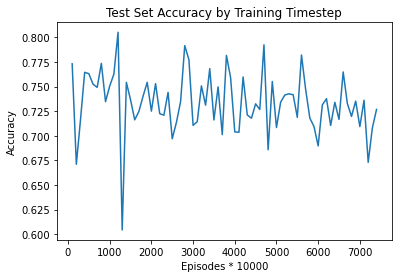

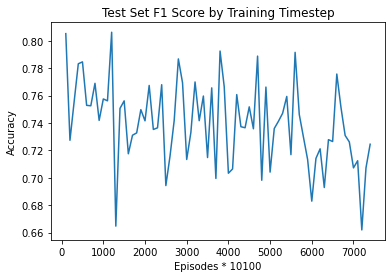

85008
40964  remaining~!
______________Attack Distributions Chosen___________________
{7: 232010, 30: 6354, 33: 52270, 18: 2770, 12: 13686, 11: 2094, 1: 4825, 13: 3083, 17: 11037, 28: 40486, 34: 46084, 38: 2, 6: 4899, 3: 9880, 22: 6763, 15: 20240, 5: 3246, 14: 98141, 4: 127765, 26: 3559, 2: 22096, 35: 3446, 16: 26263}
85014
40958  remaining~!
______________Attack Distributions Chosen___________________
{7: 232014, 30: 6360, 33: 53250, 18: 2771, 12: 13686, 11: 2096, 1: 4825, 13: 3084, 17: 11038, 28: 40486, 34: 46085, 38: 2, 6: 4900, 3: 9881, 22: 6763, 15: 20240, 5: 3246, 14: 98141, 4: 127766, 26: 3560, 2: 22096, 35: 3446, 16: 26263}
85020
40952  remaining~!
______________Attack Distributions Chosen___________________
{7: 232017, 30: 6366, 33: 54230, 18: 2771, 12: 13688, 11: 2096, 1: 4825, 13: 3085, 17: 11038, 28: 40487, 34: 46086, 38: 2, 6: 4901, 3: 9881, 22: 6763, 15: 20242, 5: 3246, 14: 98142, 4: 127766, 26: 3560, 2: 22096, 35: 3446, 16: 26265}
85022
40950  remaining~!
______________A

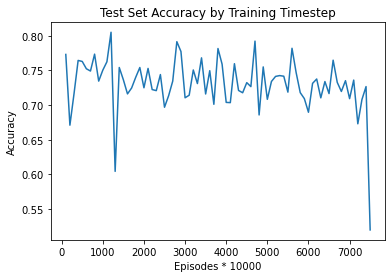

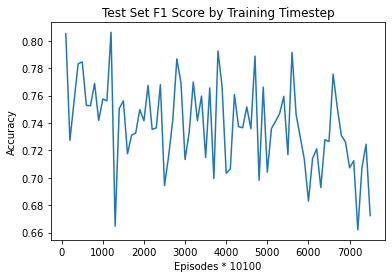

85049
40923  remaining~!
______________Attack Distributions Chosen___________________
{7: 232106, 30: 6391, 33: 57170, 18: 2781, 12: 13694, 11: 2100, 1: 4833, 13: 3088, 17: 11044, 28: 40701, 34: 47032, 38: 2, 6: 4910, 3: 9884, 22: 6766, 15: 20994, 5: 3251, 14: 98146, 4: 130723, 26: 3567, 2: 22097, 35: 3449, 16: 26270}
85050
40922  remaining~!
______________Attack Distributions Chosen___________________
{7: 232109, 30: 6392, 33: 58154, 18: 2781, 12: 13694, 11: 2100, 1: 4834, 13: 3089, 17: 11045, 28: 40702, 34: 47033, 38: 2, 6: 4910, 3: 9885, 22: 6766, 15: 20996, 5: 3252, 14: 98147, 4: 130723, 26: 3568, 2: 22097, 35: 3450, 16: 26270}
85075
40897  remaining~!
______________Attack Distributions Chosen___________________
{7: 232756, 30: 6396, 33: 58494, 18: 2782, 12: 13694, 11: 2100, 1: 4835, 13: 3089, 17: 11046, 28: 40703, 34: 47033, 38: 2, 6: 4911, 3: 9885, 22: 6767, 15: 20997, 5: 3252, 14: 98147, 4: 130724, 26: 3568, 2: 22097, 35: 3451, 16: 26270}
85107
40865  remaining~!
______________A

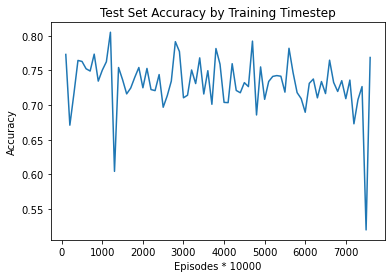

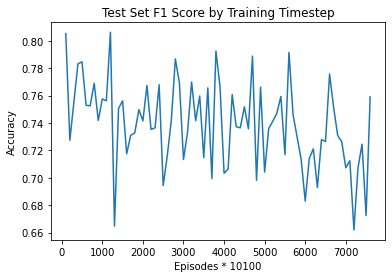

85242
40730  remaining~!
______________Attack Distributions Chosen___________________
{7: 237963, 30: 6418, 33: 61158, 18: 2788, 12: 13702, 11: 2105, 1: 4840, 13: 3092, 17: 11054, 28: 40709, 34: 47039, 38: 2, 6: 4919, 3: 9888, 22: 6774, 15: 21002, 5: 3256, 14: 98161, 4: 130727, 26: 3574, 2: 22101, 35: 3454, 16: 26273}
85253
40719  remaining~!
______________Attack Distributions Chosen___________________
{7: 238307, 30: 6422, 33: 61803, 18: 2789, 12: 13702, 11: 2106, 1: 4840, 13: 3093, 17: 11055, 28: 40709, 34: 47039, 38: 2, 6: 4919, 3: 9888, 22: 6774, 15: 21002, 5: 3256, 14: 98162, 4: 130728, 26: 3574, 2: 22101, 35: 3454, 16: 26274}
85277
40695  remaining~!
______________Attack Distributions Chosen___________________
{7: 239199, 30: 6422, 33: 61901, 18: 2789, 12: 13703, 11: 2107, 1: 4841, 13: 3094, 17: 11055, 28: 40710, 34: 47040, 38: 2, 6: 4919, 3: 9890, 22: 6774, 15: 21002, 5: 3256, 14: 98162, 4: 130728, 26: 3575, 2: 22101, 35: 3454, 16: 26275}
85305
40667  remaining~!
______________A

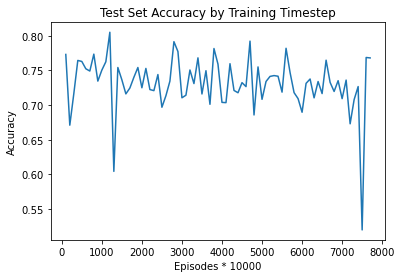

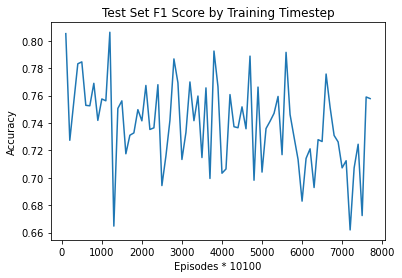

85529
40443  remaining~!
______________Attack Distributions Chosen___________________
{7: 247072, 30: 6457, 33: 61907, 18: 2797, 12: 13707, 11: 2110, 1: 4843, 13: 3103, 17: 11065, 28: 40715, 34: 47044, 38: 2, 6: 4923, 3: 9893, 22: 6778, 15: 21003, 5: 3260, 14: 98165, 4: 130733, 26: 3579, 2: 22106, 35: 3459, 16: 26278}
85541
40431  remaining~!
______________Attack Distributions Chosen___________________
{7: 247319, 30: 6460, 33: 61907, 18: 2797, 12: 13708, 11: 2110, 1: 4846, 13: 3104, 17: 11065, 28: 40715, 34: 47044, 38: 2, 6: 4924, 3: 9893, 22: 6778, 15: 21004, 5: 3260, 14: 98907, 4: 130733, 26: 3580, 2: 22106, 35: 3459, 16: 26278}
85546
40426  remaining~!
______________Attack Distributions Chosen___________________
{7: 247325, 30: 6464, 33: 61907, 18: 2798, 12: 13708, 11: 2111, 1: 4846, 13: 3105, 17: 11065, 28: 41588, 34: 47044, 38: 2, 6: 4925, 3: 9894, 22: 6778, 15: 21005, 5: 3260, 14: 99016, 4: 130733, 26: 3580, 2: 22107, 35: 3460, 16: 26278}
85556
40416  remaining~!
______________A

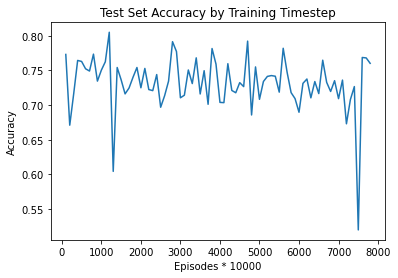

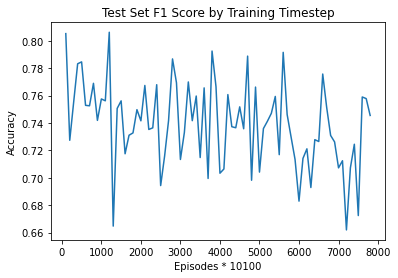

85694
40278  remaining~!
______________Attack Distributions Chosen___________________
{7: 251457, 30: 6500, 33: 61913, 18: 2803, 12: 13716, 11: 2115, 1: 4853, 13: 3112, 17: 11074, 28: 42159, 34: 47046, 38: 2, 6: 4927, 3: 9900, 22: 6784, 15: 21008, 5: 3266, 14: 102188, 4: 130735, 26: 3586, 2: 22110, 35: 3464, 16: 26281}
85733
40239  remaining~!
______________Attack Distributions Chosen___________________
{7: 252443, 30: 6503, 33: 61913, 18: 2805, 12: 13716, 11: 2115, 1: 4853, 13: 3112, 17: 11075, 28: 42160, 34: 47046, 38: 2, 6: 4927, 3: 9900, 22: 6784, 15: 21009, 5: 3267, 14: 102188, 4: 130736, 26: 3587, 2: 22111, 35: 3465, 16: 26282}
85753
40219  remaining~!
______________Attack Distributions Chosen___________________
{7: 253434, 30: 6505, 33: 61913, 18: 2806, 12: 13716, 11: 2115, 1: 4853, 13: 3112, 17: 11075, 28: 42160, 34: 47047, 38: 2, 6: 4928, 3: 9901, 22: 6784, 15: 21009, 5: 3268, 14: 102188, 4: 130737, 26: 3587, 2: 22111, 35: 3466, 16: 26282}
85787
40185  remaining~!
____________

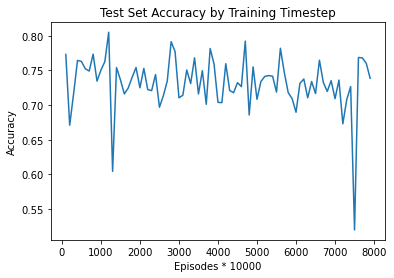

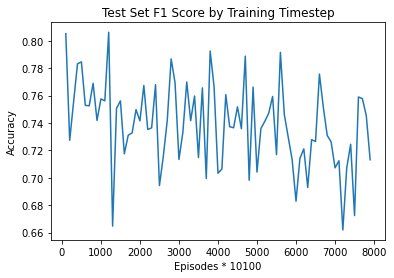

85876
40096  remaining~!
______________Attack Distributions Chosen___________________
{7: 256835, 30: 6537, 33: 61921, 18: 2810, 12: 13722, 11: 2120, 1: 4859, 13: 3114, 17: 11080, 28: 45563, 34: 47052, 38: 2, 6: 4934, 3: 9903, 22: 6789, 15: 21013, 5: 3363, 14: 103179, 4: 130741, 26: 3591, 2: 22114, 35: 3470, 16: 26287}
85883
40089  remaining~!
______________Attack Distributions Chosen___________________
{7: 256840, 30: 6543, 33: 61921, 18: 2812, 12: 13724, 11: 2120, 1: 4859, 13: 3115, 17: 11080, 28: 45563, 34: 47052, 38: 2, 6: 4935, 3: 9903, 22: 6790, 15: 21013, 5: 3363, 14: 104158, 4: 130742, 26: 3591, 2: 22115, 35: 3471, 16: 26287}
85885
40087  remaining~!
______________Attack Distributions Chosen___________________
{7: 256844, 30: 6543, 33: 61921, 18: 2813, 12: 13725, 11: 2120, 1: 4860, 13: 3117, 17: 11080, 28: 45563, 34: 47053, 38: 2, 6: 4937, 3: 9903, 22: 6791, 15: 21013, 5: 3364, 14: 105140, 4: 130743, 26: 3591, 2: 22117, 35: 3472, 16: 26287}
85889
40083  remaining~!
____________

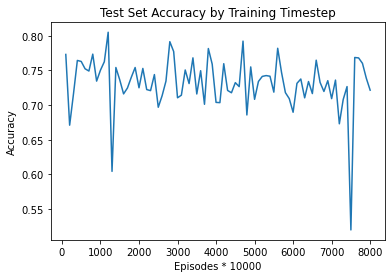

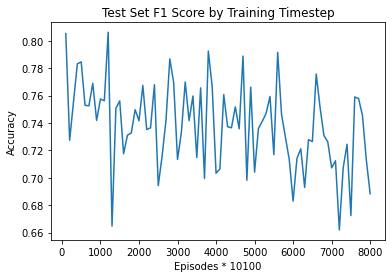

85916
40056  remaining~!
______________Attack Distributions Chosen___________________
{7: 256888, 30: 6567, 33: 61926, 18: 2821, 12: 13733, 11: 2126, 1: 4866, 13: 3123, 17: 11087, 28: 45566, 34: 47058, 38: 2, 6: 4944, 3: 9907, 22: 11971, 15: 21019, 5: 3367, 14: 107793, 4: 130748, 26: 3595, 2: 22128, 35: 3474, 16: 26290}
85922
40050  remaining~!
______________Attack Distributions Chosen___________________
{7: 256895, 30: 6571, 33: 61926, 18: 2821, 12: 13734, 11: 2126, 1: 4866, 13: 3124, 17: 11088, 28: 45566, 34: 47058, 38: 2, 6: 4944, 3: 9909, 22: 12948, 15: 21019, 5: 3369, 14: 107794, 4: 130749, 26: 3595, 2: 22128, 35: 3476, 16: 26291}
85925
40047  remaining~!
______________Attack Distributions Chosen___________________
{7: 256900, 30: 6573, 33: 61926, 18: 2821, 12: 13735, 11: 2127, 1: 4866, 13: 3126, 17: 11091, 28: 45566, 34: 47058, 38: 2, 6: 4946, 3: 9909, 22: 13923, 15: 21019, 5: 3369, 14: 107794, 4: 130751, 26: 3598, 2: 22128, 35: 3478, 16: 26293}
85929
40043  remaining~!
_________

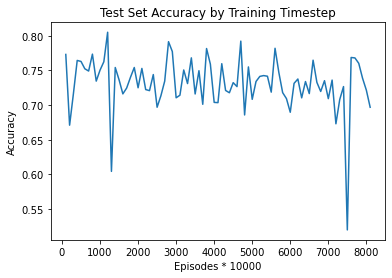

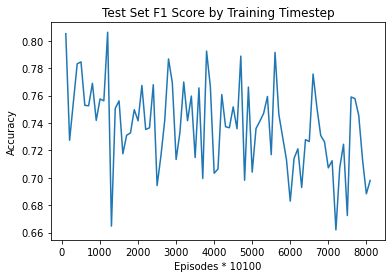

85961
40011  remaining~!
______________Attack Distributions Chosen___________________
{7: 257226, 30: 6601, 33: 64248, 18: 2827, 12: 13741, 11: 2131, 1: 4870, 13: 3134, 17: 11096, 28: 45570, 34: 47065, 38: 2, 6: 4949, 3: 9918, 22: 19160, 15: 21022, 5: 3373, 14: 107800, 4: 130754, 26: 3602, 2: 22133, 35: 3482, 16: 26295}
85971
40001  remaining~!
______________Attack Distributions Chosen___________________
{7: 257392, 30: 6606, 33: 64248, 18: 2828, 12: 13741, 11: 2132, 1: 4870, 13: 3134, 17: 11097, 28: 46141, 34: 47065, 38: 2, 6: 4949, 3: 9972, 22: 19356, 15: 21024, 5: 3373, 14: 107800, 4: 130754, 26: 3603, 2: 22134, 35: 3482, 16: 26296}
85975
39997  remaining~!
______________Attack Distributions Chosen___________________
{7: 257445, 30: 6608, 33: 64248, 18: 2829, 12: 13742, 11: 2133, 1: 4870, 13: 3135, 17: 11099, 28: 47075, 34: 47065, 38: 2, 6: 4949, 3: 9974, 22: 19356, 15: 21024, 5: 3373, 14: 107800, 4: 130755, 26: 3603, 2: 22135, 35: 3483, 16: 26296}
85979
39993  remaining~!
_________

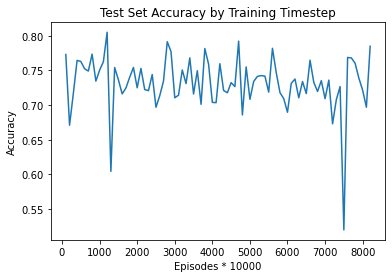

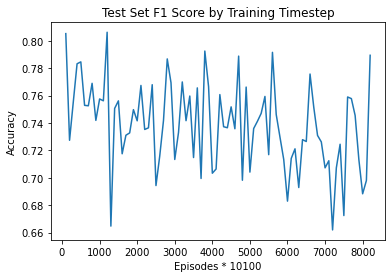

86011
39961  remaining~!
______________Attack Distributions Chosen___________________
{7: 257713, 30: 6639, 33: 64253, 18: 2835, 12: 13746, 11: 2136, 1: 4877, 13: 3141, 17: 11103, 28: 47282, 34: 53129, 38: 2, 6: 4955, 3: 9980, 22: 19360, 15: 21030, 5: 3375, 14: 109144, 4: 130758, 26: 3610, 2: 22139, 35: 3489, 16: 26303}
86015
39957  remaining~!
______________Attack Distributions Chosen___________________
{7: 257734, 30: 6642, 33: 64253, 18: 2835, 12: 13746, 11: 2137, 1: 4878, 13: 3143, 17: 11103, 28: 47283, 34: 54066, 38: 2, 6: 4955, 3: 9984, 22: 19361, 15: 21030, 5: 3375, 14: 109169, 4: 130758, 26: 3610, 2: 22143, 35: 3489, 16: 26303}
86023
39949  remaining~!
______________Attack Distributions Chosen___________________
{7: 257938, 30: 6644, 33: 64255, 18: 2838, 12: 13746, 11: 2137, 1: 4880, 13: 3144, 17: 11104, 28: 47284, 34: 54847, 38: 2, 6: 4955, 3: 9985, 22: 19361, 15: 21030, 5: 3375, 14: 109169, 4: 130759, 26: 3610, 2: 22144, 35: 3489, 16: 26303}
86024
39948  remaining~!
_________

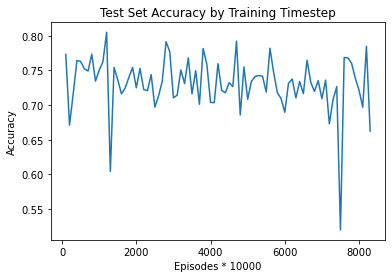

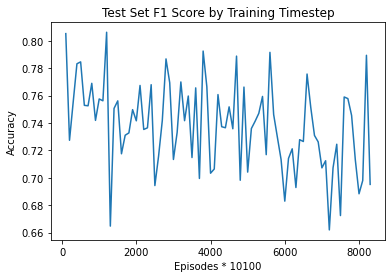

86053
39919  remaining~!
______________Attack Distributions Chosen___________________
{7: 258593, 30: 6660, 33: 68640, 18: 2841, 12: 13751, 11: 2142, 1: 4883, 13: 3149, 17: 11114, 28: 47289, 34: 55384, 38: 2, 6: 4961, 3: 9990, 22: 21696, 15: 21031, 5: 3379, 14: 109171, 4: 130764, 26: 3612, 2: 22147, 35: 3492, 16: 26308}
86057
39915  remaining~!
______________Attack Distributions Chosen___________________
{7: 258636, 30: 6665, 33: 68991, 18: 2841, 12: 13751, 11: 2143, 1: 4884, 13: 3149, 17: 11114, 28: 47291, 34: 55976, 38: 2, 6: 4961, 3: 9991, 22: 21699, 15: 21031, 5: 3379, 14: 109171, 4: 130765, 26: 3612, 2: 22147, 35: 3492, 16: 26308}
86060
39912  remaining~!
______________Attack Distributions Chosen___________________
{7: 258642, 30: 6667, 33: 68991, 18: 2842, 12: 13751, 11: 2144, 1: 4884, 13: 3150, 17: 11115, 28: 47291, 34: 56958, 38: 2, 6: 4961, 3: 9992, 22: 21700, 15: 21031, 5: 3380, 14: 109171, 4: 130766, 26: 3612, 2: 22147, 35: 3493, 16: 26309}
86062
39910  remaining~!
_________

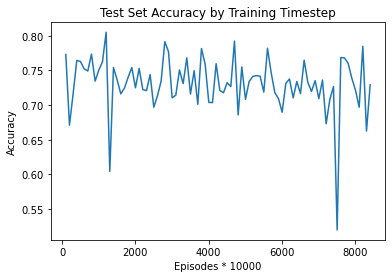

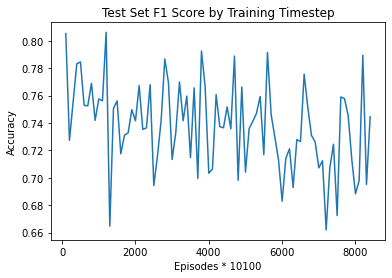

86087
39885  remaining~!
______________Attack Distributions Chosen___________________
{7: 258681, 30: 6691, 33: 68998, 18: 2847, 12: 13759, 11: 2146, 1: 4889, 13: 3157, 17: 11120, 28: 47296, 34: 59887, 38: 2, 6: 4965, 3: 9993, 22: 23797, 15: 21033, 5: 3389, 14: 110095, 4: 131179, 26: 3620, 2: 23379, 35: 3663, 16: 26413}
86095
39877  remaining~!
______________Attack Distributions Chosen___________________
{7: 259068, 30: 6694, 33: 68998, 18: 2848, 12: 13759, 11: 2146, 1: 4889, 13: 3158, 17: 11121, 28: 47296, 34: 60391, 38: 2, 6: 4966, 3: 9993, 22: 23896, 15: 21034, 5: 3389, 14: 110096, 4: 131180, 26: 3620, 2: 23379, 35: 3663, 16: 26413}
86117
39855  remaining~!
______________Attack Distributions Chosen___________________
{7: 260057, 30: 6697, 33: 68998, 18: 2848, 12: 13760, 11: 2146, 1: 4889, 13: 3158, 17: 11124, 28: 47296, 34: 60392, 38: 2, 6: 4967, 3: 9993, 22: 23896, 15: 21034, 5: 3389, 14: 110096, 4: 131180, 26: 3620, 2: 23379, 35: 3665, 16: 26413}
86139
39833  remaining~!
_________

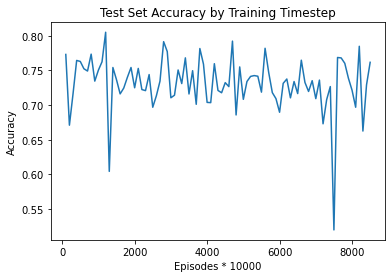

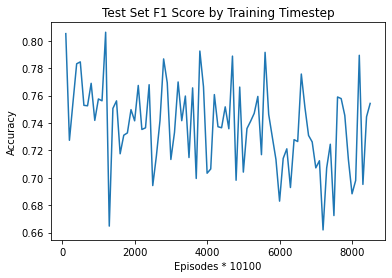

86287
39685  remaining~!
______________Attack Distributions Chosen___________________
{7: 267916, 30: 6721, 33: 69001, 18: 2852, 12: 13771, 11: 2154, 1: 4896, 13: 3169, 17: 11128, 28: 47299, 34: 60394, 38: 2, 6: 4971, 3: 9998, 22: 23906, 15: 21035, 5: 3397, 14: 110100, 4: 131184, 26: 3632, 2: 23384, 35: 3671, 16: 26418}
86313
39659  remaining~!
______________Attack Distributions Chosen___________________
{7: 268902, 30: 6725, 33: 69001, 18: 2853, 12: 13773, 11: 2154, 1: 4897, 13: 3169, 17: 11128, 28: 47299, 34: 60394, 38: 2, 6: 4971, 3: 10001, 22: 23906, 15: 21036, 5: 3398, 14: 110100, 4: 131184, 26: 3632, 2: 23384, 35: 3671, 16: 26419}
86333
39639  remaining~!
______________Attack Distributions Chosen___________________
{7: 269888, 30: 6727, 33: 69001, 18: 2854, 12: 13774, 11: 2154, 1: 4899, 13: 3169, 17: 11128, 28: 47301, 34: 60396, 38: 2, 6: 4971, 3: 10001, 22: 23906, 15: 21037, 5: 3399, 14: 110100, 4: 131184, 26: 3632, 2: 23384, 35: 3672, 16: 26420}
86348
39624  remaining~!
_______

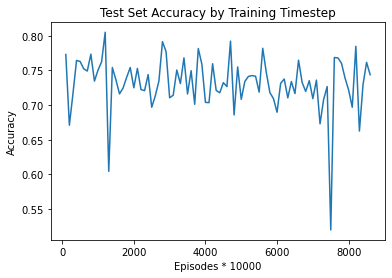

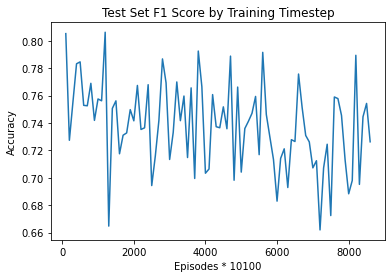

86403
39569  remaining~!
______________Attack Distributions Chosen___________________
{7: 272465, 30: 6749, 33: 69379, 18: 2860, 12: 13780, 11: 2155, 1: 4902, 13: 3172, 17: 11136, 28: 47311, 34: 60401, 38: 2, 6: 4974, 3: 10004, 22: 23909, 15: 25982, 5: 3404, 14: 110104, 4: 131187, 26: 3638, 2: 23388, 35: 3675, 16: 26422}
86414
39558  remaining~!
______________Attack Distributions Chosen___________________
{7: 272598, 30: 6754, 33: 69380, 18: 2860, 12: 13781, 11: 2155, 1: 4902, 13: 3172, 17: 11136, 28: 47311, 34: 60401, 38: 2, 6: 4975, 3: 10004, 22: 23909, 15: 26835, 5: 3404, 14: 110104, 4: 131188, 26: 3639, 2: 23389, 35: 3675, 16: 26425}
86432
39540  remaining~!
______________Attack Distributions Chosen___________________
{7: 273583, 30: 6762, 33: 69380, 18: 2861, 12: 13781, 11: 2155, 1: 4902, 13: 3174, 17: 11137, 28: 47311, 34: 60401, 38: 2, 6: 4975, 3: 10004, 22: 23910, 15: 26835, 5: 3404, 14: 110104, 4: 131189, 26: 3639, 2: 23390, 35: 3675, 16: 26425}
86451
39521  remaining~!
______

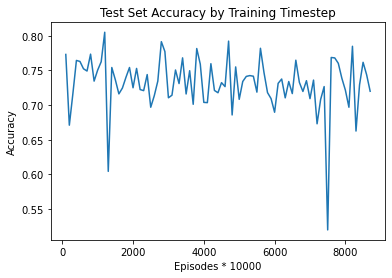

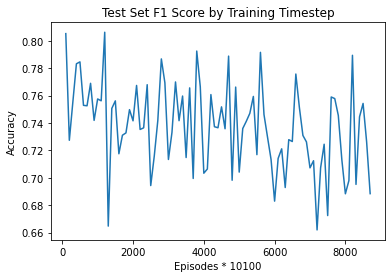

86569
39403  remaining~!
______________Attack Distributions Chosen___________________
{7: 279479, 30: 6782, 33: 70511, 18: 2868, 12: 13787, 11: 2158, 1: 4907, 13: 3180, 17: 11145, 28: 47314, 34: 60405, 38: 2, 6: 4977, 3: 10007, 22: 23913, 15: 27695, 5: 3415, 14: 110109, 4: 131193, 26: 3645, 2: 23399, 35: 3679, 16: 26429}
86574
39398  remaining~!
______________Attack Distributions Chosen___________________
{7: 279484, 30: 6787, 33: 70512, 18: 2868, 12: 13788, 11: 2159, 1: 4909, 13: 3180, 17: 11147, 28: 47315, 34: 60406, 38: 2, 6: 4978, 3: 10008, 22: 23915, 15: 28669, 5: 3416, 14: 110109, 4: 131193, 26: 3645, 2: 23400, 35: 3680, 16: 26429}
86579
39393  remaining~!
______________Attack Distributions Chosen___________________
{7: 279574, 30: 6789, 33: 70512, 18: 2869, 12: 13788, 11: 2160, 1: 4912, 13: 3180, 17: 11148, 28: 47315, 34: 60406, 38: 2, 6: 4980, 3: 10008, 22: 23915, 15: 29567, 5: 3416, 14: 110110, 4: 131194, 26: 3645, 2: 23400, 35: 3680, 16: 26429}
86583
39389  remaining~!
______

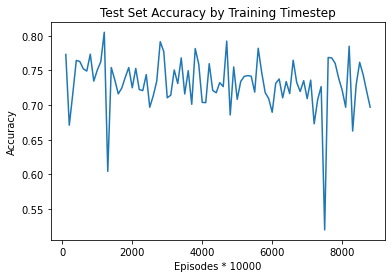

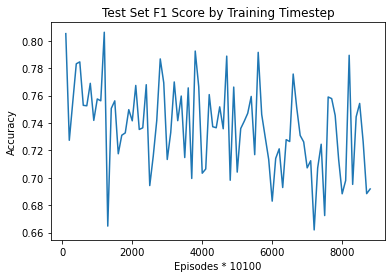

86651
39321  remaining~!
______________Attack Distributions Chosen___________________
{7: 282920, 30: 6810, 33: 73447, 18: 2880, 12: 13792, 11: 2162, 1: 4919, 13: 3189, 17: 11153, 28: 47318, 34: 60410, 38: 2, 6: 4983, 3: 10015, 22: 23922, 15: 31179, 5: 3422, 14: 110112, 4: 131196, 26: 3647, 2: 23408, 35: 3684, 16: 26429}
86676
39296  remaining~!
______________Attack Distributions Chosen___________________
{7: 283911, 30: 6812, 33: 73448, 18: 2880, 12: 13793, 11: 2163, 1: 4919, 13: 3189, 17: 11153, 28: 47319, 34: 60410, 38: 2, 6: 4984, 3: 10015, 22: 23922, 15: 31180, 5: 3422, 14: 110112, 4: 131197, 26: 3647, 2: 23408, 35: 3684, 16: 26429}
86698
39274  remaining~!
______________Attack Distributions Chosen___________________
{7: 284895, 30: 6815, 33: 73448, 18: 2881, 12: 13793, 11: 2163, 1: 4921, 13: 3190, 17: 11153, 28: 47320, 34: 60411, 38: 2, 6: 4985, 3: 10015, 22: 23923, 15: 31181, 5: 3422, 14: 110112, 4: 131197, 26: 3649, 2: 23409, 35: 3685, 16: 26429}
86714
39258  remaining~!
______

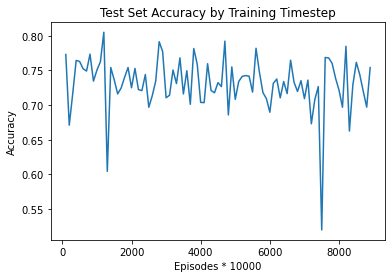

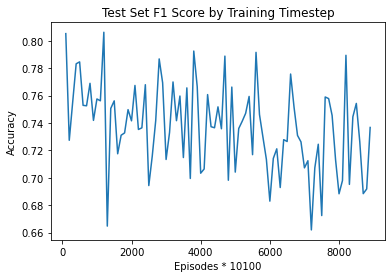

86776
39196  remaining~!
______________Attack Distributions Chosen___________________
{7: 288380, 30: 6843, 33: 73452, 18: 2887, 12: 13799, 11: 2174, 1: 4928, 13: 3195, 17: 11157, 28: 47324, 34: 60413, 38: 2, 6: 4989, 3: 10020, 22: 23928, 15: 35575, 5: 3431, 14: 110115, 4: 131199, 26: 3653, 2: 23415, 35: 3687, 16: 26433}
86795
39177  remaining~!
______________Attack Distributions Chosen___________________
{7: 289364, 30: 6847, 33: 73455, 18: 2888, 12: 13800, 11: 2174, 1: 4928, 13: 3197, 17: 11158, 28: 47324, 34: 60413, 38: 2, 6: 4989, 3: 10021, 22: 23928, 15: 35576, 5: 3431, 14: 110115, 4: 131200, 26: 3653, 2: 23415, 35: 3687, 16: 26434}
86806
39166  remaining~!
______________Attack Distributions Chosen___________________
{7: 289864, 30: 6851, 33: 73455, 18: 2890, 12: 13801, 11: 2175, 1: 4928, 13: 3197, 17: 11158, 28: 47325, 34: 60414, 38: 2, 6: 4991, 3: 10023, 22: 23928, 15: 35577, 5: 3432, 14: 110115, 4: 131202, 26: 3654, 2: 23895, 35: 3687, 16: 26435}
86806
39166  remaining~!
______

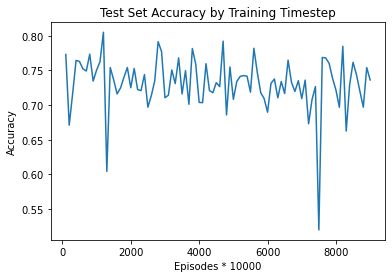

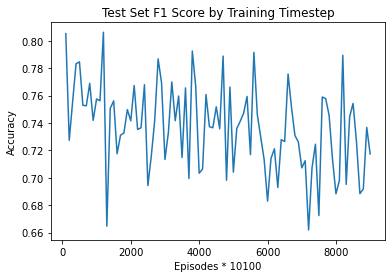

86831
39141  remaining~!
______________Attack Distributions Chosen___________________
{7: 289909, 30: 6876, 33: 73882, 18: 2893, 12: 13810, 11: 2179, 1: 4932, 13: 3206, 17: 11165, 28: 47329, 34: 60419, 38: 2, 6: 4998, 3: 10027, 22: 23932, 15: 39346, 5: 3435, 14: 110118, 4: 131207, 26: 3660, 2: 27543, 35: 3690, 16: 26441}
86832
39140  remaining~!
______________Attack Distributions Chosen___________________
{7: 289913, 30: 6878, 33: 74753, 18: 2894, 12: 13810, 11: 2179, 1: 4933, 13: 3206, 17: 11166, 28: 47329, 34: 60422, 38: 2, 6: 4999, 3: 10029, 22: 23932, 15: 39456, 5: 3435, 14: 110119, 4: 131208, 26: 3661, 2: 27544, 35: 3690, 16: 26441}
86838
39134  remaining~!
______________Attack Distributions Chosen___________________
{7: 289916, 30: 6884, 33: 75555, 18: 2896, 12: 13811, 11: 2179, 1: 4933, 13: 3207, 17: 11168, 28: 47330, 34: 60423, 38: 2, 6: 4999, 3: 10029, 22: 23932, 15: 39635, 5: 3435, 14: 110119, 4: 131208, 26: 3663, 2: 27544, 35: 3690, 16: 26441}
86840
39132  remaining~!
______

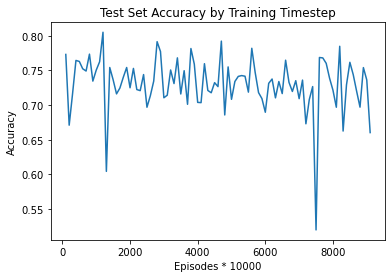

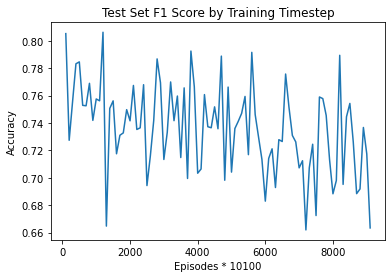

86885
39087  remaining~!
______________Attack Distributions Chosen___________________
{7: 290662, 30: 6916, 33: 78194, 18: 2903, 12: 13816, 11: 2184, 1: 4939, 13: 3212, 17: 11173, 28: 47333, 34: 60426, 38: 2, 6: 5001, 3: 10128, 22: 23934, 15: 42477, 5: 3436, 14: 110122, 4: 131208, 26: 3669, 2: 29125, 35: 3694, 16: 26445}
86890
39082  remaining~!
______________Attack Distributions Chosen___________________
{7: 290667, 30: 6922, 33: 79169, 18: 2907, 12: 13816, 11: 2184, 1: 4940, 13: 3212, 17: 11174, 28: 47333, 34: 60427, 38: 2, 6: 5003, 3: 10129, 22: 23934, 15: 42478, 5: 3437, 14: 110122, 4: 131208, 26: 3669, 2: 29125, 35: 3694, 16: 26447}
86891
39081  remaining~!
______________Attack Distributions Chosen___________________
{7: 290671, 30: 6923, 33: 80157, 18: 2907, 12: 13817, 11: 2184, 1: 4941, 13: 3212, 17: 11175, 28: 47334, 34: 60427, 38: 2, 6: 5003, 3: 10129, 22: 23934, 15: 42478, 5: 3437, 14: 110122, 4: 131208, 26: 3669, 2: 29127, 35: 3694, 16: 26448}
86892
39080  remaining~!
______

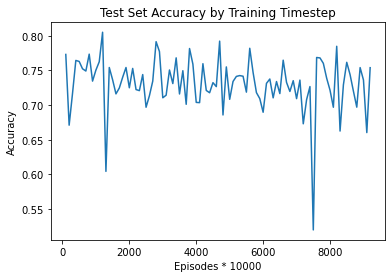

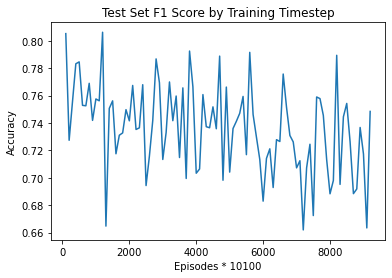

86917
39055  remaining~!
______________Attack Distributions Chosen___________________
{7: 290714, 30: 6942, 33: 80325, 18: 2914, 12: 13821, 11: 2191, 1: 4947, 13: 3217, 17: 11180, 28: 47340, 34: 65996, 38: 2, 6: 5013, 3: 10132, 22: 23941, 15: 42482, 5: 3978, 14: 110124, 4: 131907, 26: 3673, 2: 29133, 35: 4575, 16: 26452}
86922
39050  remaining~!
______________Attack Distributions Chosen___________________
{7: 290717, 30: 6946, 33: 80326, 18: 2915, 12: 13821, 11: 2192, 1: 4948, 13: 3218, 17: 11180, 28: 47340, 34: 65998, 38: 2, 6: 5013, 3: 10132, 22: 23942, 15: 42483, 5: 3978, 14: 110124, 4: 132890, 26: 3673, 2: 29133, 35: 4576, 16: 26452}
86926
39046  remaining~!
______________Attack Distributions Chosen___________________
{7: 290719, 30: 6950, 33: 80326, 18: 2915, 12: 13823, 11: 2192, 1: 4948, 13: 3218, 17: 11180, 28: 47341, 34: 66000, 38: 2, 6: 5013, 3: 10132, 22: 23942, 15: 42484, 5: 3978, 14: 110124, 4: 133876, 26: 3673, 2: 29133, 35: 4577, 16: 26453}
86934
39038  remaining~!
______

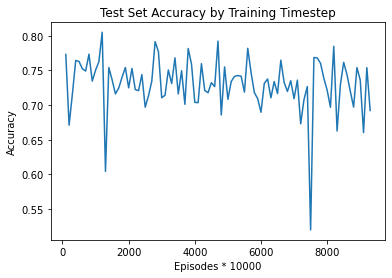

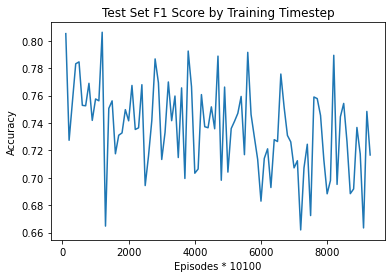

86956
39016  remaining~!
______________Attack Distributions Chosen___________________
{7: 290757, 30: 6981, 33: 80329, 18: 2917, 12: 13830, 11: 2194, 1: 4950, 13: 3221, 17: 11184, 28: 47351, 34: 66004, 38: 2, 6: 5015, 3: 10138, 22: 23949, 15: 42490, 5: 3983, 14: 110125, 4: 141731, 26: 3675, 2: 29137, 35: 4580, 16: 26456}
86958
39014  remaining~!
______________Attack Distributions Chosen___________________
{7: 290764, 30: 6984, 33: 80330, 18: 2917, 12: 13833, 11: 2194, 1: 4950, 13: 3221, 17: 11184, 28: 47351, 34: 66005, 38: 2, 6: 5017, 3: 10139, 22: 23950, 15: 42492, 5: 3983, 14: 110125, 4: 142707, 26: 3675, 2: 29139, 35: 4580, 16: 26457}
86964
39008  remaining~!
______________Attack Distributions Chosen___________________
{7: 290765, 30: 6989, 33: 80824, 18: 2917, 12: 13834, 11: 2194, 1: 4951, 13: 3223, 17: 11185, 28: 47351, 34: 66005, 38: 2, 6: 5018, 3: 10139, 22: 23950, 15: 42493, 5: 3983, 14: 110125, 4: 143196, 26: 3675, 2: 29141, 35: 4580, 16: 26459}
86967
39005  remaining~!
______

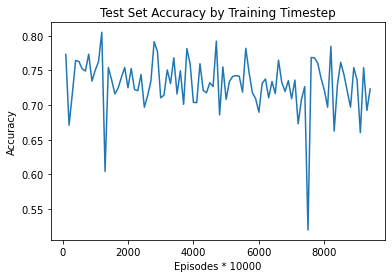

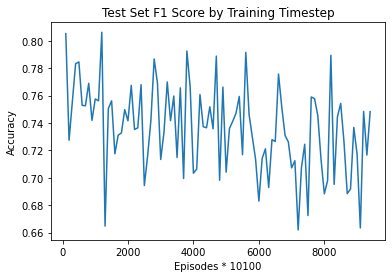

86987
38985  remaining~!
______________Attack Distributions Chosen___________________
{7: 291160, 30: 7007, 33: 84217, 18: 2921, 12: 13837, 11: 2199, 1: 4961, 13: 3232, 17: 11192, 28: 47354, 34: 66411, 38: 2, 6: 5020, 3: 10141, 22: 23958, 15: 43485, 5: 4408, 14: 110131, 4: 143198, 26: 3681, 2: 31433, 35: 4588, 16: 26463}
86993
38979  remaining~!
______________Attack Distributions Chosen___________________
{7: 292147, 30: 7007, 33: 84217, 18: 2922, 12: 13837, 11: 2200, 1: 4962, 13: 3233, 17: 11193, 28: 47354, 34: 66412, 38: 2, 6: 5021, 3: 10141, 22: 23959, 15: 43485, 5: 4410, 14: 110131, 4: 143198, 26: 3682, 2: 31433, 35: 4590, 16: 26463}
87011
38961  remaining~!
______________Attack Distributions Chosen___________________
{7: 293131, 30: 7011, 33: 84218, 18: 2923, 12: 13837, 11: 2201, 1: 4963, 13: 3235, 17: 11194, 28: 47354, 34: 66412, 38: 2, 6: 5021, 3: 10142, 22: 23960, 15: 43486, 5: 4411, 14: 110131, 4: 143198, 26: 3683, 2: 31433, 35: 4590, 16: 26463}
87027
38945  remaining~!
______

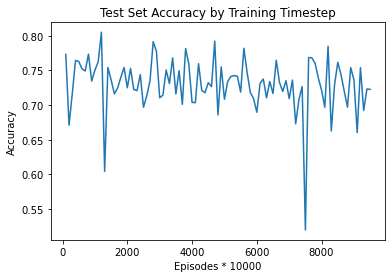

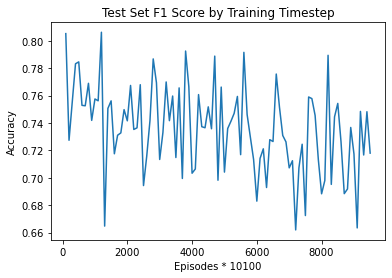

87133
38839  remaining~!
______________Attack Distributions Chosen___________________
{7: 301032, 30: 7035, 33: 84221, 18: 2926, 12: 13841, 11: 2208, 1: 4968, 13: 3241, 17: 11197, 28: 47358, 34: 66414, 38: 2, 6: 5025, 3: 10148, 22: 23962, 15: 43489, 5: 4414, 14: 110132, 4: 143200, 26: 3687, 2: 31435, 35: 4596, 16: 26468}
87144
38828  remaining~!
______________Attack Distributions Chosen___________________
{7: 302018, 30: 7039, 33: 84223, 18: 2926, 12: 13842, 11: 2208, 1: 4968, 13: 3241, 17: 11198, 28: 47358, 34: 66414, 38: 2, 6: 5026, 3: 10149, 22: 23962, 15: 43490, 5: 4415, 14: 110133, 4: 143200, 26: 3687, 2: 31436, 35: 4596, 16: 26468}
87159
38813  remaining~!
______________Attack Distributions Chosen___________________
{7: 303003, 30: 7039, 33: 84223, 18: 2926, 12: 13845, 11: 2208, 1: 4971, 13: 3241, 17: 11199, 28: 47358, 34: 66414, 38: 2, 6: 5027, 3: 10149, 22: 23962, 15: 43490, 5: 4415, 14: 110133, 4: 143205, 26: 3688, 2: 31437, 35: 4596, 16: 26468}
87168
38804  remaining~!
______

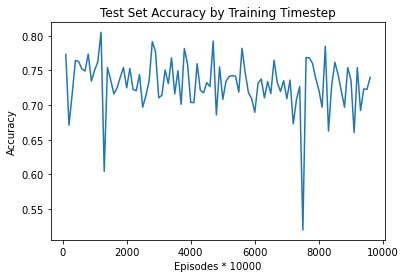

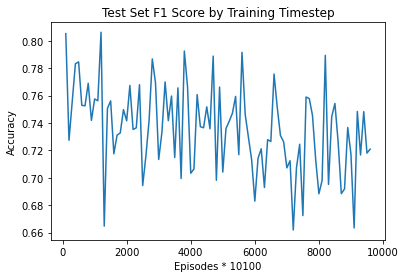

87245
38727  remaining~!
______________Attack Distributions Chosen___________________
{7: 310906, 30: 7055, 33: 84226, 18: 2932, 12: 13852, 11: 2209, 1: 4973, 13: 3245, 17: 11202, 28: 47361, 34: 66419, 38: 2, 6: 5034, 3: 10152, 22: 23967, 15: 43493, 5: 4418, 14: 110135, 4: 143209, 26: 3692, 2: 31443, 35: 4599, 16: 26475}
87257
38715  remaining~!
______________Attack Distributions Chosen___________________
{7: 311893, 30: 7061, 33: 84226, 18: 2932, 12: 13852, 11: 2209, 1: 4973, 13: 3246, 17: 11203, 28: 47362, 34: 66419, 38: 2, 6: 5035, 3: 10153, 22: 23968, 15: 43493, 5: 4418, 14: 110135, 4: 143209, 26: 3693, 2: 31443, 35: 4599, 16: 26475}
87271
38701  remaining~!
______________Attack Distributions Chosen___________________
{7: 312878, 30: 7063, 33: 84226, 18: 2933, 12: 13854, 11: 2210, 1: 4973, 13: 3247, 17: 11204, 28: 47362, 34: 66420, 38: 2, 6: 5037, 3: 10154, 22: 23968, 15: 43493, 5: 4419, 14: 110135, 4: 143209, 26: 3693, 2: 31445, 35: 4599, 16: 26475}
87286
38686  remaining~!
______

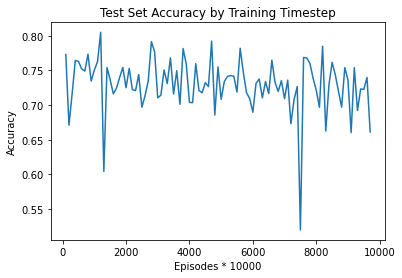

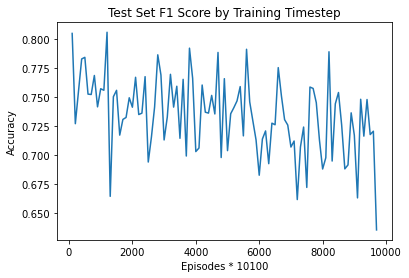

87367
38605  remaining~!
______________Attack Distributions Chosen___________________
{7: 318451, 30: 7094, 33: 84233, 18: 2944, 12: 13865, 11: 2211, 1: 4975, 13: 3256, 17: 11211, 28: 47367, 34: 66424, 38: 2, 6: 5041, 3: 10162, 22: 23977, 15: 43498, 5: 4423, 14: 110137, 4: 144678, 26: 3698, 2: 31451, 35: 4604, 16: 27297}
87379
38593  remaining~!
______________Attack Distributions Chosen___________________
{7: 319441, 30: 7098, 33: 84233, 18: 2946, 12: 13866, 11: 2212, 1: 4975, 13: 3256, 17: 11211, 28: 47367, 34: 66424, 38: 2, 6: 5042, 3: 10162, 22: 23977, 15: 43498, 5: 4423, 14: 110137, 4: 144678, 26: 3698, 2: 31451, 35: 4604, 16: 27298}
87396
38576  remaining~!
______________Attack Distributions Chosen___________________
{7: 320421, 30: 7101, 33: 84233, 18: 2948, 12: 13867, 11: 2214, 1: 4975, 13: 3257, 17: 11212, 28: 47368, 34: 66425, 38: 2, 6: 5042, 3: 10163, 22: 23979, 15: 43498, 5: 4423, 14: 110137, 4: 144680, 26: 3698, 2: 31451, 35: 4606, 16: 27299}
87404
38568  remaining~!
______

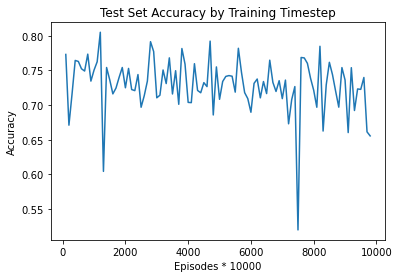

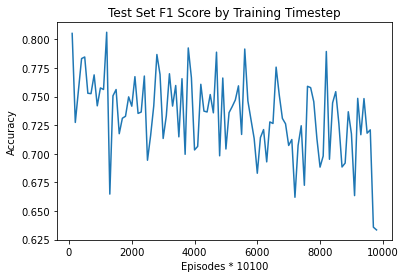

87463
38509  remaining~!
______________Attack Distributions Chosen___________________
{7: 325249, 30: 7125, 33: 84239, 18: 2954, 12: 13872, 11: 2215, 1: 4981, 13: 3264, 17: 11217, 28: 47371, 34: 66427, 38: 2, 6: 5043, 3: 13233, 22: 23983, 15: 43500, 5: 4426, 14: 110142, 4: 144684, 26: 3702, 2: 31457, 35: 4610, 16: 27303}
87467
38505  remaining~!
______________Attack Distributions Chosen___________________
{7: 325258, 30: 7130, 33: 84239, 18: 2954, 12: 13873, 11: 2215, 1: 4983, 13: 3264, 17: 11219, 28: 47371, 34: 66427, 38: 2, 6: 5043, 3: 14207, 22: 23984, 15: 43501, 5: 4426, 14: 110143, 4: 144684, 26: 3703, 2: 31457, 35: 4613, 16: 27303}
87472
38500  remaining~!
______________Attack Distributions Chosen___________________
{7: 325262, 30: 7134, 33: 84239, 18: 2954, 12: 13876, 11: 2215, 1: 4984, 13: 3265, 17: 11220, 28: 47371, 34: 66427, 38: 2, 6: 5044, 3: 15186, 22: 23984, 15: 43502, 5: 4426, 14: 110143, 4: 144684, 26: 3703, 2: 31459, 35: 4615, 16: 27304}
87476
38496  remaining~!
______

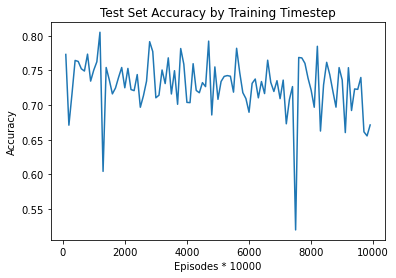

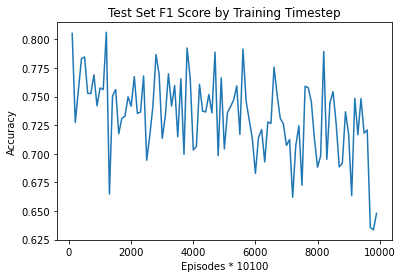

87503
38469  remaining~!
______________Attack Distributions Chosen___________________
{7: 325303, 30: 7165, 33: 84243, 18: 2960, 12: 13880, 11: 2220, 1: 4990, 13: 3267, 17: 11227, 28: 47377, 34: 66432, 38: 2, 6: 5046, 3: 15512, 22: 23990, 15: 43504, 5: 4432, 14: 110147, 4: 152201, 26: 3704, 2: 31467, 35: 4622, 16: 27308}
87508
38464  remaining~!
______________Attack Distributions Chosen___________________
{7: 325305, 30: 7169, 33: 84243, 18: 2960, 12: 13880, 11: 2221, 1: 4991, 13: 3268, 17: 11229, 28: 47379, 34: 66432, 38: 2, 6: 5047, 3: 15512, 22: 23990, 15: 43505, 5: 4434, 14: 110147, 4: 153183, 26: 3704, 2: 31467, 35: 4623, 16: 27308}
87510
38462  remaining~!
______________Attack Distributions Chosen___________________
{7: 325307, 30: 7171, 33: 84246, 18: 2960, 12: 13881, 11: 2221, 1: 4992, 13: 3269, 17: 11230, 28: 47380, 34: 66434, 38: 2, 6: 5048, 3: 15513, 22: 23991, 15: 43505, 5: 4435, 14: 110149, 4: 154160, 26: 3704, 2: 31468, 35: 4625, 16: 27308}
87511
38461  remaining~!
______

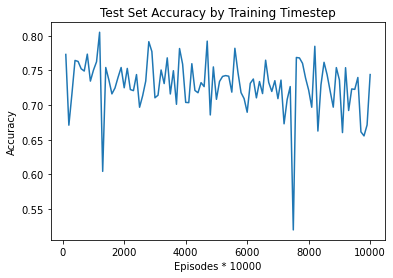

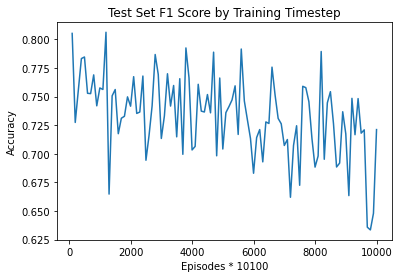

In [61]:
from ray.rllib.agents.dqn import DQNTrainer
conf = dqn.DEFAULT_CONFIG.copy()
conf2 = {
    'multiagent': {
            'policies': {
                    'environment': (None, AdversarialCustomEnv.obs_mapping['env'], AdversarialCustomEnv.action_mapping['env'], {'agent_id': 'env', 'Gamma': 0.8}),
                    'classifier':  (None, AdversarialCustomEnv.obs_mapping['clf'], AdversarialCustomEnv.action_mapping['clf'], {'agent_id': 'clf', 'Gamma': 0.01})
            },
            'policy_mapping_fn': lambda agent_id: 'environment' if agent_id == 'env' else 'classifier',
            'policies_to_train': ['environment', 'classifier'],
    },
}
conf2['framework'] = 'torch'
conf2['timesteps_per_iteration'] = 10_000
a = DQNTrainer(conf2, env = AdversarialCustomEnv)
accs = []
f1s  = []
for i in range(100):
    a.train()
    acc_, f1s_ = eval_model(print_results=False)
    accs.append(acc_)
    f1s.append(f1s_)
    plot_learning(10_000, accs)
    plot_learning(10_000, f1s)

In [68]:
a.workers.local_worker().env.att_dist

{7: 325341,
 30: 7195,
 33: 84251,
 18: 2968,
 12: 13891,
 11: 2228,
 1: 4998,
 13: 3276,
 17: 11231,
 28: 47385,
 34: 66444,
 38: 2,
 6: 5052,
 3: 16843,
 22: 23995,
 15: 43509,
 5: 4439,
 14: 110153,
 4: 159683,
 26: 3705,
 2: 31473,
 35: 4627,
 16: 27311}

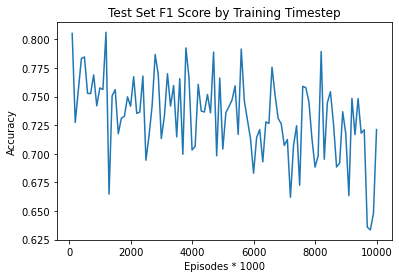

In [62]:
def plot_learning(period, metric):
    name_ = 'Accuracy' if metric == accs else 'F1 Score'
    plt.plot([100*i for i in range(1, len(metric)+1)], metric)
    plt.title('Test Set ' + name_ + ' by Training Timestep')
    plt.xlabel('Episodes * ' + str(period))
    plt.ylabel('Accuracy')
    plt.show()
plot_learning(1000, f1s)

In [49]:
def eval_model(print_results=False):
    rews = 0
    tots = 0
    # correct_dist = {}
    # incorrect_dist = {}
    # percent_dist = {}
    TEST_MATRIX = ae_bin_test.values
    pred = [-1 for i in range(len(TEST_MATRIX))]
    i = 0
    for row in TEST_MATRIX:
        action = a.compute_single_action(row[:-3],
                                 policy_id = 'classifier')
        pred[i] = action
        i += 1
        if action == int(row[-1]):
            rews += 1
            # if row[-2] in correct_dist:
            #     correct_dist[row[-2]] += 1
            # else:
            #     correct_dist[row[-2]] = 1
        # else:
        #     if row[-2] in incorrect_dist:
        #         incorrect_dist[row[-2]] += 1
        #     else:
        #         incorrect_dist[row[-2]] = 1
        tots += 1
    f1_  = f1_score(pred, TEST_MATRIX[:,-1])
    acc_ = accuracy_score(pred, TEST_MATRIX[:,-1])
    if print_results:
        print('Correct: ', rews)
        print('Total: ', tots)
        print('Accuracy ', rews/tots)
        print('F1: ', f1_score(pred, TEST_MATRIX[:,-1]))
    return acc_, f1_
a, f = eval_model()
a
    # obs, reward, done, info = env.step(action)
    # env.render()
    # if done:
    #   obs = env.reset()

0.7652486359402032

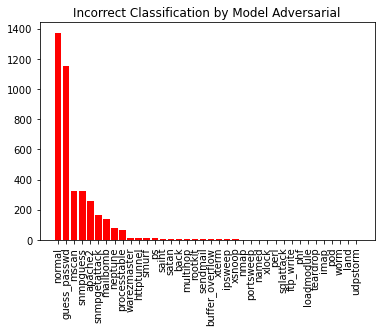

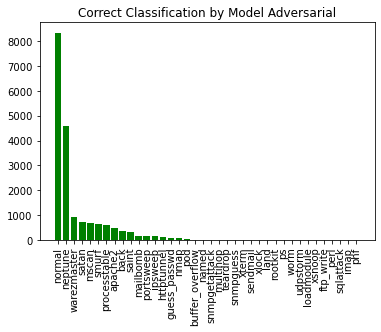

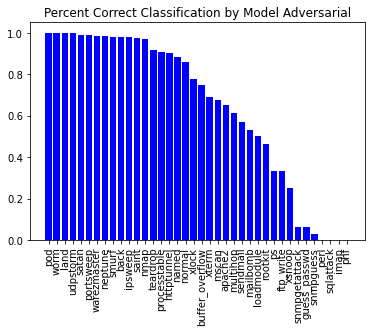

In [35]:
percent_dist = {
    key: correct_dist[key]/ (correct_dist[key] + incorrect_dist[key]) if key in incorrect_dist else 1 for key in correct_dist.keys() 
}
incorrect_dist2, correct_dist2, percent_dist2 = get_stats(pred, TEST_MATRIX[:,-1])
draw_plots(incorrect_dist2, correct_dist2, percent_dist2, 'Adversarial', prefix='02', save=True)

<function matplotlib.pyplot.show(close=None, block=None)>

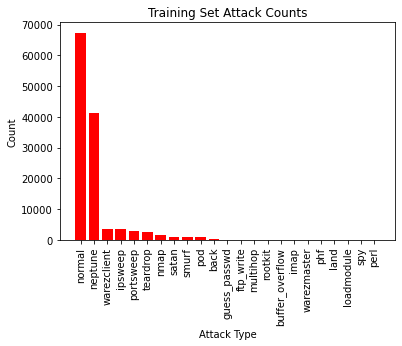

In [41]:
plt.bar(train_data['attack'].unique(), train_data['attack'].value_counts(), color='r')
plt.title('Training Set Attack Counts')
plt.ylabel('Count')
plt.xlabel('Attack Type')
plt.xticks(rotation=90)
plt.savefig('Training_set_atk_count.png',bbox_inches='tight')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

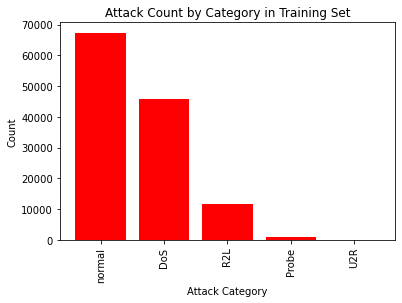

In [43]:
d = train_data['attack'].map(attack_category_map)
plt.bar(d.unique(), d.value_counts(), color='r')
plt.title('Attack Count by Category in Training Set')
plt.ylabel('Count')
plt.xlabel('Attack Category')
plt.xticks(rotation=90)
plt.savefig('Training_set_atk_count_by_category.png',bbox_inches='tight')
plt.show

In [251]:
def get_stats(pred, true):
    attack_names = test_data['attack'].unique()
    correct   = {i: 0 for i in attack_names}
    incorrect = {i: 0 for i in attack_names}
    percent   = {i: 0 for i in attack_names}

    for i in range(len(pred)):
        tp = atk.decode_attack(pd.Series(TEST_MATRIX[i][-2]))
        tp = tp.values[0]
        if pred[i] == true[i]:
            correct[tp] += 1
        else:
            incorrect[tp] += 1
            
    percent = {
        key: correct[key]/ (correct[key] + incorrect[key]) if key in incorrect else 1 for key in correct.keys() 
    }   
    
    return correct, incorrect, percent
        

In [267]:
def draw_plots(correct, incorrect, percent, Classifier_Name, prefix='00', save=False):
    
    print(correct)
    print(incorrect)
    
    correct_keys   = sorted(correct, key=lambda dict_key: abs(correct[dict_key]), reverse = True)
    incorrect_keys = sorted(incorrect, key=lambda dict_key: abs(incorrect[dict_key]), reverse = True)
    percent_keys   = sorted(percent, key=lambda dict_key: abs(percent[dict_key]), reverse = True)
    
    

    attack_names = test_data['attack'].unique()
    plt.bar(incorrect_keys, sorted(incorrect.values(), reverse=True), color='r')
    plt.xticks(rotation=90)
    plt.title('Incorrect Classification by Model ' + Classifier_Name)
    if save:
        plt.savefig(prefix + 'Incorrect' + Classifier_Name + '.png', bbox_inches='tight')
    plt.show()
    
    plt.bar(correct_keys, sorted(correct.values(), reverse=True), color='g')
    plt.xticks(rotation=90)
    plt.title('Correct Classification by Model ' + Classifier_Name)
    if save:
        plt.savefig(prefix + 'Correct' + Classifier_Name + '.png', bbox_inches='tight')
    plt.show()
    
    plt.bar(percent_keys, sorted(percent.values(), reverse=True), color='b')
    plt.xticks(rotation=90)
    plt.title('Percent Correct Classification by Model ' + Classifier_Name)
    if save:
        plt.savefig(prefix + 'Percent' + Classifier_Name + '.png', bbox_inches='tight')
    plt.show()
